# Sistecredito: Modelos de regresión de ventas

## Librerias

In [10]:
# librerias general  
import numpy as np
import pandas as pd
import joblib
import json
import os
import random
import math
import itertools

# bases de datos
from sklearn import datasets
from scipy.io import loadmat


# exploracion
#import missingno as msno
from scipy.stats import chi2_contingency
from itertools import cycle, combinations
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy import stats
from scipy.spatial.distance import mahalanobis
from matplotlib.colors import ListedColormap
import scipy as sp
from sklearn.covariance import MinCovDet

# funciones
from funciones.data_exploration import explore
from funciones.feature_cleaning import missing_data, outlier, rare_values
from funciones.feature_cleaning import missing_data as ms
from funciones.feature_cleaning import outlier as ot
from funciones.feature_cleaning import rare_values as ra
from funciones.feature_engineering import discretization as dc
from funciones.feature_engineering import discretization, encoding, transformation
from funciones.feature_selection import embedded_method, feature_shuffle, filter_method, hybrid 




# visualizacion
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix


# pre-procesamiento
import sklearn
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer


# Aprendizaje No Supervisado
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, FactorAnalysis
from sklearn.cluster import KMeans, SpectralClustering, Birch, BisectingKMeans
from sklearn.manifold import TSNE, Isomap
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis


# ML sklearn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# autoML H2O
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # importar h2o GLM elastic net
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
# crear cluster de h2o
h2o.init()


# autoML TPOT
from tpot import TPOTClassifier

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error  
from sklearn.metrics import median_absolute_error, explained_variance_score

# ML pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer



# interpretación de modelo
import shap
from sklearn.inspection import PartialDependenceDisplay, partial_dependence



# DL keras-tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn import model_selection
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.layers import Dense,Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model


# modelos pre-entrenados
from tensorflow.keras.models import clone_model
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.preprocessing.image import load_img  



Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------
H2O_cluster_uptime:         34 mins 14 secs
H2O_cluster_timezone:       America/Bogota
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.42.0.3
H2O_cluster_version_age:    3 months and 16 days
H2O_cluster_name:           H2O_from_python_dfoso_ze1vcs
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    125.2 Mb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.4 final
--------------------------  -----------------------------

## Bases de datos

In [21]:
# cargar bases de datos
entrenamiento = pd.read_csv('data/Entrenamiento.csv', encoding="ISO-8859-1")
prueba = pd.read_csv('data/Testing.csv', encoding="ISO-8859-1")


almacen = pd.read_csv('data/Almacen.csv', encoding="ISO-8859-1")
festivos = pd.read_csv('data/Festivos.csv', encoding="ISO-8859-1")
muestras  = pd.read_csv('data/Muestras.csv', encoding="ISO-8859-1")
petroleo = pd.read_csv('data/PrecioBarrilPetroleo.csv', encoding="ISO-8859-1")
transacciones = pd.read_csv('data/Transacciones.csv', encoding="ISO-8859-1")
                            


## Preprocesamiento

### Recompilación

In [22]:
train = pd.merge(entrenamiento, almacen, on='AlmacenCodigo')
test = pd.merge(prueba, almacen, on='AlmacenCodigo')
data_externa1 = pd.merge(transacciones, festivos, on='Fecha') 
data_externa= pd.merge(data_externa1, petroleo, on='Fecha')

In [23]:
data_train = pd.merge(train,data_externa, on=['AlmacenCodigo','Fecha'])
#data_test = pd.merge(test,data_externa, on=['AlmacenCodigo','Fecha'])

In [126]:
data_externa1

Fecha  AlmacenCodigo  Transacciones            Tipo Localidad  \
0      01/01/2013             25            770         Festivo  Nacional   
1      05/01/2013              1           1509  Día de trabajo  Nacional   
2      05/01/2013              2           2062  Día de trabajo  Nacional   
3      05/01/2013              3           3623  Día de trabajo  Nacional   
4      05/01/2013              4           1825  Día de trabajo  Nacional   
...           ...            ...            ...             ...       ...   
13906  15/08/2017             50           2804         Festivo     Local   
13907  15/08/2017             51           1573         Festivo     Local   
13908  15/08/2017             52           2255         Festivo     Local   
13909  15/08/2017             53            932         Festivo     Local   
13910  15/08/2017             54            802         Festivo     Local   

      Ubicación              Descripcion Transferidoido  
0       Ecuador       Primer dia del ano          FALSO  
1       Ecuador  Recupero puente Navidad          FALSO  
2       Ecuador  Recupero puente Navidad          FALSO  
3       Ecuador  Recupero puente Navidad          FALSO  
4       Ecuador  Recupero puente Navidad          FALSO  
...         ...                      ...            ...  
13906  Riobamba    Fundacion de Riobamba          FALSO  
13907  Riobamba    Fundacion de Riobamba          FALSO  
13908  Riobamba    Fundacion de Riobamba          FALSO  
13909  Riobamba    Fundacion de Riobamba          FALSO  
13910  Riobamba    Fundacion de Riobamba          FALSO  

[13911 rows x 8 columns]

In [127]:
data_externa

Fecha  AlmacenCodigo  Transacciones     Tipo Localidad Ubicación  \
0     01/01/2013             25            770  Festivo  Nacional   Ecuador   
1     11/02/2013              1            396  Festivo  Nacional   Ecuador   
2     11/02/2013              2           1486  Festivo  Nacional   Ecuador   
3     11/02/2013              3           2532  Festivo  Nacional   Ecuador   
4     11/02/2013              4           1263  Festivo  Nacional   Ecuador   
...          ...            ...            ...      ...       ...       ...   
9754  15/08/2017             50           2804  Festivo     Local  Riobamba   
9755  15/08/2017             51           1573  Festivo     Local  Riobamba   
9756  15/08/2017             52           2255  Festivo     Local  Riobamba   
9757  15/08/2017             53            932  Festivo     Local  Riobamba   
9758  15/08/2017             54            802  Festivo     Local  Riobamba   

                Descripcion Transferidoido  PrecioBarrildePetroleo (En USD)  
0        Primer dia del ano          FALSO                              NaN  
1                  Carnaval          FALSO                            97.01  
2                  Carnaval          FALSO                            97.01  
3                  Carnaval          FALSO                            97.01  
4                  Carnaval          FALSO                            97.01  
...                     ...            ...                              ...  
9754  Fundacion de Riobamba          FALSO                            47.57  
9755  Fundacion de Riobamba          FALSO                            47.57  
9756  Fundacion de Riobamba          FALSO                            47.57  
9757  Fundacion de Riobamba          FALSO                            47.57  
9758  Fundacion de Riobamba          FALSO                            47.57  

[9759 rows x 9 columns]

In [128]:
train

CodigoVenta       Fecha  AlmacenCodigo  \
0                  0  01/01/2013              1   
1                  1  01/01/2013              1   
2                  2  01/01/2013              1   
3                  3  01/01/2013              1   
4                  4  01/01/2013              1   
...              ...         ...            ...   
1048570      1047811  12/08/2014              9   
1048571      1047812  12/08/2014              9   
1048572      1047813  12/08/2014              9   
1048573      1047814  12/08/2014              9   
1048574      1047815  12/08/2014              9   

                             Categoría  CantidadVenta  EnPromocion Ciudad  \
0                            AUTOMOTOR        0.00000            0  Quito   
1                     CUIDADO DEL BEBÉ        0.00000            0  Quito   
2                              BELLEZA        0.00000            0  Quito   
3                              BEBIDAS        0.00000            0  Quito   
4                               LIBROS        0.00000            0  Quito   
...                                ...            ...          ...    ...   
1048570                        AVÍCOLA      611.14996            0  Quito   
1048571           ALIMENTOS PREPARADOS       53.65900            0  Quito   
1048572      FRUTAS, VERDURAS Y GRANOS        0.00000            0  Quito   
1048573  MATERIAL ESCOLAR Y DE OFICINA        0.00000            0  Quito   
1048574                  COMIDA DE MAR        8.08800            0  Quito   

            Estado Tipo  Grupo  
0        Pichincha    D     13  
1        Pichincha    D     13  
2        Pichincha    D     13  
3        Pichincha    D     13  
4        Pichincha    D     13  
...            ...  ...    ...  
1048570  Pichincha    B      6  
1048571  Pichincha    B      6  
1048572  Pichincha    B      6  
1048573  Pichincha    B      6  
1048574  Pichincha    B      6  

[1048575 rows x 10 columns]

In [129]:
test

CodigoVenta       Fecha  AlmacenCodigo                      Categoría  \
0          3000888  16/08/2017              1                      AUTOMOTOR   
1          3000889  16/08/2017              1                      BABY CARE   
2          3000890  16/08/2017              1                        BELLEZA   
3          3000891  16/08/2017              1                        BEBIDAS   
4          3000892  16/08/2017              1                         LIBROS   
...            ...         ...            ...                            ...   
28507      3029395  31/08/2017              9                        AVÍCOLA   
28508      3029396  31/08/2017              9           ALIMENTOS PREPARADOS   
28509      3029397  31/08/2017              9      FRUTAS, VERDURAS Y GRANOS   
28510      3029398  31/08/2017              9  MATERIAL ESCOLAR Y DE OFICINA   
28511      3029399  31/08/2017              9                  COMIDA DE MAR   

       EnPromocion Ciudad     Estado Tipo  Grupo  
0                0  Quito  Pichincha    D     13  
1                0  Quito  Pichincha    D     13  
2                2  Quito  Pichincha    D     13  
3               20  Quito  Pichincha    D     13  
4                0  Quito  Pichincha    D     13  
...            ...    ...        ...  ...    ...  
28507            1  Quito  Pichincha    B      6  
28508            0  Quito  Pichincha    B      6  
28509            1  Quito  Pichincha    B      6  
28510            9  Quito  Pichincha    B      6  
28511            0  Quito  Pichincha    B      6  

[28512 rows x 9 columns]

In [130]:
data_train

CodigoVenta       Fecha  AlmacenCodigo                      Categoría  \
0            73062  11/02/2013              1                      AUTOMOTOR   
1            73063  11/02/2013              1               CUIDADO DEL BEBÉ   
2            73064  11/02/2013              1                        BELLEZA   
3            73065  11/02/2013              1                        BEBIDAS   
4            73066  11/02/2013              1                         LIBROS   
...            ...         ...            ...                            ...   
86554      1035337  05/08/2014              9                        AVÍCOLA   
86555      1035338  05/08/2014              9           ALIMENTOS PREPARADOS   
86556      1035339  05/08/2014              9      FRUTAS, VERDURAS Y GRANOS   
86557      1035340  05/08/2014              9  MATERIAL ESCOLAR Y DE OFICINA   
86558      1035341  05/08/2014              9                  COMIDA DE MAR   

       CantidadVenta  EnPromocion Ciudad     Estado Tipo_x  Grupo  \
0           0.000000            0  Quito  Pichincha      D     13   
1           0.000000            0  Quito  Pichincha      D     13   
2           0.000000            0  Quito  Pichincha      D     13   
3         172.000000            0  Quito  Pichincha      D     13   
4           0.000000            0  Quito  Pichincha      D     13   
...              ...          ...    ...        ...    ...    ...   
86554     595.542000            0  Quito  Pichincha      B      6   
86555     129.971000            0  Quito  Pichincha      B      6   
86556       0.000000            0  Quito  Pichincha      B      6   
86557       0.000000            0  Quito  Pichincha      B      6   
86558       9.535999            0  Quito  Pichincha      B      6   

       Transacciones   Tipo_y Localidad   Ubicación              Descripcion  \
0                396  Festivo  Nacional     Ecuador                 Carnaval   
1                396  Festivo  Nacional     Ecuador                 Carnaval   
2                396  Festivo  Nacional     Ecuador                 Carnaval   
3                396  Festivo  Nacional     Ecuador                 Carnaval   
4                396  Festivo  Nacional     Ecuador                 Carnaval   
...              ...      ...       ...         ...                      ...   
86554           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86555           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86556           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86557           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86558           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   

      Transferidoido  PrecioBarrildePetroleo (En USD)  
0              FALSO                            97.01  
1              FALSO                            97.01  
2              FALSO                            97.01  
3              FALSO                            97.01  
4              FALSO                            97.01  
...              ...                              ...  
86554          FALSO                            97.34  
86555          FALSO                            97.34  
86556          FALSO                            97.34  
86557          FALSO                            97.34  
86558          FALSO                            97.34  

[86559 rows x 17 columns]

In [131]:
#data_test

In [132]:
almacen

AlmacenCodigo         Ciudad                          Estado Tipo  Grupo
0               1          Quito                       Pichincha    D     13
1               2          Quito                       Pichincha    D     13
2               3          Quito                       Pichincha    D      8
3               4          Quito                       Pichincha    D      9
4               5  Santo Domingo  Santo Domingo de los Tsachilas    D      4
5               6          Quito                       Pichincha    D     13
6               7          Quito                       Pichincha    D      8
7               8          Quito                       Pichincha    D      8
8               9          Quito                       Pichincha    B      6
9              10          Quito                       Pichincha    C     15
10             11        Cayambe                       Pichincha    B      6
11             12      Latacunga                        Cotopaxi    C     15
12             13      Latacunga                        Cotopaxi    C     15
13             14       Riobamba                      Chimborazo    C      7
14             15         Ibarra                        Imbabura    C     15
15             16  Santo Domingo  Santo Domingo de los Tsachilas    C      3
16             17          Quito                       Pichincha    C     12
17             18          Quito                       Pichincha    B     16
18             19       Guaranda                         Bolivar    C     15
19             20          Quito                       Pichincha    B      6
20             21  Santo Domingo  Santo Domingo de los Tsachilas    B      6
21             22           Puyo                         Pastaza    C      7
22             23         Ambato                      Tungurahua    D      9
23             24      Guayaquil                          Guayas    D      1
24             25        Salinas                     Santa Elena    D      1
25             26      Guayaquil                          Guayas    D     10
26             27          Daule                          Guayas    D      1
27             28      Guayaquil                          Guayas    E     10
28             29      Guayaquil                          Guayas    E     10
29             30      Guayaquil                          Guayas    C      3
30             31       Babahoyo                        Los Rios    B     10
31             32      Guayaquil                          Guayas    C      3
32             33        Quevedo                        Los Rios    C      3
33             34      Guayaquil                          Guayas    B      6
34             35         Playas                          Guayas    C      3
35             36       Libertad                          Guayas    E     10
36             37         Cuenca                           Azuay    D      2
37             38           Loja                            Loja    D      4
38             39         Cuenca                           Azuay    B      6
39             40        Machala                          El Oro    C      3
40             41        Machala                          El Oro    D      4
41             42         Cuenca                           Azuay    D      2
42             43     Esmeraldas                      Esmeraldas    E     10
43             44          Quito                       Pichincha    A      5
44             45          Quito                       Pichincha    A     11
45             46          Quito                       Pichincha    A     14
46             47          Quito                       Pichincha    A     14
47             48          Quito                       Pichincha    A     14
48             49          Quito                       Pichincha    A     11
49             50         Ambato                      Tungurahua    A     14
50             51      Guayaquil                          Guayas    A     17


In [133]:
festivos

Fecha       Tipo Localidad Ubicación                    Descripcion  \
0    02/03/2012    Festivo     Local     Manta             Fundacion de Manta   
1    01/04/2012    Festivo  Regional  Cotopaxi  Provincializacion de Cotopaxi   
2    12/04/2012    Festivo     Local    Cuenca            Fundacion de Cuenca   
3    14/04/2012    Festivo     Local  Libertad      Cantonizacion de Libertad   
4    21/04/2012    Festivo     Local  Riobamba      Cantonizacion de Riobamba   
..          ...        ...       ...       ...                            ...   
345  22/12/2017  Adicional  Nacional   Ecuador                      Navidad-3   
346  23/12/2017  Adicional  Nacional   Ecuador                      Navidad-2   
347  24/12/2017  Adicional  Nacional   Ecuador                      Navidad-1   
348  25/12/2017    Festivo  Nacional   Ecuador                        Navidad   
349  26/12/2017  Adicional  Nacional   Ecuador                      Navidad+1   

    Transferidoido  
0            FALSO  
1            FALSO  
2            FALSO  
3            FALSO  
4            FALSO  
..             ...  
345          FALSO  
346          FALSO  
347          FALSO  
348          FALSO  
349          FALSO  

[350 rows x 6 columns]

In [134]:
muestras

Identificacion  Ventas
0             3000888       0
1             3000889       0
2             3000890       0
3             3000891       0
4             3000892       0
...               ...     ...
28507         3029395       0
28508         3029396       0
28509         3029397       0
28510         3029398       0
28511         3029399       0

[28512 rows x 2 columns]

In [135]:
petroleo

Fecha  PrecioBarrildePetroleo (En USD)
0     01/01/2013                              NaN
1     02/01/2013                            93.14
2     03/01/2013                            92.97
3     04/01/2013                            93.12
4     07/01/2013                            93.20
...          ...                              ...
1213  25/08/2017                            47.65
1214  28/08/2017                            46.40
1215  29/08/2017                            46.46
1216  30/08/2017                            45.96
1217  31/08/2017                            47.26

[1218 rows x 2 columns]

In [136]:
transacciones

Fecha  AlmacenCodigo  Transacciones
0      01/01/2013             25            770
1      02/01/2013              1           2111
2      02/01/2013              2           2358
3      02/01/2013              3           3487
4      02/01/2013              4           1922
...           ...            ...            ...
83483  15/08/2017             50           2804
83484  15/08/2017             51           1573
83485  15/08/2017             52           2255
83486  15/08/2017             53            932
83487  15/08/2017             54            802

[83488 rows x 3 columns]

In [137]:
# guardar bases de datos completas
data_train.to_csv('data/train_completa.csv', index=False)
test.to_csv('data/test_completa.csv', index=False)

In [138]:
data = data_train

### Extraer tipos de variables

In [24]:
data = pd.read_csv('data/train_completa.csv')
test = pd.read_csv('data/test_completa.csv')

In [25]:
data

CodigoVenta       Fecha  AlmacenCodigo                      Categoría  \
0            73062  11/02/2013              1                      AUTOMOTOR   
1            73063  11/02/2013              1               CUIDADO DEL BEBÉ   
2            73064  11/02/2013              1                        BELLEZA   
3            73065  11/02/2013              1                        BEBIDAS   
4            73066  11/02/2013              1                         LIBROS   
...            ...         ...            ...                            ...   
86554      1035337  05/08/2014              9                        AVÍCOLA   
86555      1035338  05/08/2014              9           ALIMENTOS PREPARADOS   
86556      1035339  05/08/2014              9      FRUTAS, VERDURAS Y GRANOS   
86557      1035340  05/08/2014              9  MATERIAL ESCOLAR Y DE OFICINA   
86558      1035341  05/08/2014              9                  COMIDA DE MAR   

       CantidadVenta  EnPromocion Ciudad     Estado Tipo_x  Grupo  \
0           0.000000            0  Quito  Pichincha      D     13   
1           0.000000            0  Quito  Pichincha      D     13   
2           0.000000            0  Quito  Pichincha      D     13   
3         172.000000            0  Quito  Pichincha      D     13   
4           0.000000            0  Quito  Pichincha      D     13   
...              ...          ...    ...        ...    ...    ...   
86554     595.542000            0  Quito  Pichincha      B      6   
86555     129.971000            0  Quito  Pichincha      B      6   
86556       0.000000            0  Quito  Pichincha      B      6   
86557       0.000000            0  Quito  Pichincha      B      6   
86558       9.535999            0  Quito  Pichincha      B      6   

       Transacciones   Tipo_y Localidad   Ubicación              Descripcion  \
0                396  Festivo  Nacional     Ecuador                 Carnaval   
1                396  Festivo  Nacional     Ecuador                 Carnaval   
2                396  Festivo  Nacional     Ecuador                 Carnaval   
3                396  Festivo  Nacional     Ecuador                 Carnaval   
4                396  Festivo  Nacional     Ecuador                 Carnaval   
...              ...      ...       ...         ...                      ...   
86554           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86555           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86556           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86557           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86558           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   

      Transferidoido  PrecioBarrildePetroleo (En USD)  
0              FALSO                            97.01  
1              FALSO                            97.01  
2              FALSO                            97.01  
3              FALSO                            97.01  
4              FALSO                            97.01  
...              ...                              ...  
86554          FALSO                            97.34  
86555          FALSO                            97.34  
86556          FALSO                            97.34  
86557          FALSO                            97.34  
86558          FALSO                            97.34  

[86559 rows x 17 columns]

In [26]:
# extraer variables por tipo
numeric_columns = data.select_dtypes(include=['float16', 'float32','float64'])
integer_columns = data.select_dtypes(include=['int8', 'int16', 'int32', 'int64'])
categorical_columns = data.select_dtypes(include=['object'])
datetime_columns = data.select_dtypes(include=['datetime64'])
boolean_columns = data.select_dtypes(include=['bool'])
complex_columns = data.select_dtypes(include=['complex64', 'complex128'])
timedelta_columns = data.select_dtypes(include=['timedelta64'])

#all_columns_except_datetime = data.select_dtypes(exclude=['datetime64'])
#cat_int_columns = data.select_dtypes(include=['object', 'int8', 'int16', 'int32'])
#all_columns_except_specific = data.select_dtypes(exclude=['datetime64', 'object', 'bool'])

In [179]:
numeric_columns

CantidadVenta  PrecioBarrildePetroleo (En USD)
0           0.000000                            97.01
1           0.000000                            97.01
2           0.000000                            97.01
3         172.000000                            97.01
4           0.000000                            97.01
...              ...                              ...
86554     595.542000                            97.34
86555     129.971000                            97.34
86556       0.000000                            97.34
86557       0.000000                            97.34
86558       9.535999                            97.34

[86559 rows x 2 columns]

In [180]:
integer_columns

CodigoVenta  AlmacenCodigo  EnPromocion  Grupo  Transacciones
0            73062              1            0     13            396
1            73063              1            0     13            396
2            73064              1            0     13            396
3            73065              1            0     13            396
4            73066              1            0     13            396
...            ...            ...          ...    ...            ...
86554      1035337              9            0      6           2319
86555      1035338              9            0      6           2319
86556      1035339              9            0      6           2319
86557      1035340              9            0      6           2319
86558      1035341              9            0      6           2319

[86559 rows x 5 columns]

In [181]:
categorical_columns

Fecha                      Categoría Ciudad     Estado Tipo_x  \
0      11/02/2013                      AUTOMOTOR  Quito  Pichincha      D   
1      11/02/2013               CUIDADO DEL BEBÉ  Quito  Pichincha      D   
2      11/02/2013                        BELLEZA  Quito  Pichincha      D   
3      11/02/2013                        BEBIDAS  Quito  Pichincha      D   
4      11/02/2013                         LIBROS  Quito  Pichincha      D   
...           ...                            ...    ...        ...    ...   
86554  05/08/2014                        AVÍCOLA  Quito  Pichincha      B   
86555  05/08/2014           ALIMENTOS PREPARADOS  Quito  Pichincha      B   
86556  05/08/2014      FRUTAS, VERDURAS Y GRANOS  Quito  Pichincha      B   
86557  05/08/2014  MATERIAL ESCOLAR Y DE OFICINA  Quito  Pichincha      B   
86558  05/08/2014                  COMIDA DE MAR  Quito  Pichincha      B   

        Tipo_y Localidad   Ubicación              Descripcion Transferidoido  
0      Festivo  Nacional     Ecuador                 Carnaval          FALSO  
1      Festivo  Nacional     Ecuador                 Carnaval          FALSO  
2      Festivo  Nacional     Ecuador                 Carnaval          FALSO  
3      Festivo  Nacional     Ecuador                 Carnaval          FALSO  
4      Festivo  Nacional     Ecuador                 Carnaval          FALSO  
...        ...       ...         ...                      ...            ...  
86554  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  
86555  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  
86556  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  
86557  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  
86558  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  

[86559 rows x 10 columns]

In [27]:
# quitar fecha de columnas categoricas 
categorical_columns = categorical_columns.drop(['Fecha'], axis=1)


### Limpieza de datos

In [28]:

# calcular porcentaje de missing values y NULLs en cada columna
porcentaje_missing = data.isna().mean() * 100
porcentaje_null = data.isna().mean() * 100

# Sort the variables by missing percentage in descending order
porcentaje_missing.sort_values(ascending=False, inplace=True)
porcentaje_null.sort_values(ascending=False, inplace=True)

# ver variables por porcentaje de NA/NULL
print('porcentaje missing NA',porcentaje_missing)
print('porcentaje NULL NULL',porcentaje_null)

porcentaje missing NA PrecioBarrildePetroleo (En USD)    3.659931
Grupo                              0.000000
Transferidoido                     0.000000
Descripcion                        0.000000
Ubicación                          0.000000
Localidad                          0.000000
Tipo_y                             0.000000
Transacciones                      0.000000
CodigoVenta                        0.000000
Fecha                              0.000000
Estado                             0.000000
Ciudad                             0.000000
EnPromocion                        0.000000
CantidadVenta                      0.000000
Categoría                          0.000000
AlmacenCodigo                      0.000000
Tipo_x                             0.000000
dtype: float64
porcentaje NULL NULL PrecioBarrildePetroleo (En USD)    3.659931
Grupo                              0.000000
Transferidoido                     0.000000
Descripcion                        0.000000
Ubicación         

In [184]:
ms.check_missing(data=data,output_path=r'data/')

result saved at data/ missing.csv


total missing  proportion
CodigoVenta                                  0    0.000000
Fecha                                        0    0.000000
AlmacenCodigo                                0    0.000000
Categoría                                    0    0.000000
CantidadVenta                                0    0.000000
EnPromocion                                  0    0.000000
Ciudad                                       0    0.000000
Estado                                       0    0.000000
Tipo_x                                       0    0.000000
Grupo                                        0    0.000000
Transacciones                                0    0.000000
Tipo_y                                       0    0.000000
Localidad                                    0    0.000000
Ubicación                                    0    0.000000
Descripcion                                  0    0.000000
Transferidoido                               0    0.000000
PrecioBarrildePetroleo (En USD)           3168    0.036599

### Imputación por Umbral

In [29]:
# quitar columnas (variables) con mas de 20% de NA
data.dropna(axis=1,inplace=True,thresh=0.8*len(data))
data


CodigoVenta       Fecha  AlmacenCodigo                      Categoría  \
0            73062  11/02/2013              1                      AUTOMOTOR   
1            73063  11/02/2013              1               CUIDADO DEL BEBÉ   
2            73064  11/02/2013              1                        BELLEZA   
3            73065  11/02/2013              1                        BEBIDAS   
4            73066  11/02/2013              1                         LIBROS   
...            ...         ...            ...                            ...   
86554      1035337  05/08/2014              9                        AVÍCOLA   
86555      1035338  05/08/2014              9           ALIMENTOS PREPARADOS   
86556      1035339  05/08/2014              9      FRUTAS, VERDURAS Y GRANOS   
86557      1035340  05/08/2014              9  MATERIAL ESCOLAR Y DE OFICINA   
86558      1035341  05/08/2014              9                  COMIDA DE MAR   

       CantidadVenta  EnPromocion Ciudad     Estado Tipo_x  Grupo  \
0           0.000000            0  Quito  Pichincha      D     13   
1           0.000000            0  Quito  Pichincha      D     13   
2           0.000000            0  Quito  Pichincha      D     13   
3         172.000000            0  Quito  Pichincha      D     13   
4           0.000000            0  Quito  Pichincha      D     13   
...              ...          ...    ...        ...    ...    ...   
86554     595.542000            0  Quito  Pichincha      B      6   
86555     129.971000            0  Quito  Pichincha      B      6   
86556       0.000000            0  Quito  Pichincha      B      6   
86557       0.000000            0  Quito  Pichincha      B      6   
86558       9.535999            0  Quito  Pichincha      B      6   

       Transacciones   Tipo_y Localidad   Ubicación              Descripcion  \
0                396  Festivo  Nacional     Ecuador                 Carnaval   
1                396  Festivo  Nacional     Ecuador                 Carnaval   
2                396  Festivo  Nacional     Ecuador                 Carnaval   
3                396  Festivo  Nacional     Ecuador                 Carnaval   
4                396  Festivo  Nacional     Ecuador                 Carnaval   
...              ...      ...       ...         ...                      ...   
86554           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86555           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86556           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86557           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   
86558           2319  Festivo     Local  Esmeraldas  Fundacion de Esmeraldas   

      Transferidoido  PrecioBarrildePetroleo (En USD)  
0              FALSO                            97.01  
1              FALSO                            97.01  
2              FALSO                            97.01  
3              FALSO                            97.01  
4              FALSO                            97.01  
...              ...                              ...  
86554          FALSO                            97.34  
86555          FALSO                            97.34  
86556          FALSO                            97.34  
86557          FALSO                            97.34  
86558          FALSO                            97.34  

[86559 rows x 17 columns]

In [30]:
# máscara de missing values
missing_mask = data.isnull()
missing_mask


CodigoVenta  Fecha  AlmacenCodigo  Categoría  CantidadVenta  \
0            False  False          False      False          False   
1            False  False          False      False          False   
2            False  False          False      False          False   
3            False  False          False      False          False   
4            False  False          False      False          False   
...            ...    ...            ...        ...            ...   
86554        False  False          False      False          False   
86555        False  False          False      False          False   
86556        False  False          False      False          False   
86557        False  False          False      False          False   
86558        False  False          False      False          False   

       EnPromocion  Ciudad  Estado  Tipo_x  Grupo  Transacciones  Tipo_y  \
0            False   False   False   False  False          False   False   
1            False   False   False   False  False          False   False   
2            False   False   False   False  False          False   False   
3            False   False   False   False  False          False   False   
4            False   False   False   False  False          False   False   
...            ...     ...     ...     ...    ...            ...     ...   
86554        False   False   False   False  False          False   False   
86555        False   False   False   False  False          False   False   
86556        False   False   False   False  False          False   False   
86557        False   False   False   False  False          False   False   
86558        False   False   False   False  False          False   False   

       Localidad  Ubicación  Descripcion  Transferidoido  \
0          False      False        False           False   
1          False      False        False           False   
2          False      False        False           False   
3          False      False        False           False   
4          False      False        False           False   
...          ...        ...          ...             ...   
86554      False      False        False           False   
86555      False      False        False           False   
86556      False      False        False           False   
86557      False      False        False           False   
86558      False      False        False           False   

       PrecioBarrildePetroleo (En USD)  
0                                False  
1                                False  
2                                False  
3                                False  
4                                False  
...                                ...  
86554                            False  
86555                            False  
86556                            False  
86557                            False  
86558                            False  

[86559 rows x 17 columns]

### Imputación Simple por Promedio  (PrecioBarrildePetroleo (En USD)

In [31]:
# crear Imputador Simple 
mean = data['PrecioBarrildePetroleo (En USD)'].mean()
data['PrecioBarrildePetroleo (En USD)'].fillna(mean, inplace=True)


### Transformar series de tiempo

In [32]:
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')

# Extract year, month, and day as separate columns
data['year'] = data['Fecha'].dt.year
data['month'] = data['Fecha'].dt.month
data['day'] = data['Fecha'].dt.day

data.drop('Fecha', axis=1, inplace=True)

### Crear variables y-target regresión 

In [33]:
x = data.drop(['CantidadVenta'], axis=1)
y = data['CantidadVenta']

In [34]:
x

CodigoVenta  AlmacenCodigo                      Categoría  EnPromocion  \
0            73062              1                      AUTOMOTOR            0   
1            73063              1               CUIDADO DEL BEBÉ            0   
2            73064              1                        BELLEZA            0   
3            73065              1                        BEBIDAS            0   
4            73066              1                         LIBROS            0   
...            ...            ...                            ...          ...   
86554      1035337              9                        AVÍCOLA            0   
86555      1035338              9           ALIMENTOS PREPARADOS            0   
86556      1035339              9      FRUTAS, VERDURAS Y GRANOS            0   
86557      1035340              9  MATERIAL ESCOLAR Y DE OFICINA            0   
86558      1035341              9                  COMIDA DE MAR            0   

      Ciudad     Estado Tipo_x  Grupo  Transacciones   Tipo_y Localidad  \
0      Quito  Pichincha      D     13            396  Festivo  Nacional   
1      Quito  Pichincha      D     13            396  Festivo  Nacional   
2      Quito  Pichincha      D     13            396  Festivo  Nacional   
3      Quito  Pichincha      D     13            396  Festivo  Nacional   
4      Quito  Pichincha      D     13            396  Festivo  Nacional   
...      ...        ...    ...    ...            ...      ...       ...   
86554  Quito  Pichincha      B      6           2319  Festivo     Local   
86555  Quito  Pichincha      B      6           2319  Festivo     Local   
86556  Quito  Pichincha      B      6           2319  Festivo     Local   
86557  Quito  Pichincha      B      6           2319  Festivo     Local   
86558  Quito  Pichincha      B      6           2319  Festivo     Local   

        Ubicación              Descripcion Transferidoido  \
0         Ecuador                 Carnaval          FALSO   
1         Ecuador                 Carnaval          FALSO   
2         Ecuador                 Carnaval          FALSO   
3         Ecuador                 Carnaval          FALSO   
4         Ecuador                 Carnaval          FALSO   
...           ...                      ...            ...   
86554  Esmeraldas  Fundacion de Esmeraldas          FALSO   
86555  Esmeraldas  Fundacion de Esmeraldas          FALSO   
86556  Esmeraldas  Fundacion de Esmeraldas          FALSO   
86557  Esmeraldas  Fundacion de Esmeraldas          FALSO   
86558  Esmeraldas  Fundacion de Esmeraldas          FALSO   

       PrecioBarrildePetroleo (En USD)  year  month  day  
0                                97.01  2013      2   11  
1                                97.01  2013      2   11  
2                                97.01  2013      2   11  
3                                97.01  2013      2   11  
4                                97.01  2013      2   11  
...                                ...   ...    ...  ...  
86554                            97.34  2014      8    5  
86555                            97.34  2014      8    5  
86556                            97.34  2014      8    5  
86557                            97.34  2014      8    5  
86558                            97.34  2014      8    5  

[86559 rows x 18 columns]

In [35]:
y

0          0.000000
1          0.000000
2          0.000000
3        172.000000
4          0.000000
            ...    
86554    595.542000
86555    129.971000
86556      0.000000
86557      0.000000
86558      9.535999
Name: CantidadVenta, Length: 86559, dtype: float64

### Dividir base de datos en datos de entrenamiento y datos de validación

In [36]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=1)

In [37]:
x_train1

CodigoVenta  AlmacenCodigo              Categoría  EnPromocion  \
68443       648253             48       CUIDADO DEL BEBÉ            0   
62538       502032             45                BEBIDAS            0   
38507       362600             32   ALIMENTOS PREPARADOS            0   
38100        73905             32   ATENCIÓN EN EL HOGAR            0   
74307       938841             50                 CARNES            0   
...            ...            ...                    ...          ...   
21440       839708              2               REVISTAS            0   
73349       313364             50   ALIMENTOS PREPARADOS            0   
50057       760184             38   ALIMENTOS PREPARADOS            0   
5192        969485             11  ALIMENTOS CONGELADOS             0   
77708       327752             54   ALIMENTOS PREPARADOS            0   

          Ciudad      Estado Tipo_x  Grupo  Transacciones     Tipo_y  \
68443      Quito   Pichincha      A     14           4728  Adicional   
62538      Quito   Pichincha      A     11           3072    Festivo   
38507  Guayaquil      Guayas      C      3            688    Festivo   
38100  Guayaquil      Guayas      C      3            653    Festivo   
74307     Ambato  Tungurahua      A     14           2356     Evento   
...          ...         ...    ...    ...            ...        ...   
21440      Quito   Pichincha      D     13           1730    Festivo   
73349     Ambato  Tungurahua      A     14           2103    Festivo   
50057       Loja        Loja      D      4           1899    Festivo   
5192     Cayambe   Pichincha      B      6           2255     Evento   
77708  El Carmen      Manabi      C      3            620    Festivo   

      Localidad      Ubicación                                 Descripcion  \
68443  Nacional        Ecuador                        Primer dia del ano-1   
62538  Nacional        Ecuador                  Independencia de Guayaquil   
38507     Local        Cayambe                    Cantonizacion de Cayambe   
38100  Nacional        Ecuador                                    Carnaval   
74307  Nacional        Ecuador       Inauguracion Mundial de futbol Brasil   
...         ...            ...                                         ...   
21440  Nacional        Ecuador                               Viernes Santo   
73349     Local      Latacunga                  Cantonizacion de Latacunga   
50057  Nacional        Ecuador                                    Carnaval   
5192   Nacional        Ecuador  Mundial de futbol Brasil: Octavos de Final   
77708     Local  Santo Domingo                  Fundacion de Santo Domingo   

      Transferidoido  PrecioBarrildePetroleo (En USD)  year  month  day  
68443          FALSO                        98.170000  2013     12   31  
62538      VERDADERO                       101.630000  2013     10    9  
38507          FALSO                       107.130000  2013      7   23  
38100          FALSO                        97.010000  2013      2   11  
74307          FALSO                       107.200000  2014      6   12  
...              ...                              ...   ...    ...  ...  
21440          FALSO                       101.163451  2014      4   18  
73349          FALSO                        95.250000  2013      6   25  
50057          FALSO                       103.640000  2014      3    4  
5192           FALSO                       106.070000  2014      6   30  
77708          FALSO                       101.920000  2013      7    3  

[69247 rows x 18 columns]

In [38]:
y_train1

68443       0.000
62538    2331.000
38507      14.000
38100       0.000
74307     640.540
           ...   
21440       0.000
73349     109.776
50057     124.904
5192       33.000
77708      21.000
Name: CantidadVenta, Length: 69247, dtype: float64

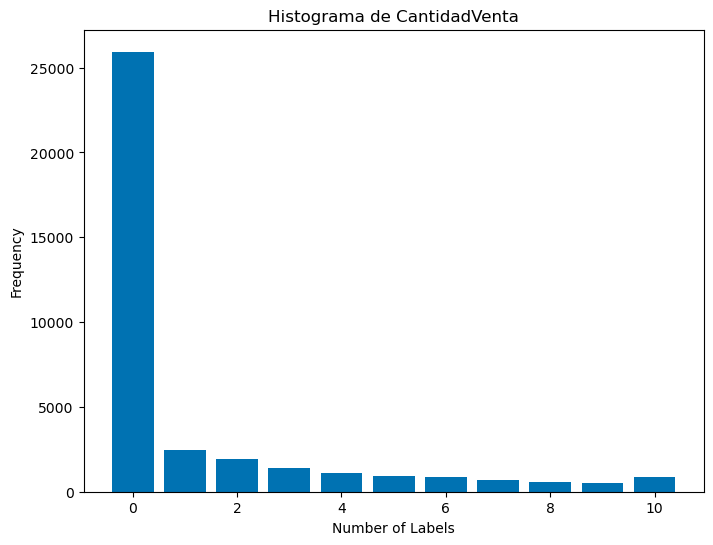

In [39]:
# Histogram
plt.figure(figsize=(8, 6))
plt.hist(y_train1, bins=range(12), align='left', rwidth=0.8)
plt.xlabel('Number of Labels')
plt.ylabel('Frequency')
plt.title('Histograma de CantidadVenta')
plt.show()

### Codificación

In [40]:
categorical_columns

Categoría Ciudad     Estado Tipo_x   Tipo_y  \
0                          AUTOMOTOR  Quito  Pichincha      D  Festivo   
1                   CUIDADO DEL BEBÉ  Quito  Pichincha      D  Festivo   
2                            BELLEZA  Quito  Pichincha      D  Festivo   
3                            BEBIDAS  Quito  Pichincha      D  Festivo   
4                             LIBROS  Quito  Pichincha      D  Festivo   
...                              ...    ...        ...    ...      ...   
86554                        AVÍCOLA  Quito  Pichincha      B  Festivo   
86555           ALIMENTOS PREPARADOS  Quito  Pichincha      B  Festivo   
86556      FRUTAS, VERDURAS Y GRANOS  Quito  Pichincha      B  Festivo   
86557  MATERIAL ESCOLAR Y DE OFICINA  Quito  Pichincha      B  Festivo   
86558                  COMIDA DE MAR  Quito  Pichincha      B  Festivo   

      Localidad   Ubicación              Descripcion Transferidoido  
0      Nacional     Ecuador                 Carnaval          FALSO  
1      Nacional     Ecuador                 Carnaval          FALSO  
2      Nacional     Ecuador                 Carnaval          FALSO  
3      Nacional     Ecuador                 Carnaval          FALSO  
4      Nacional     Ecuador                 Carnaval          FALSO  
...         ...         ...                      ...            ...  
86554     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  
86555     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  
86556     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  
86557     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  
86558     Local  Esmeraldas  Fundacion de Esmeraldas          FALSO  

[86559 rows x 9 columns]

In [41]:
categorical_columns.columns.tolist()

['Categoría',
 'Ciudad',
 'Estado',
 'Tipo_x',
 'Tipo_y',
 'Localidad',
 'Ubicación',
 'Descripcion',
 'Transferidoido']

In [42]:
# crear columnas [0-1] para variables categoricas
x_train1  = pd.get_dummies(x_train1, columns=categorical_columns.columns.tolist() ,drop_first=True)
x_test1 = pd.get_dummies(x_test1, columns=categorical_columns.columns.tolist() ,drop_first=True)
x_train1

CodigoVenta  AlmacenCodigo  EnPromocion  Grupo  Transacciones  \
68443       648253             48            0     14           4728   
62538       502032             45            0     11           3072   
38507       362600             32            0      3            688   
38100        73905             32            0      3            653   
74307       938841             50            0     14           2356   
...            ...            ...          ...    ...            ...   
21440       839708              2            0     13           1730   
73349       313364             50            0     14           2103   
50057       760184             38            0      4           1899   
5192        969485             11            0      6           2255   
77708       327752             54            0      3            620   

       PrecioBarrildePetroleo (En USD)  year  month  day  \
68443                        98.170000  2013     12   31   
62538                       101.630000  2013     10    9   
38507                       107.130000  2013      7   23   
38100                        97.010000  2013      2   11   
74307                       107.200000  2014      6   12   
...                                ...   ...    ...  ...   
21440                       101.163451  2014      4   18   
73349                        95.250000  2013      6   25   
50057                       103.640000  2014      3    4   
5192                        106.070000  2014      6   30   
77708                       101.920000  2013      7    3   

       Categoría_ALIMENTOS PREPARADOS  ...  Descripcion_Navidad-2  \
68443                               0  ...                      0   
62538                               0  ...                      0   
38507                               1  ...                      0   
38100                               0  ...                      0   
74307                               0  ...                      0   
...                               ...  ...                    ...   
21440                               0  ...                      0   
73349                               1  ...                      0   
50057                               1  ...                      0   
5192                                0  ...                      0   
77708                               1  ...                      0   

       Descripcion_Primer dia del ano  Descripcion_Primer dia del ano-1  \
68443                               0                                 1   
62538                               0                                 0   
38507                               0                                 0   
38100                               0                                 0   
74307                               0                                 0   
...                               ...                               ...   
21440                               0                                 0   
73349                               0                                 0   
50057                               0                                 0   
5192                                0                                 0   
77708                               0                                 0   

       Descripcion_Provincializacion Santa Elena  \
68443                                          0   
62538                                          0   
38507                                          0   
38100                                          0   
74307                                          0   
...                                          ...   
21440                                          0   
73349                                          0   
50057                                          0   
5192                                           0   
77708                                          0   

       Descripcion_Provincializacion de Cotopaxi  \
68443         

### Estandarización

In [43]:
numeric_columns

CantidadVenta  PrecioBarrildePetroleo (En USD)
0           0.000000                            97.01
1           0.000000                            97.01
2           0.000000                            97.01
3         172.000000                            97.01
4           0.000000                            97.01
...              ...                              ...
86554     595.542000                            97.34
86555     129.971000                            97.34
86556       0.000000                            97.34
86557       0.000000                            97.34
86558       9.535999                            97.34

[86559 rows x 2 columns]

In [44]:
integer_columns

CodigoVenta  AlmacenCodigo  EnPromocion  Grupo  Transacciones
0            73062              1            0     13            396
1            73063              1            0     13            396
2            73064              1            0     13            396
3            73065              1            0     13            396
4            73066              1            0     13            396
...            ...            ...          ...    ...            ...
86554      1035337              9            0      6           2319
86555      1035338              9            0      6           2319
86556      1035339              9            0      6           2319
86557      1035340              9            0      6           2319
86558      1035341              9            0      6           2319

[86559 rows x 5 columns]

In [45]:
num = x_train1[integer_columns.columns.tolist()]
num['PrecioBarrildePetroleo (En USD)'] = x_train1['PrecioBarrildePetroleo (En USD)']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [203]:
x_train1[num.columns]

CodigoVenta  AlmacenCodigo  EnPromocion  Grupo  Transacciones  \
68443       648253             48            0     14           4728   
62538       502032             45            0     11           3072   
38507       362600             32            0      3            688   
38100        73905             32            0      3            653   
74307       938841             50            0     14           2356   
...            ...            ...          ...    ...            ...   
21440       839708              2            0     13           1730   
73349       313364             50            0     14           2103   
50057       760184             38            0      4           1899   
5192        969485             11            0      6           2255   
77708       327752             54            0      3            620   

       PrecioBarrildePetroleo (En USD)  
68443                        98.170000  
62538                       101.630000  
38507                       107.130000  
38100                        97.010000  
74307                       107.200000  
...                                ...  
21440                       101.163451  
73349                        95.250000  
50057                       103.640000  
5192                        106.070000  
77708                       101.920000  

[69247 rows x 6 columns]

In [46]:
# crear escalador Estandar
# ajustar escalador con datos de entrenamiento
escalador = StandardScaler()

# ajustar escalador con DataFrame no-binario(float)
escalador.fit(x_train1[num.columns])

# estandarizar DataFrame de columnas 
x_train1[num.columns] = escalador.transform(x_train1[num.columns])
x_test1[num.columns] = escalador.transform(x_test1[num.columns])


In [47]:
x_train1

CodigoVenta  AlmacenCodigo  EnPromocion     Grupo  Transacciones  \
68443    -0.005024       1.346396    -0.084018  1.120190       3.043877   
62538    -0.500252       1.156462    -0.084018  0.491837       1.373690   
38507    -0.972487       0.333416    -0.084018 -1.183773      -1.030734   
38100    -1.950253       0.333416    -0.084018 -1.183773      -1.066034   
74307     0.979153       1.473018    -0.084018  1.120190       0.651556   
...            ...            ...          ...       ...            ...   
21440     0.643405      -1.565920    -0.084018  0.910739       0.020193   
73349    -1.139242       1.473018    -0.084018  1.120190       0.396388   
50057     0.374069       0.713284    -0.084018 -0.974321       0.190640   
5192      1.082940      -0.996119    -0.084018 -0.555419       0.549690   
77708    -1.090512       1.726263    -0.084018 -1.183773      -1.099317   

       PrecioBarrildePetroleo (En USD)  year  month  day  \
68443                        -0.626367  2013     12   31   
62538                         0.098173  2013     10    9   
38507                         1.249899  2013      7   23   
38100                        -0.869277  2013      2   11   
74307                         1.264557  2014      6   12   
...                                ...   ...    ...  ...   
21440                         0.000475  2014      4   18   
73349                        -1.237829  2013      6   25   
50057                         0.519076  2014      3    4   
5192                          1.027930  2014      6   30   
77708                         0.158900  2013      7    3   

       Categoría_ALIMENTOS PREPARADOS  ...  Descripcion_Navidad-2  \
68443                               0  ...                      0   
62538                               0  ...                      0   
38507                               1  ...                      0   
38100                               0  ...                      0   
74307                               0  ...                      0   
...                               ...  ...                    ...   
21440                               0  ...                      0   
73349                               1  ...                      0   
50057                               1  ...                      0   
5192                                0  ...                      0   
77708                               1  ...                      0   

       Descripcion_Primer dia del ano  Descripcion_Primer dia del ano-1  \
68443                               0                                 1   
62538                               0                                 0   
38507                               0                                 0   
38100                               0                                 0   
74307                               0                                 0   
...                               ...                               ...   
21440                               0                                 0   
73349                               0                                 0   
50057                               0                                 0   
5192                                0                                 0   
77708                               0                                 0   

       Descripcion_Provincializacion Santa Elena  \
68443                                          0   
62538                                          0   
38507                                          0   
38100                                          0   
74307                                          0   
...                                          ...   
21440                                          0   
73349                                          0   
50057                                          0   
5192                                           0   
77708                                          0   

       Descripcion_Provinciali

In [48]:
x_test1 

CodigoVenta  AlmacenCodigo  EnPromocion     Grupo  Transacciones  \
30044     0.620127       0.016860    -0.084018 -1.602675      -0.395337   
25883    -0.333694      -0.109762    -0.084018 -1.602675      -1.033760   
84900    -1.470309      -1.122742    -0.084018 -0.555419       0.983374   
72654     1.057522      -1.375986     0.119828 -0.974321      -0.342892   
27670    -0.514626      -0.046451    -0.084018  0.282386      -1.092257   
...            ...            ...          ...       ...            ...   
24148    -1.486512      -0.173073    -0.084018 -1.602675       0.654581   
42430    -0.489448       0.460039    -0.084018 -0.555419       0.760481   
49694    -0.332068       0.713284    -0.084018 -0.974321      -0.017124   
23482     1.042172      -0.236385    -0.084018  0.072935      -0.672693   
66075    -0.964731       1.283084    -0.084018  1.120190       1.558257   

       PrecioBarrildePetroleo (En USD)  year  month  day  \
30044                         0.604932  2014      4   14   
25883                        -1.344625  2013     11    6   
84900                        -2.182244  2013      5    1   
72654                         1.231052  2014      6   25   
27670                         0.399716  2013     10    7   
...                                ...   ...    ...  ...   
24148                        -1.480738  2013      4   29   
42430                         0.211251  2013     10   11   
49694                        -1.344625  2013     11    6   
23482                         1.187077  2014      6   23   
66075                         0.889723  2013      7   24   

       Categoría_ALIMENTOS PREPARADOS  ...  Descripcion_Navidad-2  \
30044                               0  ...                      0   
25883                               0  ...                      0   
84900                               0  ...                      0   
72654                               0  ...                      0   
27670                               0  ...                      0   
...                               ...  ...                    ...   
24148                               0  ...                      0   
42430                               0  ...                      0   
49694                               1  ...                      0   
23482                               0  ...                      0   
66075                               0  ...                      0   

       Descripcion_Primer dia del ano  Descripcion_Primer dia del ano-1  \
30044                               0                                 0   
25883                               0                                 0   
84900                               0                                 0   
72654                               0                                 0   
27670                               0                                 0   
...                               ...                               ...   
24148                               0                                 0   
42430                               0                                 0   
49694                               0                                 0   
23482                               0                                 0   
66075                               0                                 0   

       Descripcion_Provincializacion Santa Elena  \
30044                                          0   
25883                                          0   
84900                                          0   
72654                                          0   
27670                                          0   
...                                          ...   
24148                                          0   
42430                                          0   
49694                                          0   
23482                                          0   
66075                                          0   

       Descripcion_Provinciali

### Guardar bases de datos preprocesadas

In [49]:
# guardar bases de datos
# datos de entrenamiento
x_train1.to_csv('data/x_train1preprocess.csv', index=False)
y_train1.to_csv('data/y_train1preprocess.csv', index=False)

# datos de prueba
x_test1.to_csv('data/x_test1preprocess.csv', index=False)
y_test1.to_csv('data/y_test1preprocess.csv', index=False)



### Exploracion inicial

In [24]:
entrenamiento.describe()

CodigoVenta  AlmacenCodigo  CantidadVenta   EnPromocion
count  1.048575e+06   1.048575e+06   1.048575e+06  1.048575e+06
mean   5.242870e+05   2.749256e+01   2.445326e+02  1.147634e-01
std    3.026977e+05   1.558408e+01   8.065892e+02  2.377814e+00
min    0.000000e+00   1.000000e+00   0.000000e+00  0.000000e+00
25%    2.621435e+05   1.400000e+01   0.000000e+00  0.000000e+00
50%    5.242870e+05   2.700000e+01   1.000000e+00  0.000000e+00
75%    7.864305e+05   4.100000e+01   1.200000e+02  0.000000e+00
max    1.048574e+06   5.400000e+01   4.627100e+04  1.960000e+02

In [26]:
entrenamiento.info

<bound method DataFrame.info of          CodigoVenta       Fecha  AlmacenCodigo  \
0                  0  01/01/2013              1   
1                  1  01/01/2013              1   
2                  2  01/01/2013              1   
3                  3  01/01/2013              1   
4                  4  01/01/2013              1   
...              ...         ...            ...   
1048570      1048570  13/08/2014              3   
1048571      1048571  13/08/2014              3   
1048572      1048572  13/08/2014              3   
1048573      1048573  13/08/2014              3   
1048574      1048574  13/08/2014              3   

                             Categoría  CantidadVenta  EnPromocion  
0                            AUTOMOTOR          0.000            0  
1                     CUIDADO DEL BEBÉ          0.000            0  
2                              BELLEZA          0.000            0  
3                              BEBIDAS          0.000            0  
4         

## EDA

In [113]:
# cargar datos de entrenamiento 
x_train1 = pd.read_csv('data/x_train1preprocess.csv')
y_train1 = pd.read_csv('data/y_train1preprocess.csv')

# cargar datos de prueba
x_test1 = pd.read_csv('data/x_test1preprocess.csv')
y_test1 = pd.read_csv('data/y_test1preprocess.csv')

In [114]:
# crear base de datos de entrenamiento full
full_train1 = x_train1.copy()
full_train1['y_target'] = y_train1
full_train1

CodigoVenta       Fecha  AlmacenCodigo  EnPromocion     Grupo  \
0        -0.005024  31/12/2013       1.346396    -0.084018  1.120190   
1        -0.500252  09/10/2013       1.156462    -0.084018  0.491837   
2        -0.972487  23/07/2013       0.333416    -0.084018 -1.183773   
3        -1.950253  11/02/2013       0.333416    -0.084018 -1.183773   
4         0.979153  12/06/2014       1.473018    -0.084018  1.120190   
...            ...         ...            ...          ...       ...   
69242     0.643405  18/04/2014      -1.565920    -0.084018  0.910739   
69243    -1.139242  25/06/2013       1.473018    -0.084018  1.120190   
69244     0.374069  04/03/2014       0.713284    -0.084018 -0.974321   
69245     1.082940  30/06/2014      -0.996119    -0.084018 -0.555419   
69246    -1.090512  03/07/2013       1.726263    -0.084018 -1.183773   

       Transacciones  PrecioBarrildePetroleo (En USD)  \
0           3.043877                        -0.626367   
1           1.373690                         0.098173   
2          -1.030734                         1.249899   
3          -1.066034                        -0.869277   
4           0.651556                         1.264557   
...              ...                              ...   
69242       0.020193                         0.000475   
69243       0.396388                        -1.237829   
69244       0.190640                         0.519076   
69245       0.549690                         1.027930   
69246      -1.099317                         0.158900   

       Categoría_ALIMENTOS PREPARADOS  Categoría_ATENCIÓN EN EL HOGAR  \
0                                   0                               0   
1                                   0                               0   
2                                   1                               0   
3                                   0                               1   
4                                   0                               0   
...                               ...                             ...   
69242                               0                               0   
69243                               1                               0   
69244                               1                               0   
69245                               0                               0   
69246                               1                               0   

       Categoría_AUTOMOTOR  ...  Descripcion_Primer dia del ano  \
0                        0  ...                               0   
1                        0  ...                               0   
2                        0  ...                               0   
3                        0  ...                               0   
4                        0  ...                               0   
...                    ...  ...                             ...   
69242                    0  ...                               0   
69243                    0  ...                               0   
69244                    0  ...                               0   
69245                    0  ...                               0   
69246                    0  ...                               0   

       Descripcion_Primer dia del ano-1  \
0                                     1   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
69242                                 0   
69243                                 0   
69244                                 0   
69245                                 0   
69246                                 0   

       Descripcion_Provincializacion Santa Elena  \
0                                              0   
1                                              0   
2                                              0   
3                                              0  

### Análisis Descriptivo

In [115]:
full_train1.describe()

CodigoVenta  AlmacenCodigo   EnPromocion         Grupo  Transacciones  \
count  6.924700e+04   6.924700e+04  6.924700e+04  6.924700e+04   6.924700e+04   
mean  -1.590453e-17   3.078297e-18  1.011734e-16 -1.346755e-17  -6.259204e-18   
std    1.000007e+00   1.000007e+00  1.000007e+00  1.000007e+00   1.000007e+00   
min   -2.198658e+00  -1.629231e+00 -8.401770e-02 -1.602675e+00  -1.325236e+00   
25%   -9.627853e-01  -9.328079e-01 -8.401770e-02 -9.743214e-01  -6.797530e-01   
50%   -3.989482e-02   1.686025e-02 -8.401770e-02  7.293451e-02  -3.025489e-01   
75%    1.054187e+00   8.399060e-01 -8.401770e-02  9.107392e-01   4.609364e-01   
max    1.305984e+00   1.726263e+00  3.905445e+01  1.748544e+00   6.602101e+00   

       PrecioBarrildePetroleo (En USD)  Categoría_ALIMENTOS PREPARADOS  \
count                     6.924700e+04                    69247.000000   
mean                      1.251841e-17                        0.030471   
std                       1.000007e+00                        0.171880   
min                      -2.182244e+00                        0.000000   
25%                      -8.001732e-01                        0.000000   
50%                       1.589003e-01                        0.000000   
75%                       8.897226e-01                        0.000000   
max                       1.421610e+00                        1.000000   

       Categoría_ATENCIÓN EN EL HOGAR  Categoría_AUTOMOTOR  Categoría_AVÍCOLA  \
count                    69247.000000         69247.000000       69247.000000   
mean                         0.030124             0.029821           0.030629   
std                          0.170930             0.170094           0.172313   
min                          0.000000             0.000000           0.000000   
25%                          0.000000             0.000000           0.000000   
50%                          0.000000             0.000000           0.000000   
75%                          0.000000             0.000000           0.000000   
max                          1.000000             1.000000           1.000000   

       ...  Descripcion_Primer dia del ano  Descripcion_Primer dia del ano-1  \
count  ...                    69247.000000                      69247.000000   
mean   ...                        0.001025                          0.017849   
std    ...                        0.032004                          0.132404   
min    ...                        0.000000                          0.000000   
25%    ...                        0.000000                          0.000000   
50%    ...                        0.000000                          0.000000   
75%    ...                        0.000000                          0.000000   
max    ...                        1.000000                          1.000000   

       Descripcion_Provincializacion Santa Elena  \
count                               69247.000000   
mean                                    0.017806   
std                                     0.132246   
min                                     0.000000   
25%                                     0.000000   
50%                                     0.000000   
75%                                     0.000000   
max                                     1.000000   

       Descripcion_Provincializacion de Cotopaxi  \
count                               69247.000000   
mean                                    0.035366   
std                                     0.184705   
min                                     0.000000   
25%                                     0.000000   
50%                                     0.000000   
75%                                     0.000000   
max                                     1.000000   

       Descripcion_Provincializacion de Imbabura  \
count                               69247.000000   
mean                                    0.035597   
std                                     0.185285   
min           

In [116]:
full_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69247 entries, 0 to 69246
Columns: 142 entries, CodigoVenta to y_target
dtypes: float64(7), int64(134), object(1)
memory usage: 75.0+ MB


In [117]:
# proporcion por clase 
full_train1.value_counts()

CodigoVenta  Fecha       AlmacenCodigo  EnPromocion  Grupo      Transacciones  PrecioBarrildePetroleo (En USD)  Categoría_ALIMENTOS PREPARADOS  Categoría_ATENCIÓN EN EL HOGAR  Categoría_AUTOMOTOR  Categoría_AVÍCOLA  Categoría_BEBIDAS  Categoría_BELLEZA  Categoría_CARNES  Categoría_CELEBRACIÓN  Categoría_COMESTIBLES I   Categoría_COMESTIBLES I I  Categoría_COMIDA DE MAR  Categoría_CUIDADO DEL BEBÉ  Categoría_CUIDADO PERSONAL  Categoría_CÉSPED Y JARDÍN  Categoría_ELECTRODOMÉSTICOS  Categoría_ELECTRÓNICA  Categoría_FIAMBRES  Categoría_FRUTAS, VERDURAS Y GRANOS  Categoría_HARDWARE  Categoría_HOGAR Y COCINA I  Categoría_HOGAR Y COCINA II  Categoría_HUEVOS  Categoría_LENCERÍA  Categoría_LIBROS  Categoría_LICOR,VINO,CERVEZA  Categoría_LIMPIEZA  Categoría_LÁCTEOS  Categoría_MATERIAL ESCOLAR Y DE OFICINA  Categoría_PAN/PANADERÍA  Categoría_REVISTAS  Categoría_ROPA FEMENINA  Categoría_SUMINISTROS PARA MASCOTAS  Ciudad_Babahoyo  Ciudad_Cayambe  Ciudad_Cuenca  Ciudad_Daule  Ciudad_El Carmen  Ciuda

### Técnicas de Correlación

In [119]:
pearson_corr = full_train1.corr(method='pearson')
pearson_corr

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


CodigoVenta  AlmacenCodigo  \
CodigoVenta                                         1.000000       0.017558   
AlmacenCodigo                                       0.017558       1.000000   
EnPromocion                                         0.094868       0.000850   
Grupo                                               0.019308      -0.090860   
Transacciones                                       0.003411       0.149543   
...                                                      ...            ...   
Descripcion_Provincializacion de Santo Domingo     -0.045225      -0.000050   
Descripcion_Traslado Independencia de Guayaquil    -0.066132      -0.003387   
Descripcion_Viernes Santo                          -0.079309      -0.004753   
Transferidoido_VERDADERO                           -0.067650      -0.004270   
y_target                                            0.040861       0.047335   

                                                 EnPromocion     Grupo  \
CodigoVenta                                         0.094868  0.019308   
AlmacenCodigo                                       0.000850 -0.090860   
EnPromocion                                         1.000000 -0.000770   
Grupo                                              -0.000770  1.000000   
Transacciones                                       0.007551  0.203902   
...                                                      ...       ...   
Descripcion_Provincializacion de Santo Domingo     -0.011424 -0.004039   
Descripcion_Traslado Independencia de Guayaquil    -0.011350 -0.002231   
Descripcion_Viernes Santo                          -0.015714 -0.001597   
Transferidoido_VERDADERO                           -0.011331 -0.004915   
y_target                                            0.153832  0.038988   

                                                 Transacciones  \
CodigoVenta                                           0.003411   
AlmacenCodigo                                         0.149543   
EnPromocion                                           0.007551   
Grupo                                                 0.203902   
Transacciones                                         1.000000   
...                                                        ...   
Descripcion_Provincializacion de Santo Domingo       -0.011298   
Descripcion_Traslado Independencia de Guayaquil       0.000066   
Descripcion_Viernes Santo                            -0.010622   
Transferidoido_VERDADERO                             -0.019506   
y_target                                              0.199870   

                                                 PrecioBarrildePetroleo (En USD)  \
CodigoVenta                                                             0.570613   
AlmacenCodigo                                                           0.011389   
EnPromocion                                                             0.053829   
Grupo                                                                   0.017531   
Transacciones                                                          -0.051369   
...                                                                          ...   
Descripcion_Provincializacion de Santo Domingo                         -0.182830   
Descripcion_Traslado Independencia de Guayaquil                         0.028537   
Descripcion_Viernes Santo                                              -0.141308   
Transferidoido_VERDADERO                                                0.013240   
y_target                                                                0.010930   

                                                 Categoría_ALIMENTOS PREPARADOS  \
CodigoVenta                                                            0.000921   
AlmacenCodigo                                                         -0.002054   
EnPromocion                                                           -0.012822   
Grupo                                                                 -0.0000

In [120]:
# crear matriz de correlación entre variables numericas en base de datos 
corr_matrix =full_train1.corr()
corr_matrix

# correlación con variable  y-target
corr_matrix["y_target"].sort_values(ascending=False)[:30]

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


y_target                                                  1.000000
Categoría_COMESTIBLES I                                   0.654889
Categoría_BEBIDAS                                         0.257909
Transacciones                                             0.199870
EnPromocion                                               0.153832
Categoría_LIMPIEZA                                        0.149371
Estado_Pichincha                                          0.117806
Ciudad_Quito                                              0.111111
Categoría_LÁCTEOS                                         0.063812
AlmacenCodigo                                             0.047335
CodigoVenta                                               0.040861
Grupo                                                     0.038988
Descripcion_Navidad-2                                     0.038395
Localidad_Nacional                                        0.033055
Ubicación_Ecuador                                         0.03

In [122]:
# correlación con variable  y-target
corr_y_target = corr_matrix["y_target"].sort_values(ascending=False)[:20]
corr_y_target = pd.DataFrame(corr_y_target)
corr_y_target.to_csv('data/corr_matriz.csv', index=False)
corr_y_target.reset_index(names='vars_corr', inplace=True) #  inplace=True modifica el objeto(variable)

# extraer variables con correlacion lineal > 0.1
vars_corr_list = corr_y_target['vars_corr'].tolist()
vars_corr_list

corr_y_target
corr_y_target.to_excel("data/corr.xlsx") 

In [123]:
vars_corr_list

['y_target',
 'Categoría_COMESTIBLES I ',
 'Categoría_BEBIDAS',
 'Transacciones',
 'EnPromocion',
 'Categoría_LIMPIEZA',
 'Estado_Pichincha',
 'Ciudad_Quito',
 'Categoría_LÁCTEOS',
 'AlmacenCodigo',
 'CodigoVenta',
 'Grupo',
 'Descripcion_Navidad-2',
 'Localidad_Nacional',
 'Ubicación_Ecuador',
 'Categoría_FRUTAS, VERDURAS Y GRANOS',
 'Ciudad_Cayambe',
 'Categoría_PAN/PANADERÍA',
 'Descripcion_Mundial de futbol Brasil: Octavos de Final',
 'Descripcion_Navidad-1']

In [125]:
sns.pairplot(full_train1[vars_corr_list[:10]], diag_kind="hist", kind='scatter', hue='y_target', palette=['blue','red','yellow','green','purple'])


The palette list has fewer values (5) than needed (12567) and will cycle, which may produce an uninterpretable plot.

The palette list has fewer values (5) than needed (12567) and will cycle, which may produce an uninterpretable plot.

The palette list has fewer values (5) than needed (12567) and will cycle, which may produce an uninterpretable plot.


In [ ]:
# Calculate the covariance matrix
covariance_matrix = full_train1.cov()

# Plot the covariance matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Covariance Matrix')

# Show the plot
plt.show()

In [ ]:
# Calculate the covariance matrix
covariance_matrix = full_train1[vars_corr_list].cov()

# Plot the covariance matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Covariance Matrix')

# Show the plot
plt.show()

In [ ]:
# Plot the covariance matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(full_train1.corr(method='pearson'), annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Heatmap: Correlación de Pearson (Lineal)')

# Show the plot
plt.show()

In [ ]:
corr_matrix_top = full_train1[vars_corr_list].corr()

# Plot the covariance matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix_top, annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Heatmap: Correlación de Pearson (Lineal)')

# Show the plot
plt.show()

In [ ]:
# Plot matriz de dispersion entre variables numéricas
scatter_matrix(full_train1[vars_corr_list], figsize=(12, 8))

# Hide x and y labels for each individual axis
for ax in plt.gcf().axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    
plt.show()

### Análisis de Distribución

In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

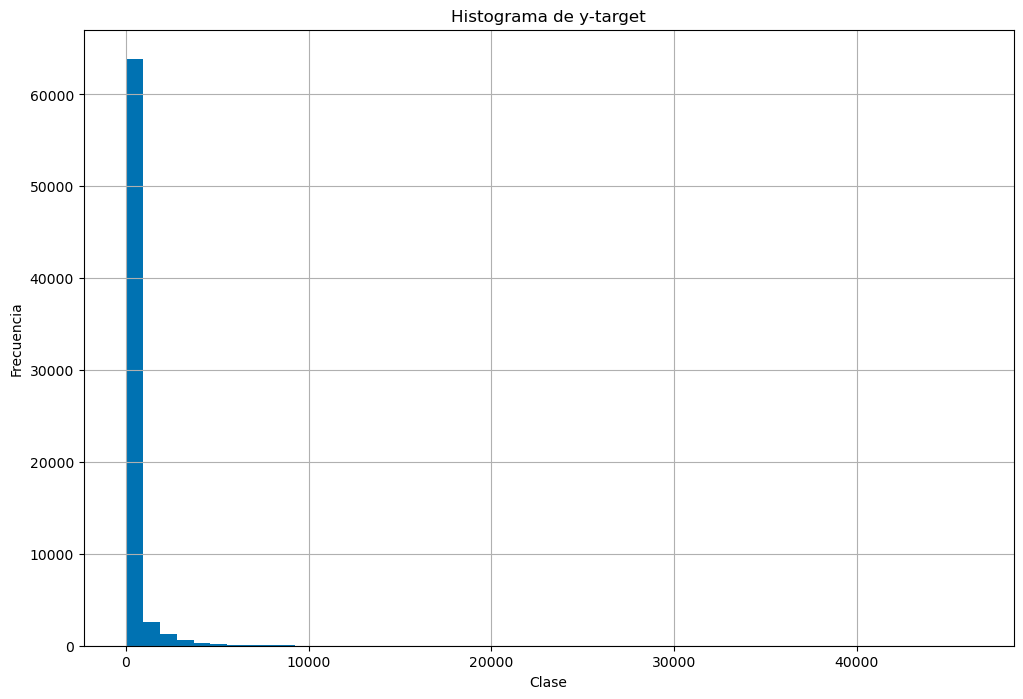

In [82]:
# Plot hisogramas de distrubucion de variables numéricas en base de datos
y_train1.hist(bins=50, figsize=(12, 8))
plt.title(f'Histograma de y-target') 
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Create a figure for each variable
for var in vars_corr_list:
    plt.figure(figsize=(10, 6))
    full_train1[var].hist(bins=50)
    plt.title(f'Histograma de {var}') 
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()

## Machine Learning

In [83]:
y_train1

CantidadVenta
0              0.000
1           2331.000
2             14.000
3              0.000
4            640.540
...              ...
69242          0.000
69243        109.776
69244        124.904
69245         33.000
69246         21.000

[69247 rows x 1 columns]

In [50]:
# cargar datos de entrenamiento 
x_train1 = pd.read_csv('data/x_train1preprocess.csv')
y_train1 = pd.read_csv('data/y_train1preprocess.csv')

# cargar datos de prueba
x_test1 = pd.read_csv('data/x_test1preprocess.csv')
y_test1 = pd.read_csv('data/y_test1preprocess.csv')


### Sintonización

In [214]:
# Sintonización de Hiperparámetros

# crear modelos de ML
lr = LinearRegression(n_jobs=-1)
rf = RandomForestRegressor(n_jobs=-1, max_features = 3, verbose = 3, random_state=1)
ada = AdaBoostRegressor(random_state=1)
extra = ExtraTreesRegressor(n_jobs=-1, random_state=1, verbose=3)
boost = GradientBoostingRegressor(random_state=1, verbose=3)
knn = KNeighborsRegressor(n_jobs=-1)
xgb = XGBRegressor(objective='reg:squarederror', device='gpu', n_jobs=-1, random_state=1, verbose=3)
svr = SVR(verbose=1)

# grillas de hiper parámetros
params_lr = {'fit_intercept':[True, False]}
grid_lr = GridSearchCV(lr, param_grid=params_lr, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose = 3)

params_rf = {'n_estimators':[50,100,200,300], 'max_depth': [3,5,7], 'min_samples_split': [350,500,600] , 'min_samples_leaf': [50,100,200] } 
grid_rf = GridSearchCV(rf, param_grid=params_rf, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose = 3)

params_ada = {'n_estimators':[50,100,200,300], 'learning_rate':[0.01,0.1,1] } 
grid_ada = GridSearchCV(ada, param_grid=params_ada, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose = 3)

params_extra = {'n_estimators':[50,100,200,300], 'max_depth': [3,5,7], 'min_samples_split': [350,500,600] }
grid_extra = GridSearchCV(extra, param_grid=params_extra, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose = 3)

params_boost = {'n_estimators':[50,100,200,300], 'learning_rate':[0.01,0.1,1], 'max_depth': [3,5,7], 'min_samples_split': [350,500,600] }
grid_boost = GridSearchCV(boost, param_grid=params_boost, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose = 3)

params_knn = {'n_neighbors':[5,10,15], 'algorithm':['auto','ball_tree','kd_tree']}
grid_knn = GridSearchCV(knn, param_grid=params_knn, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose = 3)

params_xgb = {'n_estimators':[50,100,200,300], 'learning_rate':[0.01,0.1,1], 'max_depth': [3,5,7], 'min_samples_split': [350,500,600] }
grid_xgb = GridSearchCV(xgb, param_grid=params_xgb, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, verbose = 3)


grid_xgb


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='gpu',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=1, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'min_samples_split': [350, 500, 600],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=3)

### Entrenamiento

#### Linear Regression

In [210]:
grid_lr.fit(x_train1, y_train1)
joblib.dump(grid_lr, 'data/modelos/sistecredito/LinearRegression.pkl')   

Fitting 5 folds for each of 2 candidates, totalling 10 fits


['data/modelos/sistecredito/LinearRegression.pkl']

#### Random Forest

In [211]:
grid_rf.fit(x_train1, y_train1)
joblib.dump(grid_rf, 'data/modelos/sistecredito/RandomForest.pkl')   

Fitting 5 folds for each of 108 candidates, totalling 540 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


['data/modelos/sistecredito/RandomForest.pkl']

#### AdaBoostRegressor

In [212]:
grid_ada.fit(x_train1, y_train1)
joblib.dump(grid_ada, 'data/modelos/sistecredito/AdaBoost.pkl')  

Fitting 5 folds for each of 12 candidates, totalling 60 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


['data/modelos/sistecredito/AdaBoost.pkl']

#### Extra Trees

In [215]:
grid_extra.fit(x_train1, y_train1)
joblib.dump(grid_extra, 'data/modelos/sistecredito/ExtraTrees.pkl')  

Fitting 5 folds for each of 36 candidates, totalling 180 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 300building tree 2 of 300
building tree 3 of 300

building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.0s


building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.9s


building tree 125 of 300
building tree 126 of 300
building tree 127 of 300
building tree 128 of 300
building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   38.0s


building tree 285 of 300
building tree 286 of 300
building tree 287 of 300
building tree 288 of 300
building tree 289 of 300
building tree 290 of 300
building tree 291 of 300
building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300
building tree 298 of 300
building tree 299 of 300
building tree 300 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   40.6s finished


['data/modelos/sistecredito/ExtraTrees.pkl']

#### Gradient Boosting

In [216]:
grid_boost.fit(x_train1, y_train1)
joblib.dump(grid_boost, 'data/modelos/sistecredito/GradientBoosting.pkl') 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


      Iter       Train Loss   Remaining Time 
         1      626853.1698            2.62m
         2      536039.9377            2.48m
         3      462403.8215            2.44m
         4      402552.4239            2.41m
         5      352044.9827            2.38m
         6      312150.4696            2.37m
         7      279262.5871            2.37m
         8      252123.4049            2.36m
         9      229910.6402            2.35m
        10      212082.3870            2.35m
        11      194636.6894            2.33m
        12      181915.2328            2.32m
        13      171485.5689            2.31m
        14      162648.2488            2.30m
        15      155130.9502            2.31m
        16      146893.3511            2.30m
        17      138522.3112            2.29m
        18      133684.3644            2.28m
        19      126657.6287            2.27m
        20      122627.7034            2.26m
        21      117064.2168            2.25m
        2

['data/modelos/sistecredito/GradientBoosting.pkl']

#### KNN Regressor

In [217]:
grid_knn.fit(x_train1, y_train1)
joblib.dump(grid_knn, 'data/modelos/sistecredito/KNN.pkl') 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


['data/modelos/sistecredito/KNN.pkl']

#### XGBoost Regressor

In [218]:
grid_xgb.fit(x_train1, y_train1)
joblib.dump(grid_xgb, 'data/modelos/sistecredito/XGBoostRegressor.pkl') 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[21:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
[21:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_split", "verbose" } are not used.



['data/modelos/sistecredito/XGBoostRegressor.pkl']

#### SVR

In [ ]:
#grid_svr.fit(x_train1, y_train1)
#joblib.dump(grid_svr, 'data/modelos/sistecredito/XGBoostRegressor.pkl') 

### Selección de Modelo

In [51]:
# cargar modelos sintonizados
grid_lr = joblib.load('data/modelos/sistecredito/LinearRegression.pkl')
grid_rf = joblib.load('data/modelos/sistecredito/RandomForest.pkl')
grid_ada = joblib.load('data/modelos/sistecredito/AdaBoost.pkl')
grid_extra = joblib.load('data/modelos/sistecredito/ExtraTrees.pkl')
grid_boost = joblib.load('data/modelos/sistecredito/GradientBoosting.pkl')
grid_knn = joblib.load('data/modelos/sistecredito/KNN.pkl')
grid_xgb = joblib.load('data/modelos/sistecredito/XGBoostRegressor.pkl')


In [52]:
# extraer mejores modelos de GridSearch
lr_op = grid_lr.best_estimator_
rf_op = grid_rf.best_estimator_
ada_op = grid_ada.best_estimator_
extra_op = grid_extra.best_estimator_
boost_op = grid_boost.best_estimator_
knn_op = grid_knn.best_estimator_
xgb_op = grid_xgb.best_estimator_


In [53]:
# crear listas de clasificadores
classifier_names = []

# crear listas de métricas de evaluación Regresión

classifier_r2 = []

classifier_mae = []
classifier_mse = []
classifier_mape = []
classifier_medae = []

classifier_expl_var = []


In [54]:
classifiers = [('Linear Regression', lr_op),
               ('Random Forest', rf_op),
               ('Ada Boost', ada_op),
               ('Extra Trees', extra_op), 
                                
    ('Gradient Boosting', boost_op),
    ('KNN', knn_op),
    ('XGBoost', xgb_op),
      ] 
             
# agregar nombres de clasificadores a lista
for classifier in classifiers:
    classifier_names.append(classifier[0])

In [55]:
x_train1 

CodigoVenta  AlmacenCodigo  EnPromocion     Grupo  Transacciones  \
0        -0.005024       1.346396    -0.084018  1.120190       3.043877   
1        -0.500252       1.156462    -0.084018  0.491837       1.373690   
2        -0.972487       0.333416    -0.084018 -1.183773      -1.030734   
3        -1.950253       0.333416    -0.084018 -1.183773      -1.066034   
4         0.979153       1.473018    -0.084018  1.120190       0.651556   
...            ...            ...          ...       ...            ...   
69242     0.643405      -1.565920    -0.084018  0.910739       0.020193   
69243    -1.139242       1.473018    -0.084018  1.120190       0.396388   
69244     0.374069       0.713284    -0.084018 -0.974321       0.190640   
69245     1.082940      -0.996119    -0.084018 -0.555419       0.549690   
69246    -1.090512       1.726263    -0.084018 -1.183773      -1.099317   

       PrecioBarrildePetroleo (En USD)  year  month  day  \
0                            -0.626367  2013     12   31   
1                             0.098173  2013     10    9   
2                             1.249899  2013      7   23   
3                            -0.869277  2013      2   11   
4                             1.264557  2014      6   12   
...                                ...   ...    ...  ...   
69242                         0.000475  2014      4   18   
69243                        -1.237829  2013      6   25   
69244                         0.519076  2014      3    4   
69245                         1.027930  2014      6   30   
69246                         0.158900  2013      7    3   

       Categoría_ALIMENTOS PREPARADOS  ...  Descripcion_Navidad-2  \
0                                   0  ...                      0   
1                                   0  ...                      0   
2                                   1  ...                      0   
3                                   0  ...                      0   
4                                   0  ...                      0   
...                               ...  ...                    ...   
69242                               0  ...                      0   
69243                               1  ...                      0   
69244                               1  ...                      0   
69245                               0  ...                      0   
69246                               1  ...                      0   

       Descripcion_Primer dia del ano  Descripcion_Primer dia del ano-1  \
0                                   0                                 1   
1                                   0                                 0   
2                                   0                                 0   
3                                   0                                 0   
4                                   0                                 0   
...                               ...                               ...   
69242                               0                                 0   
69243                               0                                 0   
69244                               0                                 0   
69245                               0                                 0   
69246                               0                                 0   

       Descripcion_Provincializacion Santa Elena  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
69242                                          0   
69243                                          0   
69244                                          0   
69245                                          0   
69246                                          0   

       Descripcion_Provinciali

In [56]:
x_test1

CodigoVenta  AlmacenCodigo  EnPromocion     Grupo  Transacciones  \
0         0.620127       0.016860    -0.084018 -1.602675      -0.395337   
1        -0.333694      -0.109762    -0.084018 -1.602675      -1.033760   
2        -1.470309      -1.122742    -0.084018 -0.555419       0.983374   
3         1.057522      -1.375986     0.119828 -0.974321      -0.342892   
4        -0.514626      -0.046451    -0.084018  0.282386      -1.092257   
...            ...            ...          ...       ...            ...   
17307    -1.486512      -0.173073    -0.084018 -1.602675       0.654581   
17308    -0.489448       0.460039    -0.084018 -0.555419       0.760481   
17309    -0.332068       0.713284    -0.084018 -0.974321      -0.017124   
17310     1.042172      -0.236385    -0.084018  0.072935      -0.672693   
17311    -0.964731       1.283084    -0.084018  1.120190       1.558257   

       PrecioBarrildePetroleo (En USD)  year  month  day  \
0                             0.604932  2014      4   14   
1                            -1.344625  2013     11    6   
2                            -2.182244  2013      5    1   
3                             1.231052  2014      6   25   
4                             0.399716  2013     10    7   
...                                ...   ...    ...  ...   
17307                        -1.480738  2013      4   29   
17308                         0.211251  2013     10   11   
17309                        -1.344625  2013     11    6   
17310                         1.187077  2014      6   23   
17311                         0.889723  2013      7   24   

       Categoría_ALIMENTOS PREPARADOS  ...  Descripcion_Navidad-2  \
0                                   0  ...                      0   
1                                   0  ...                      0   
2                                   0  ...                      0   
3                                   0  ...                      0   
4                                   0  ...                      0   
...                               ...  ...                    ...   
17307                               0  ...                      0   
17308                               0  ...                      0   
17309                               1  ...                      0   
17310                               0  ...                      0   
17311                               0  ...                      0   

       Descripcion_Primer dia del ano  Descripcion_Primer dia del ano-1  \
0                                   0                                 0   
1                                   0                                 0   
2                                   0                                 0   
3                                   0                                 0   
4                                   0                                 0   
...                               ...                               ...   
17307                               0                                 0   
17308                               0                                 0   
17309                               0                                 0   
17310                               0                                 0   
17311                               0                                 0   

       Descripcion_Provincializacion Santa Elena  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
17307                                          0   
17308                                          0   
17309                                          0   
17310                                          0   
17311                                          0   

       Descripcion_Provinciali

#### Métricas de Regresión

In [57]:
for classifier_name, classifier in classifiers:

    # ajustar modelo sintonizado con datos de entrenamiento
    classifier.fit(x_train1, y_train1)    
    
    # crear y_predict vector de predicciones
    y_predict = classifier.predict(x_test1)


    # calcular métricas de evaluación para regresión
    r2 =  r2_score(y_test1,y_predict)
    mae = mean_absolute_error(y_test1,y_predict)
    mse = mean_squared_error(y_test1,y_predict)
    mape = mean_absolute_percentage_error(y_test1,y_predict)
    medae = median_absolute_error(y_test1,y_predict)
    var = explained_variance_score(y_test1,y_predict)
    
    # agregar métricas a listas 
    classifier_r2.append(r2)
    classifier_mae.append(mae)
    classifier_mse.append(mse)
    classifier_mape.append(mape)
    classifier_medae.append(medae)
    classifier_expl_var.append(var)
    



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s


building tree 1 of 50building tree 2 of 50
building tree 3 of 50

building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 300building tree 2 of 300

building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300building tree 54 of 300

building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.7s


building tree 125 of 300
building tree 126 of 300
building tree 127 of 300
building tree 128 of 300
building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.7s


building tree 285 of 300
building tree 286 of 300
building tree 287 of 300
building tree 288 of 300
building tree 289 of 300
building tree 290 of 300
building tree 291 of 300
building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300
building tree 298 of 300
building tree 299 of 300
building tree 300 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   39.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


      Iter       Train Loss   Remaining Time 
         1      626853.1698            7.59m
         2      536039.9377            5.48m
         3      462403.8215            4.48m
         4      402552.4239            4.02m
         5      352044.9827            3.98m
         6      312150.4696            3.96m
         7      279262.5871            3.83m
         8      252123.4049            3.64m
         9      229910.6402            3.50m
        10      212082.3870            3.39m
        11      194636.6894            3.30m
        12      181915.2328            3.20m
        13      171485.5689            3.19m
        14      162648.2488            3.12m
        15      155130.9502            3.07m
        16      146893.3511            3.01m
        17      138522.3112            2.98m
        18      133684.3644            2.94m
        19      126657.6287            2.92m
        20      122627.7034            2.89m
        21      117064.2168            2.86m
        2

[13:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
[13:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_split", "verbose" } are not used.



#### Gráficas

##### R2

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


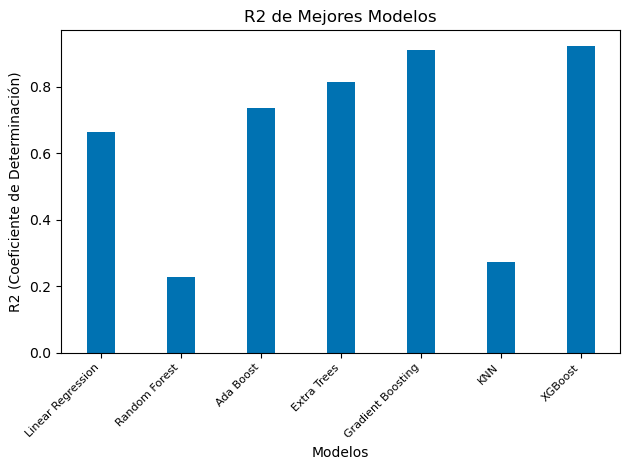

[0.6625541991578894,
 0.22688706561963112,
 0.7348729731933654,
 0.8134185743891976,
 0.9102461582777235,
 0.27259142911321554,
 0.9230729570652854]

In [59]:
# R2

# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_r2, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('R2 (Coeficiente de Determinación)')
ax.set_title('R2 de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


classifier_r2

##### MAE

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


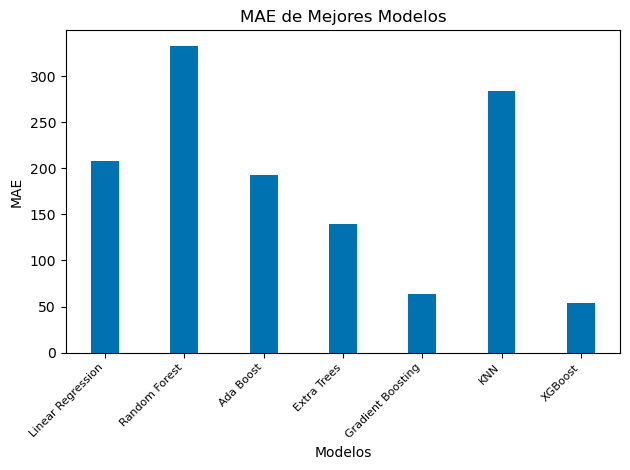

[207.75418382604803,
 333.1296592497752,
 192.9864400263066,
 139.82258704994274,
 63.774277621284476,
 284.4675000210848,
 54.337754382074166]

In [60]:
# MAE

# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_mae, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('MAE')
ax.set_title('MAE de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


classifier_mae

##### MSE

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


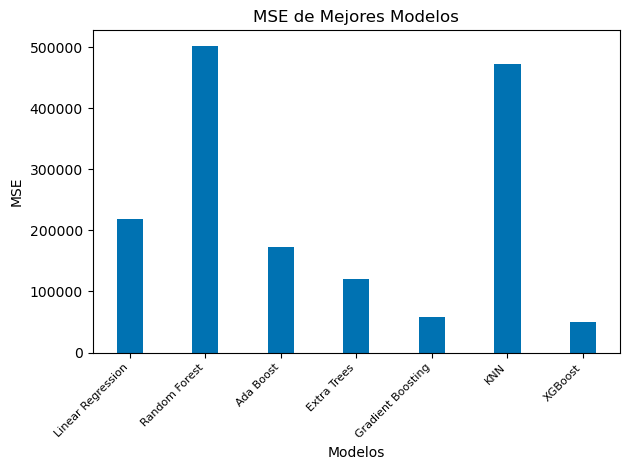

[219252.321973513,
 502323.05628827045,
 172263.8601524251,
 121229.5743500378,
 58316.73754583152,
 472627.0642347835,
 49982.64237961]

In [61]:
# MSE
# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_mse, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('MSE')
ax.set_title('MSE de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


classifier_mse

##### MAPE

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


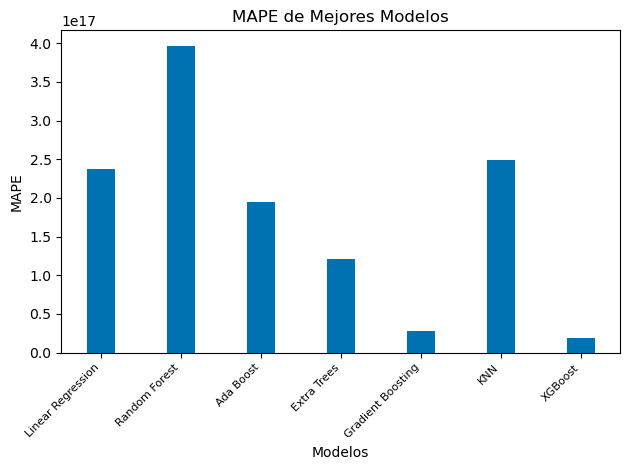

[2.3691576561269398e+17,
 3.96881811560765e+17,
 1.946327142074238e+17,
 1.2074490740718782e+17,
 2.7679004503660904e+16,
 2.4967763893368995e+17,
 1.9241305057046052e+16]

In [62]:
# MAPE
# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_mape, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('MAPE')
ax.set_title('MAPE de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


classifier_mape

##### MedAE

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


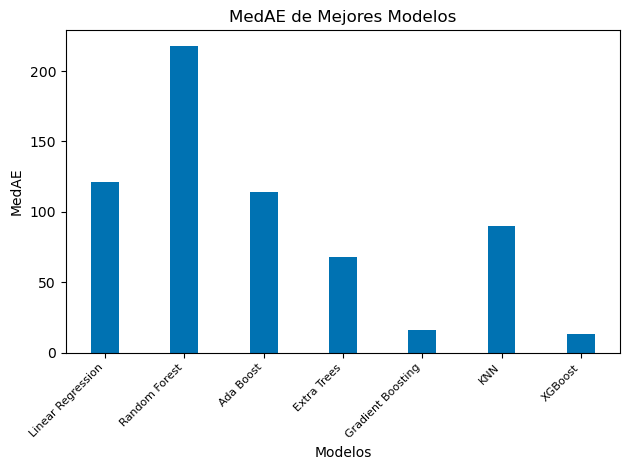

[120.92792282789173,
 218.06181273249786,
 114.45237864579154,
 67.97578117695468,
 16.12050715834657,
 89.5863,
 13.419421672821045]

In [63]:
# MedAE
# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_medae, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('MedAE')
ax.set_title('MedAE de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


classifier_medae

##### Varianza Explicada

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


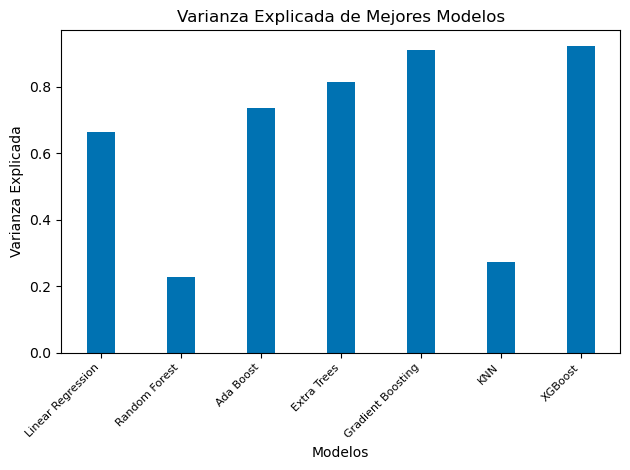

[0.6625778026215519,
 0.22700681518202603,
 0.7349252374052717,
 0.8134379850147494,
 0.9102462888456432,
 0.2732295298747991,
 0.9230736750748144]

In [64]:
# Varianza Explicada
# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_expl_var, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('Varianza Explicada')
ax.set_title('Varianza Explicada de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


classifier_expl_var

In [65]:
# guardar mejor modelo
joblib.dump(xgb_op, 'data/modelos/sistecredito/modelo_top.pkl')  

['data/modelos/sistecredito/modelo_top.pkl']

### Evaluación final

In [ ]:
# cargar datos de entrenamiento 
x_train1 = pd.read_csv('data/x_train1preprocess.csv')
y_train1 = pd.read_csv('data/y_train1preprocess.csv')

# cargar datos de prueba
x_test1 = pd.read_csv('data/x_test1preprocess.csv')
y_test1 = pd.read_csv('data/y_test1preprocess.csv')


In [67]:
# mejor modelo escogido para la evaluación final
modelo_top = joblib.load('data/modelos/sistecredito/modelo_top.pkl')

# predicciones de modelo top con x_test1 
y_predict = modelo_top.predict(x_test1) 


# mostrar metricas de evaluacion clasificación multi-clase
print('R2: ', r2_score(y_test1,y_predict))
print('MAE: ', mean_absolute_error(y_test1,y_predict))
print('MSE: ', mean_squared_error(y_test1,y_predict))
print('MAPE: ', mean_absolute_percentage_error(y_test1,y_predict))
print('MedAE: ', median_absolute_error(y_test1,y_predict))
print('Varianza Explicada: ', explained_variance_score(y_test1,y_predict))


R2:  0.9230729570652854
MAE:  54.337754382074166
MSE:  49982.64237961
MAPE:  1.9241305057046052e+16
MedAE:  13.419421672821045
Varianza Explicada:  0.9230736750748144


In [68]:
print('Parámetros del mejor modelo sintonizado: ')
modelo_top.get_params

Parámetros del mejor modelo sintonizado: 


<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, min_samples_split=350, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)>

#### Predicciones

In [71]:
# predicciones a partir de datos de prueba
y_predict_op =  modelo_top.predict(x_test1)
y_predict

array([  8.557892 ,   6.14463  , 592.8511   , ...,  96.59106  ,
         2.2274694, 486.4108   ], dtype=float32)

### Interpretación de modelo

#### SHAP

In [72]:
shap.initjs() # inicializar shap javascript .js
# crear Explicador
explainer = shap.Explainer(modelo_top)

# calcular valores de shap basados en arboles
shap_values_tree= shap.TreeExplainer(modelo_top).shap_values(x_test1)

[13:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[13:25:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


##### Summary Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


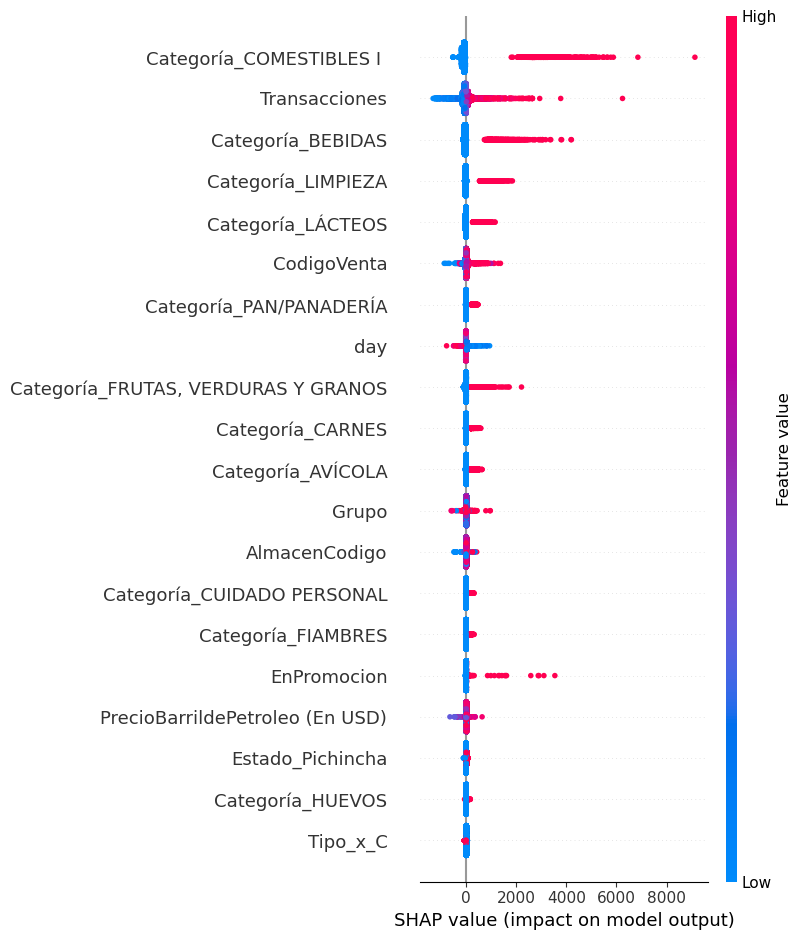

In [78]:
# Plot summary plot
# importancia de caracteristicas (feature importance)
shap.summary_plot(shap_values_tree, x_test1)


##### Interaction Values

In [74]:
# calcular shap interaction values
shap_interaction_values = shap.TreeExplainer(modelo_top).shap_interaction_values(x_test1.iloc[:500,:])

[13:26:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


##### Dependece Plot

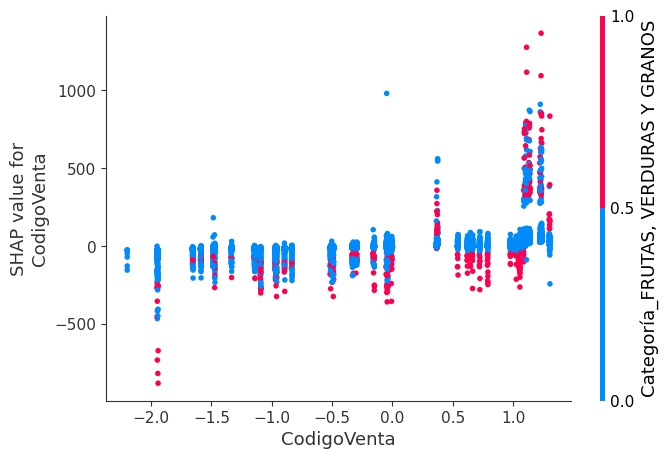

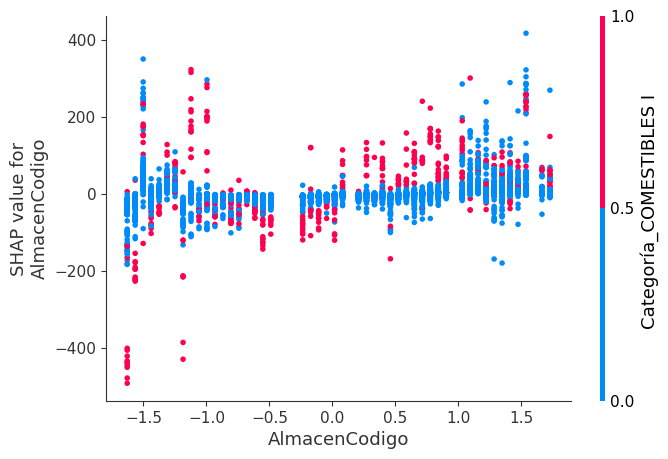

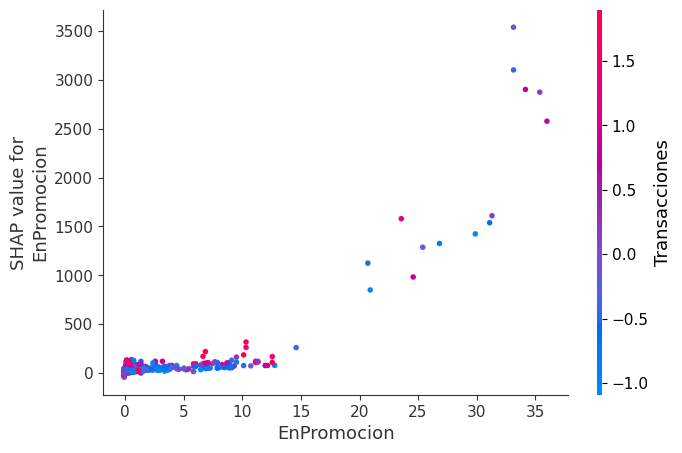

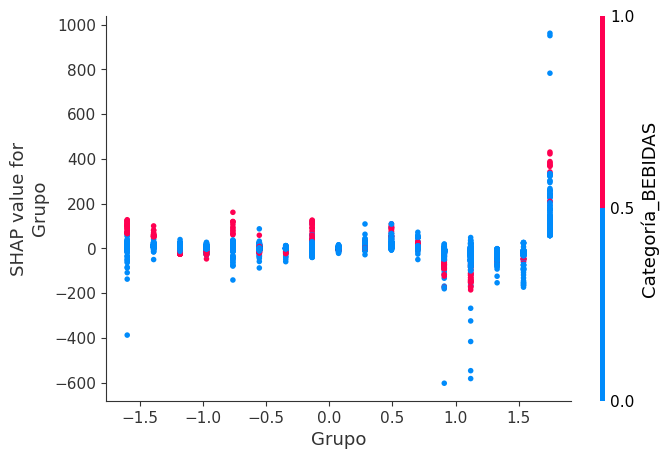

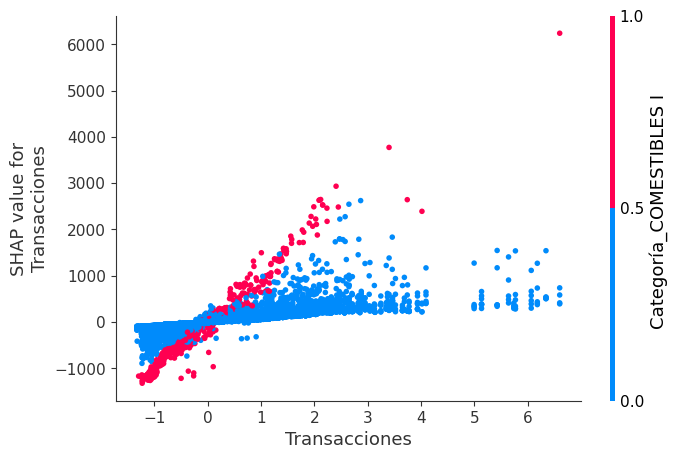

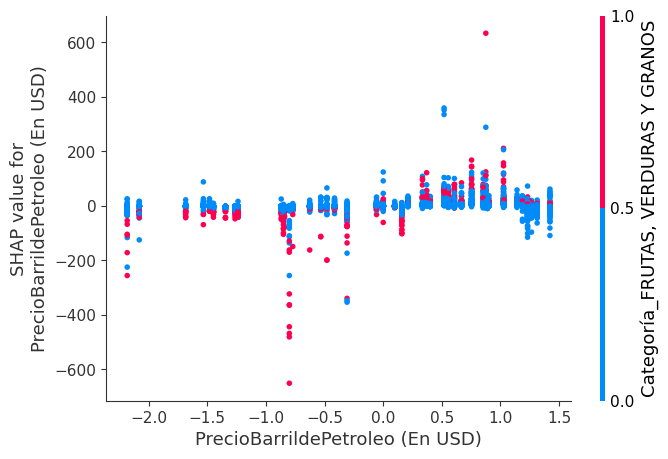

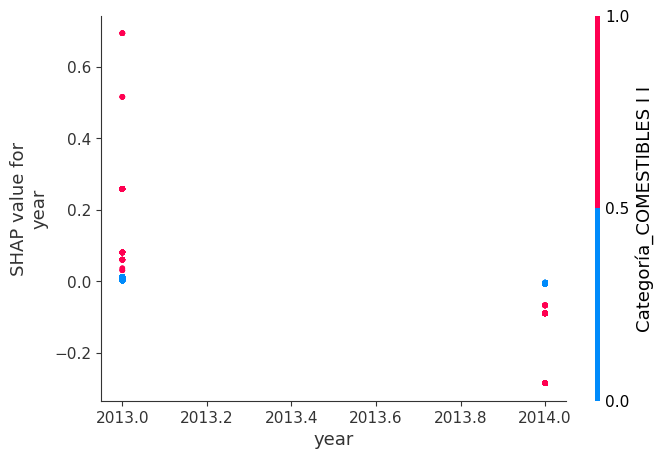

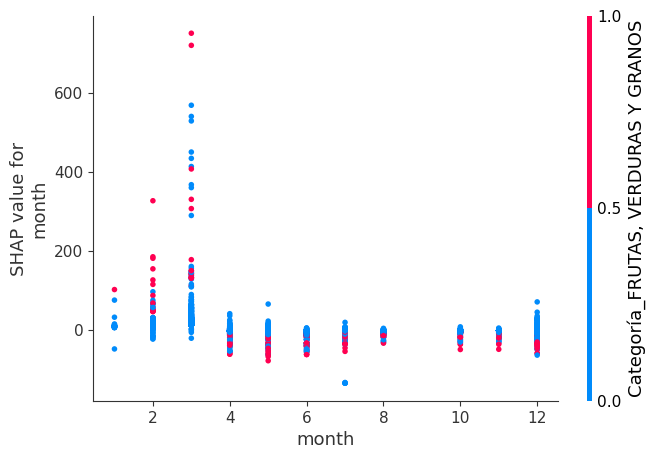

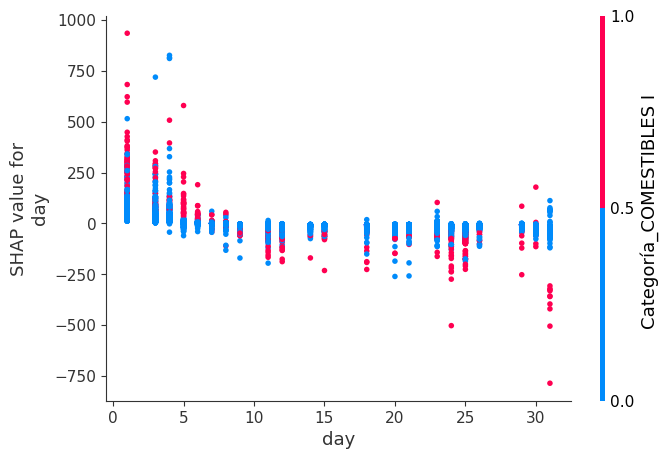

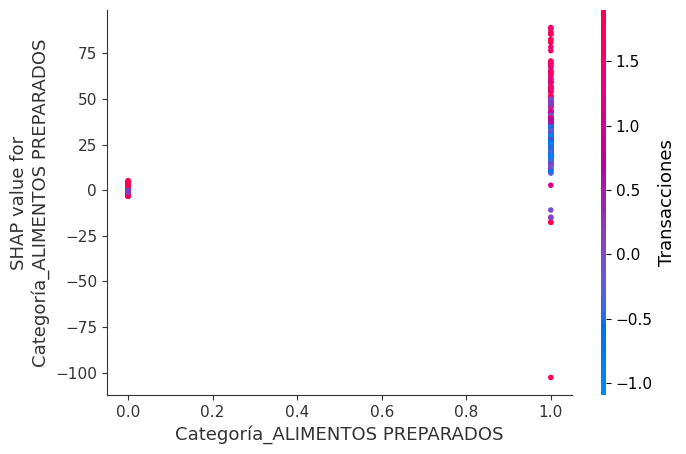

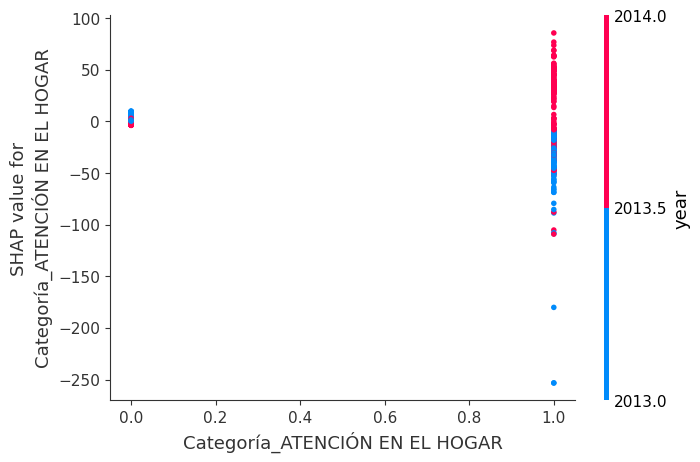

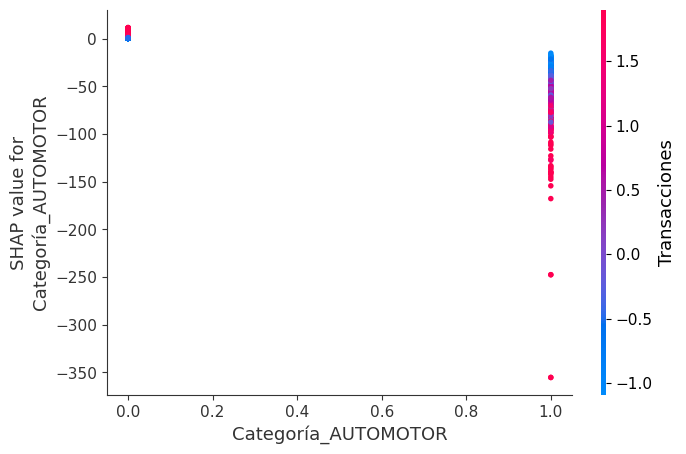

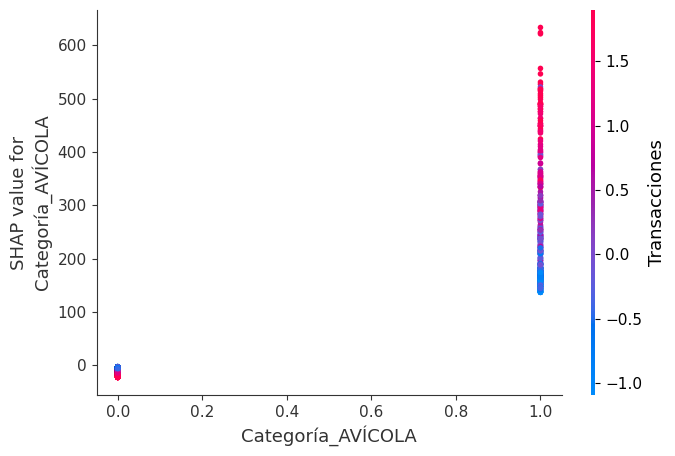

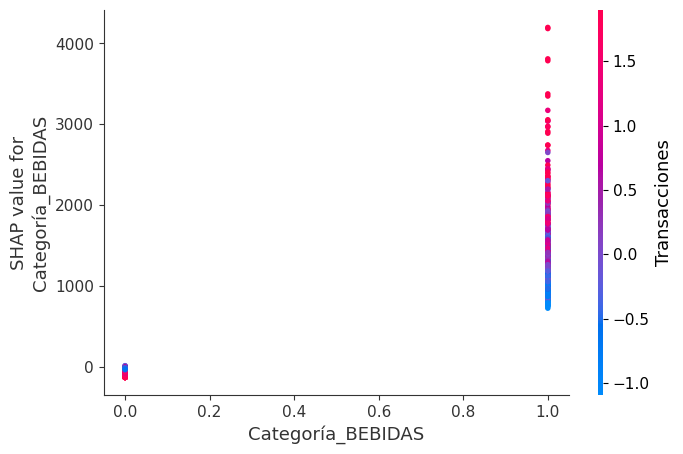

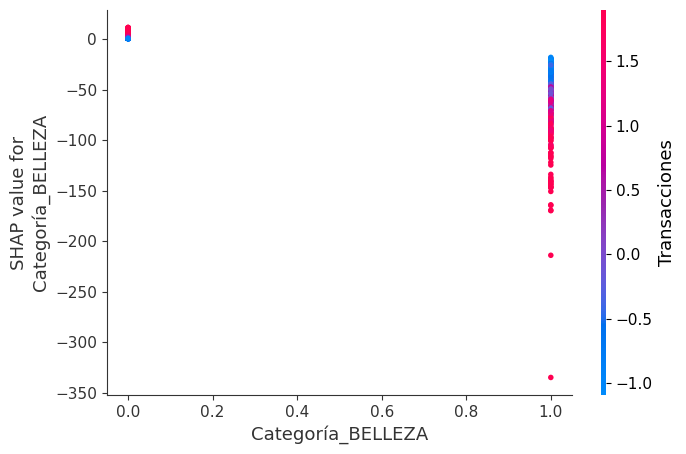

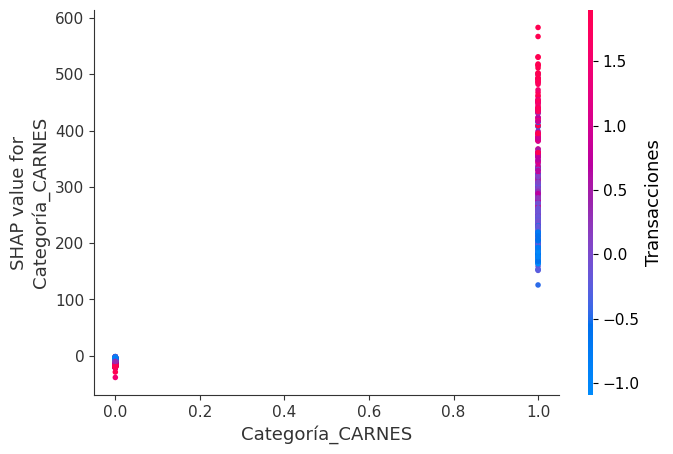

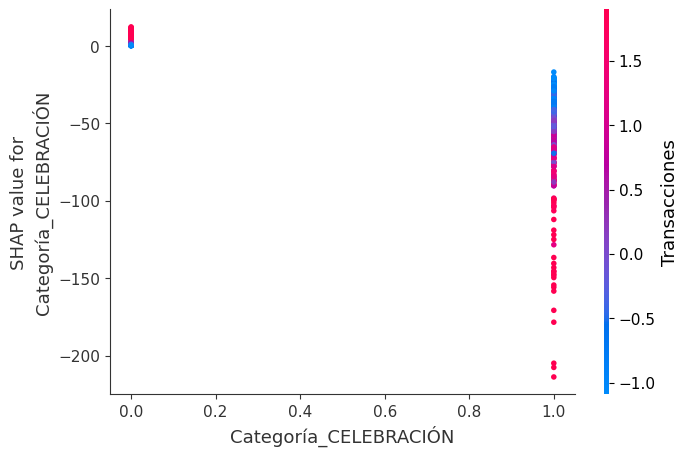

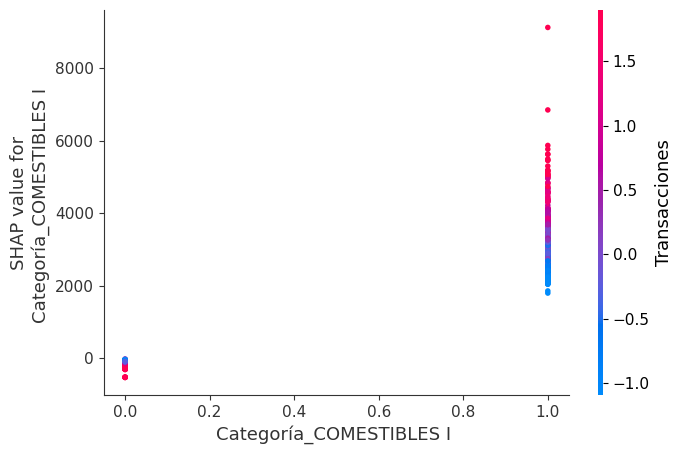

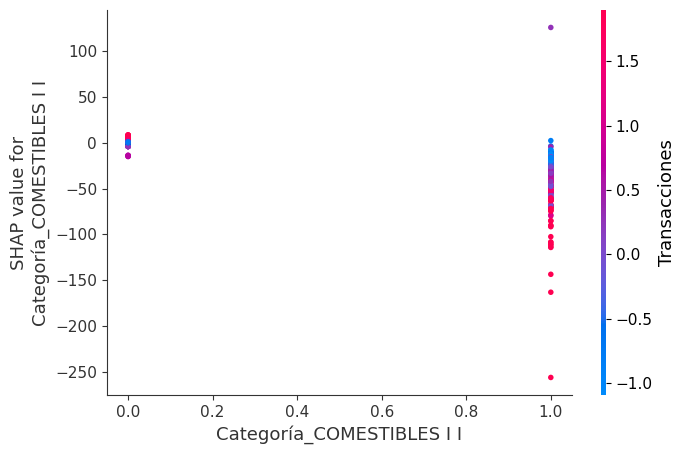

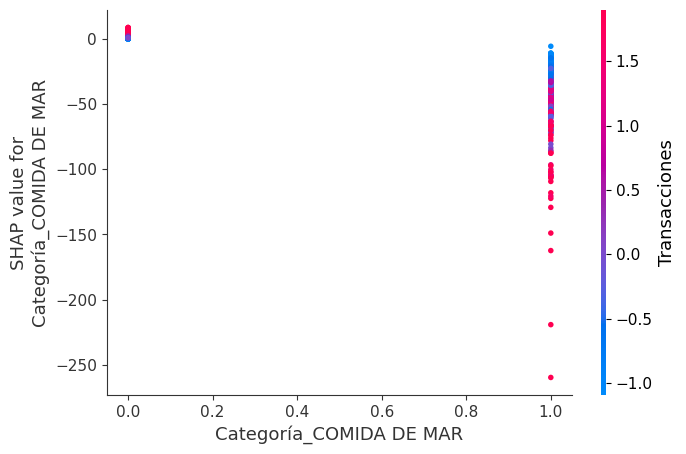

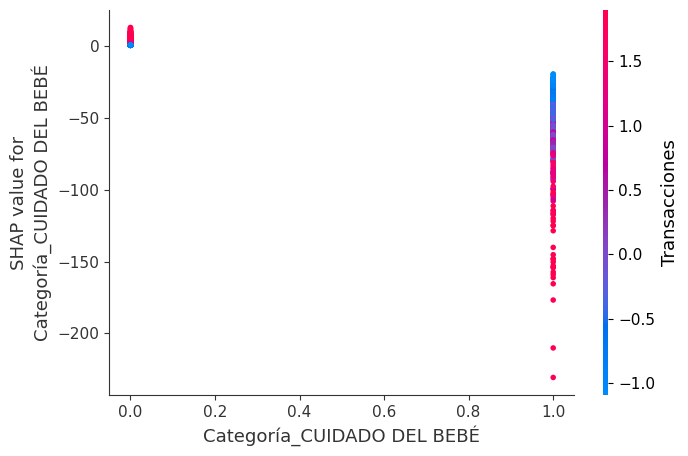

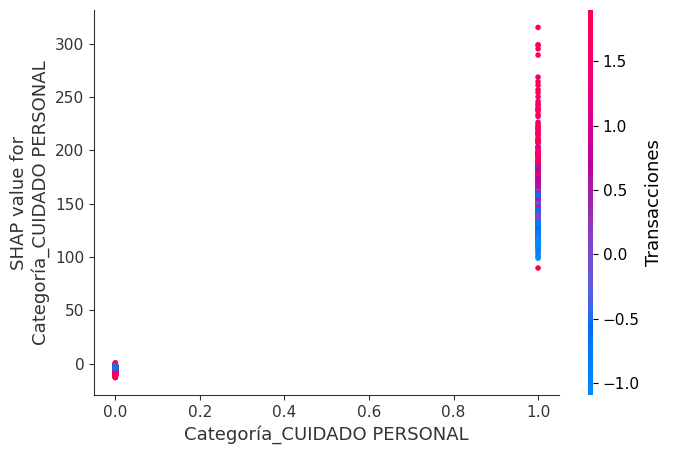

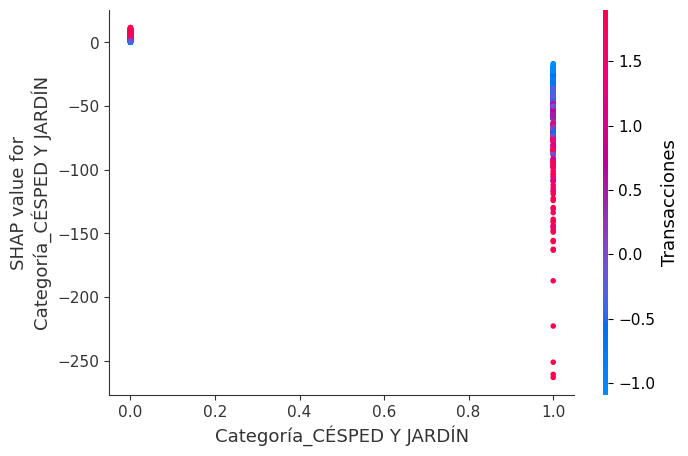

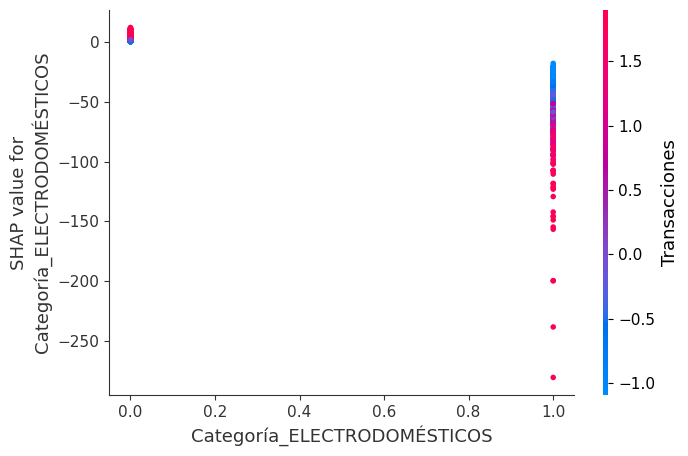

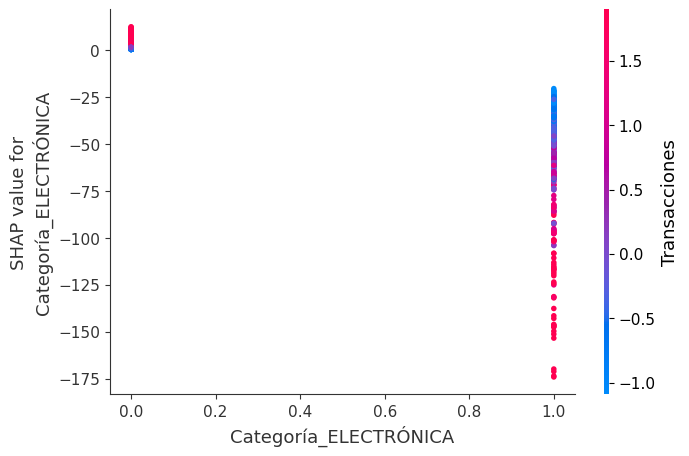

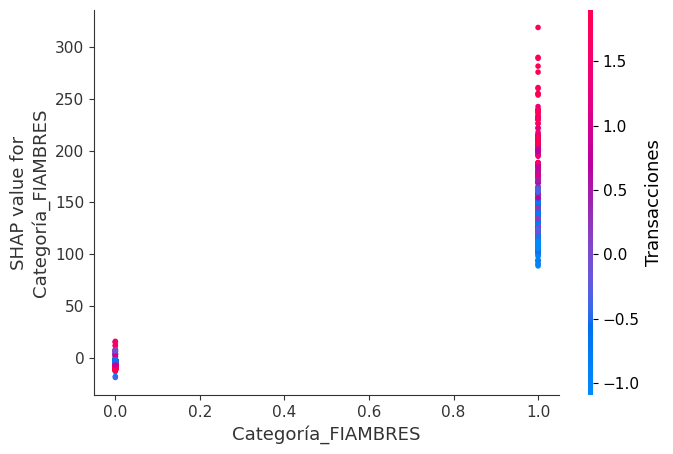

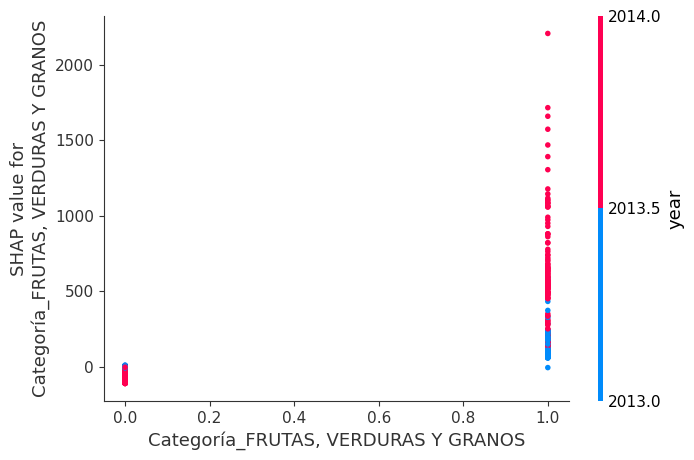

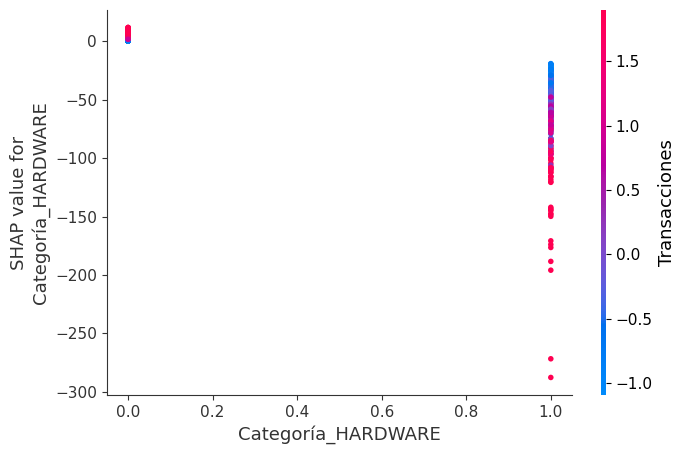

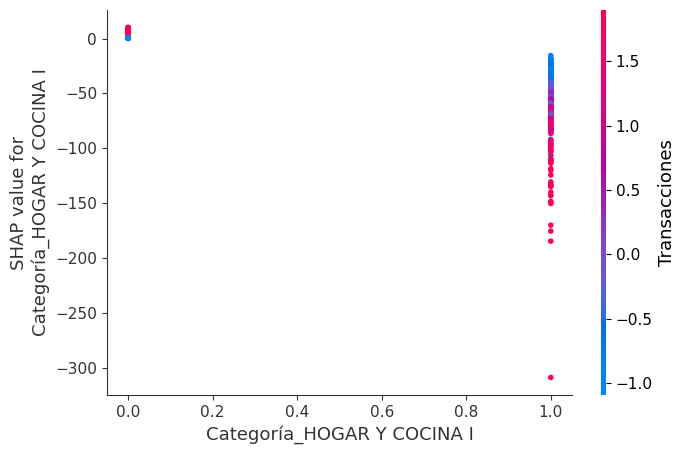

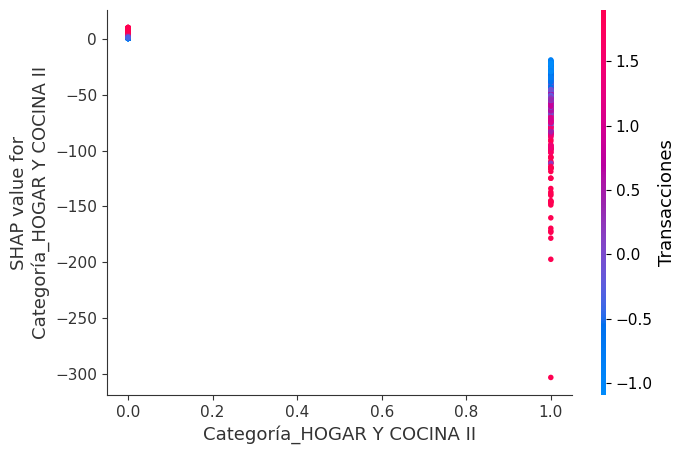

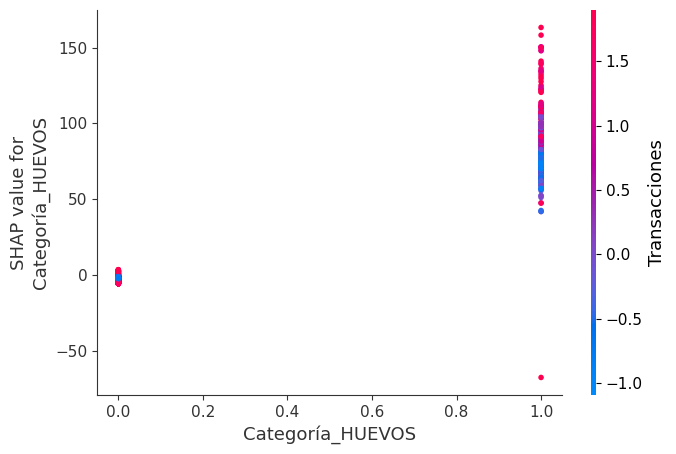

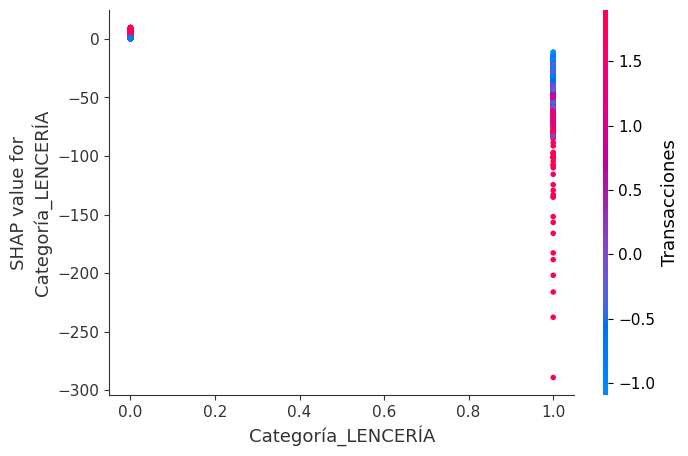

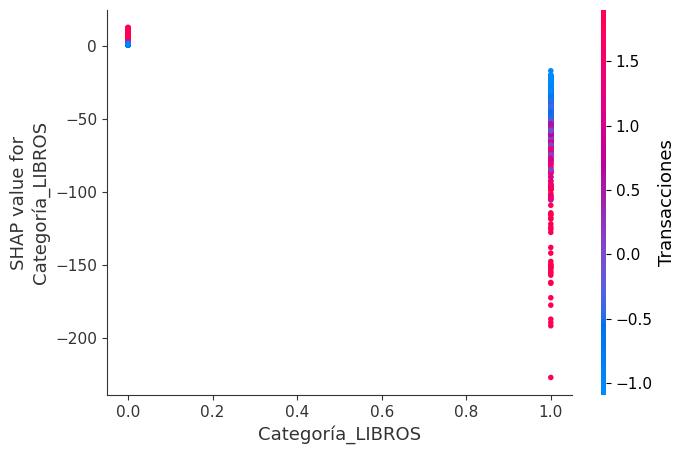

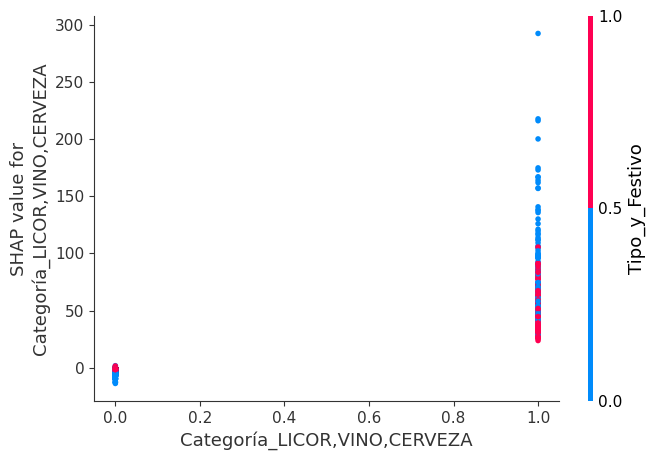

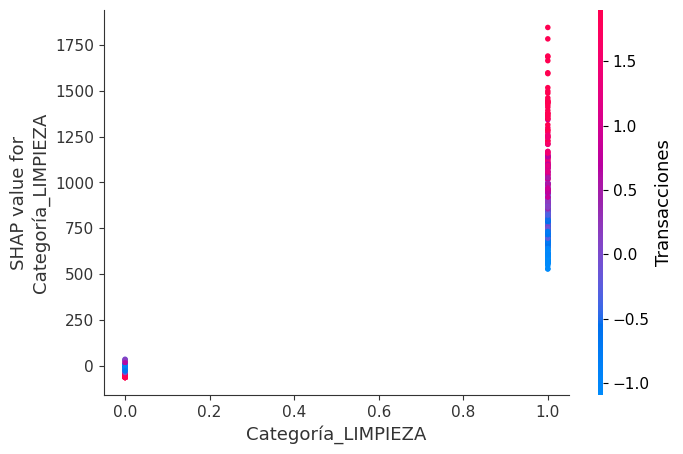

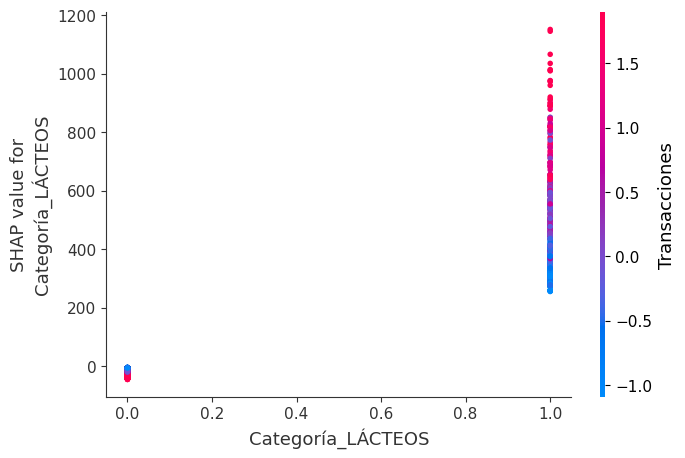

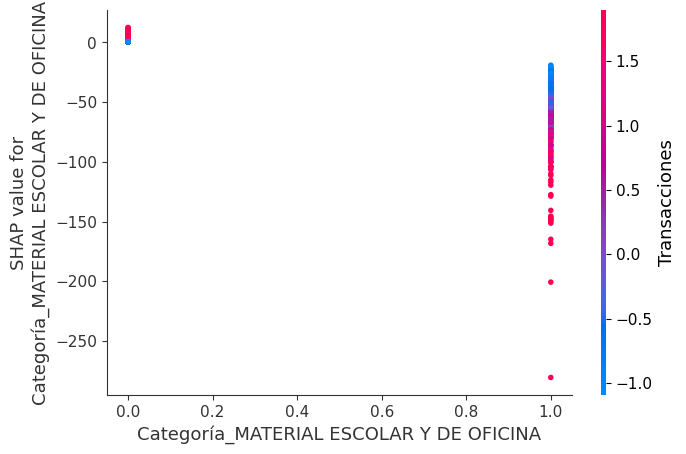

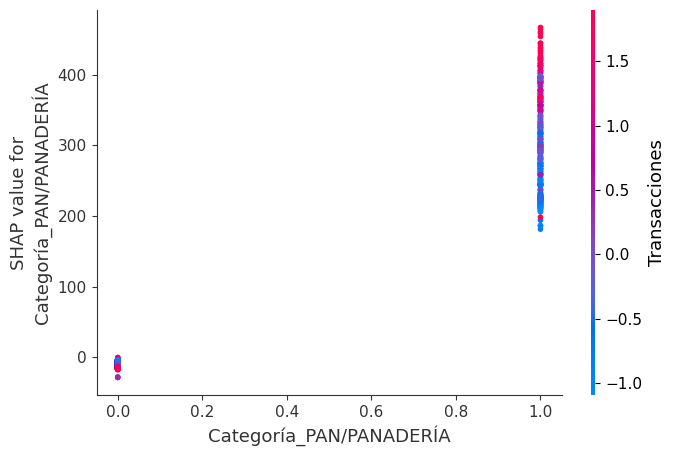

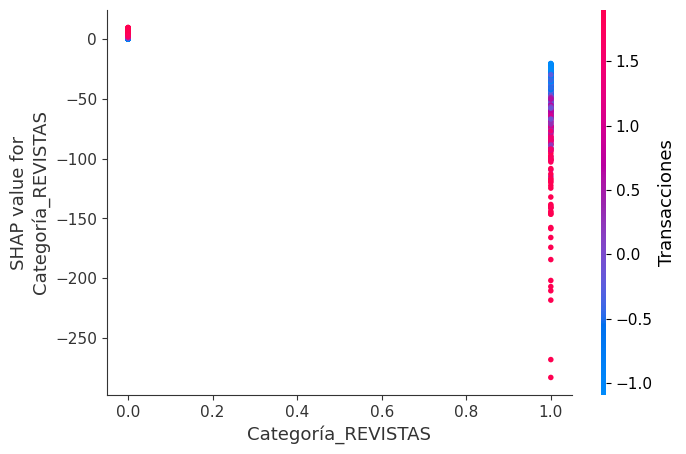

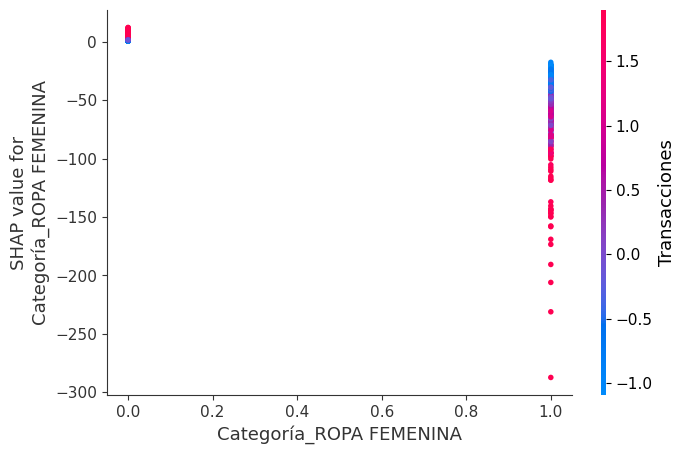

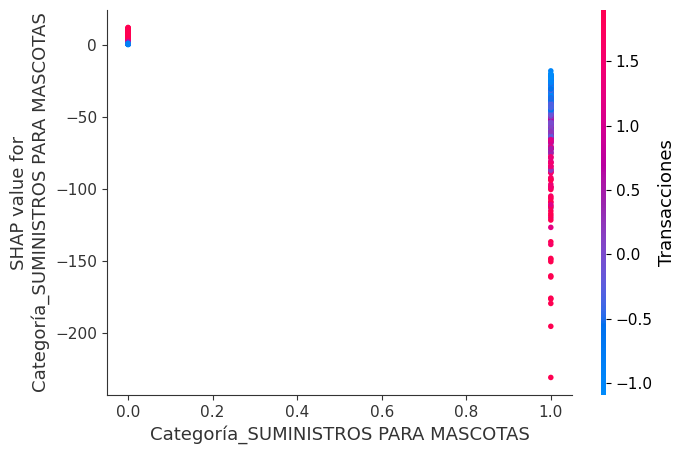

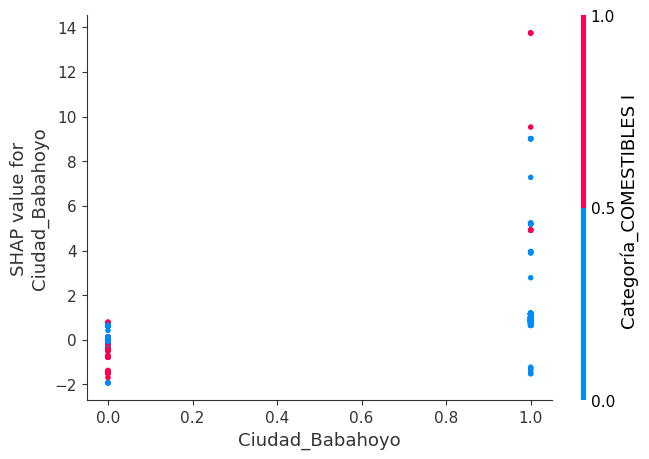

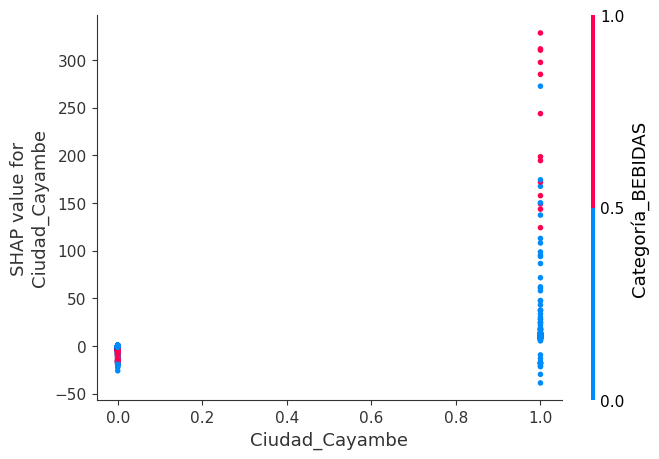

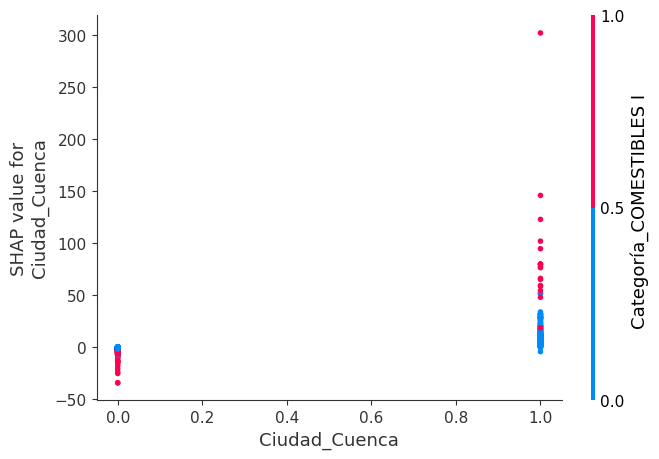

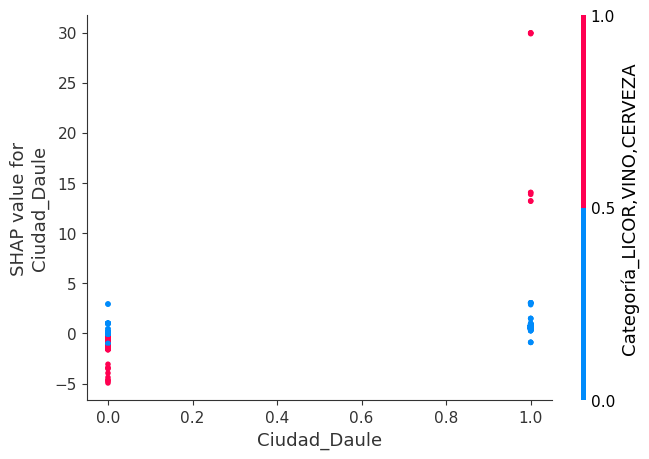

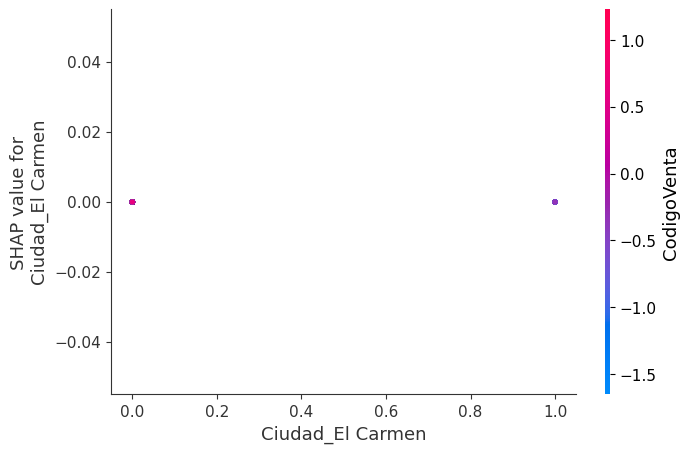

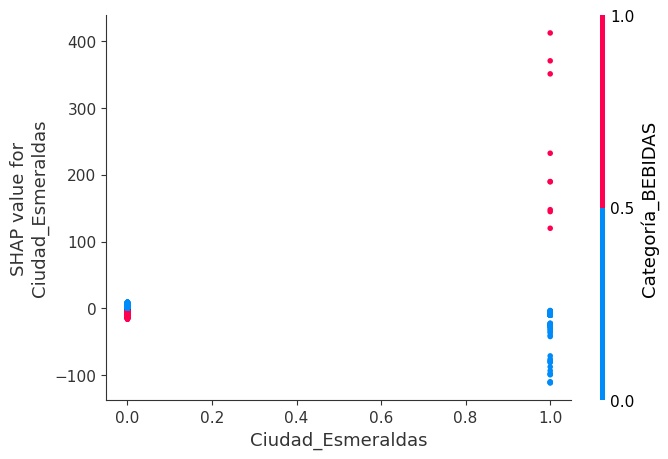

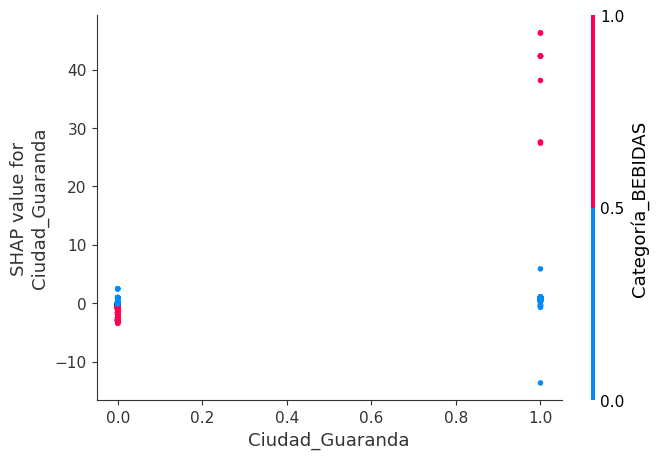

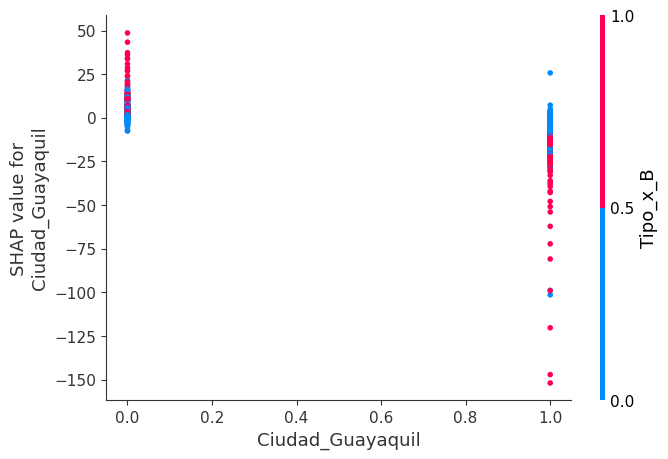

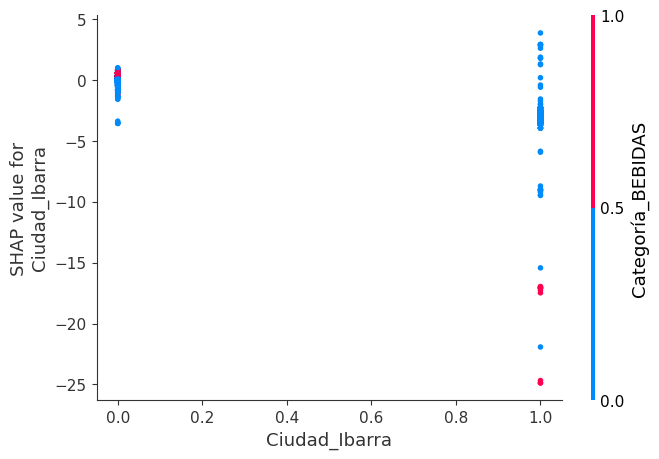

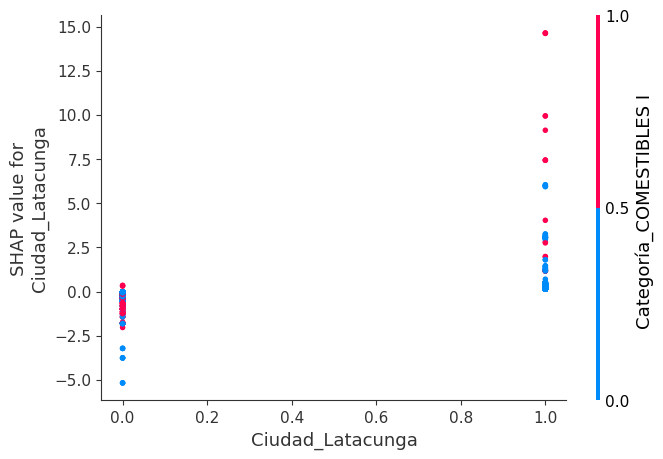

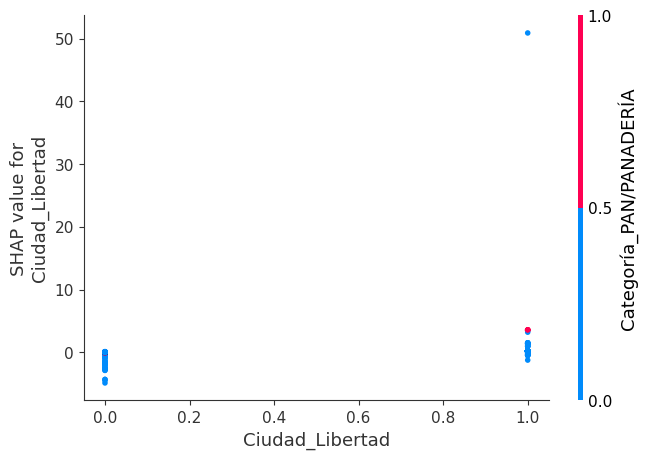

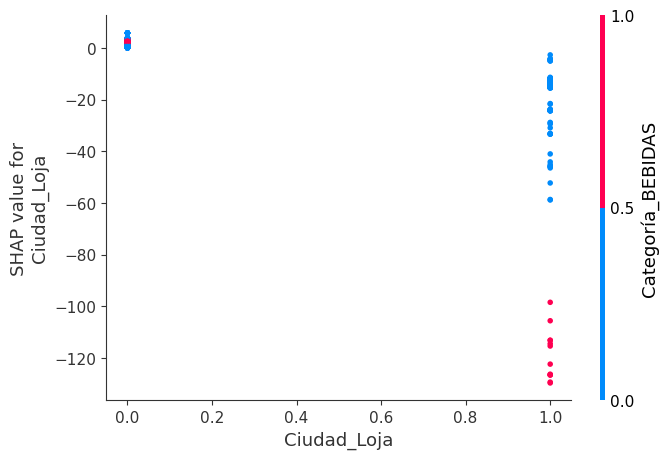

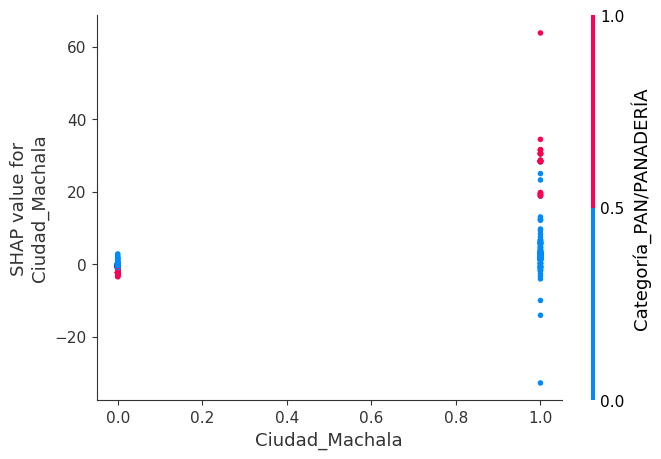

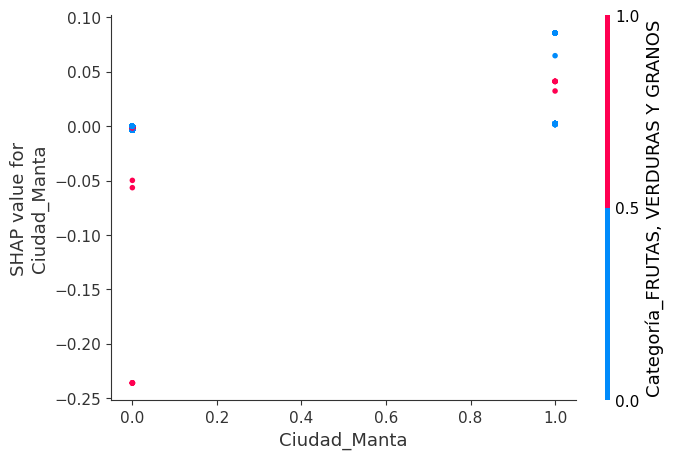

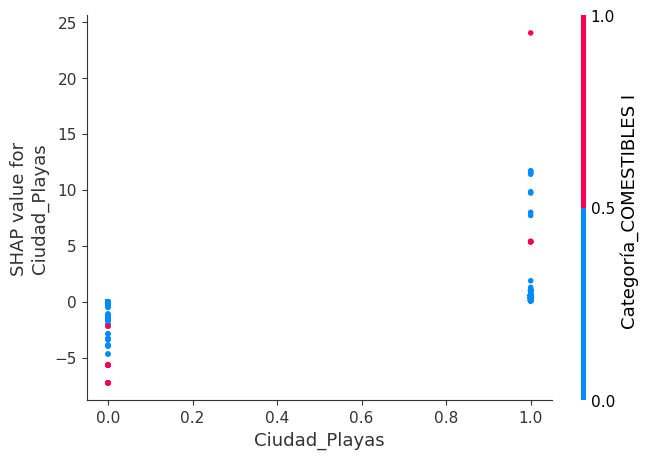

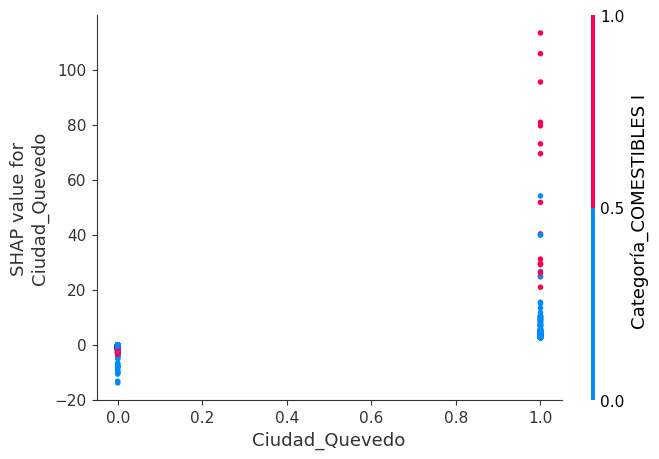

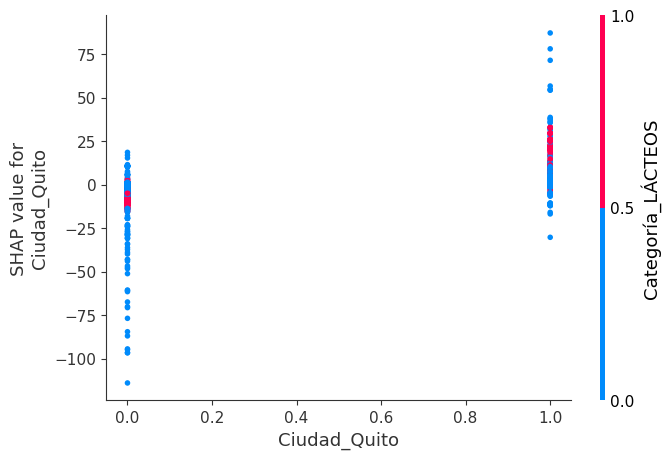

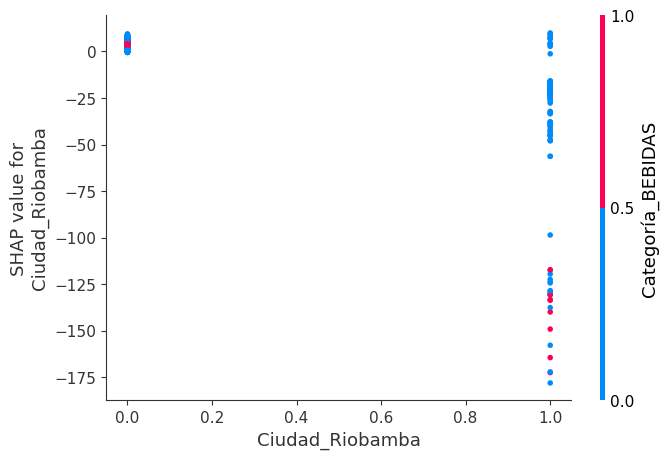

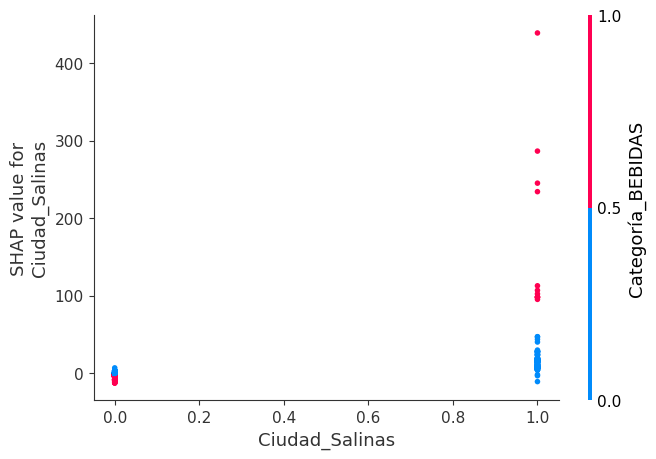

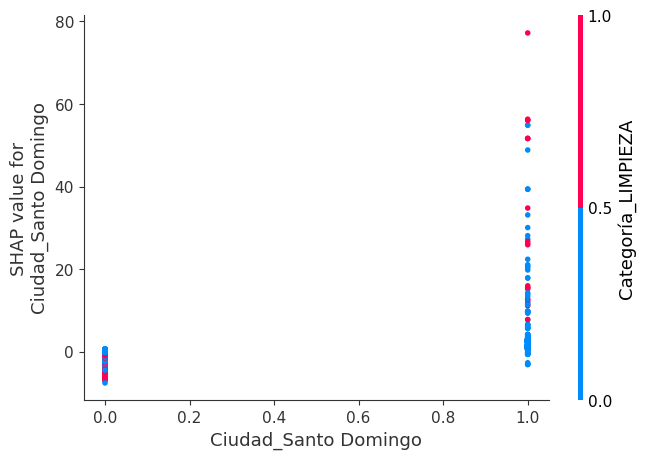

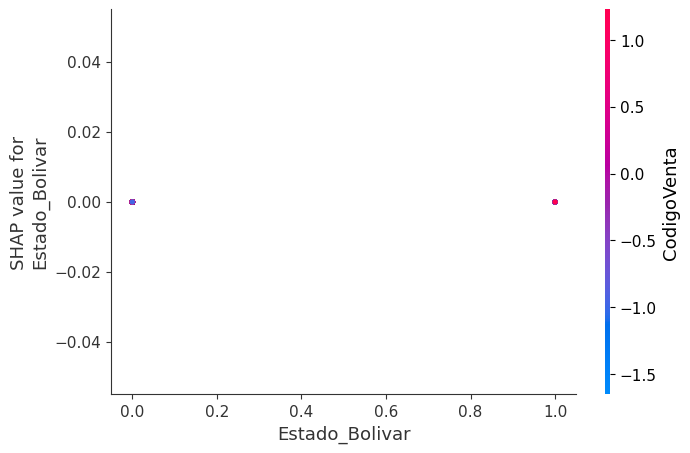

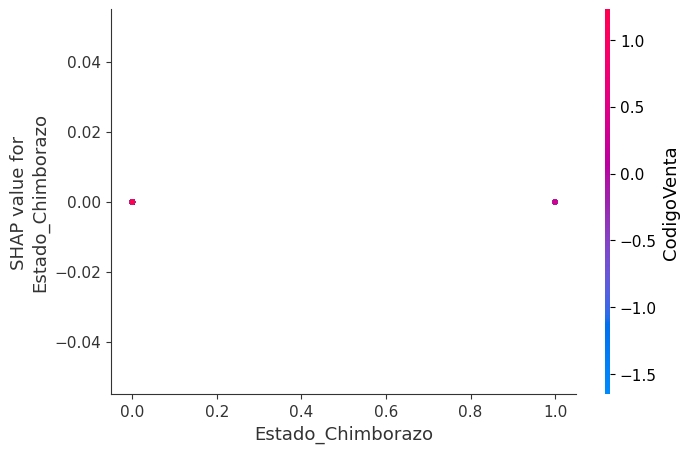

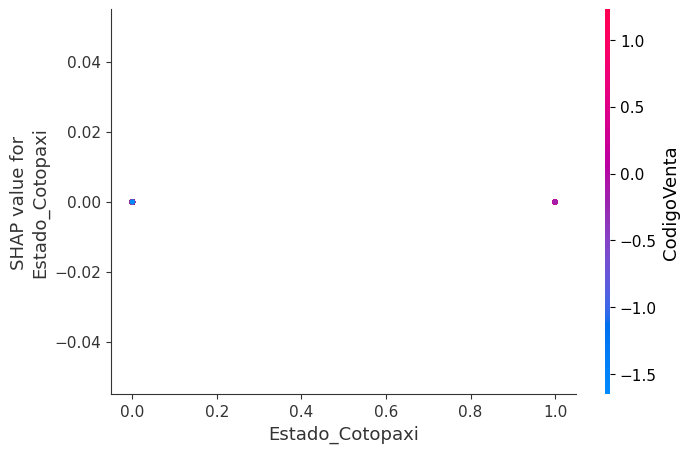

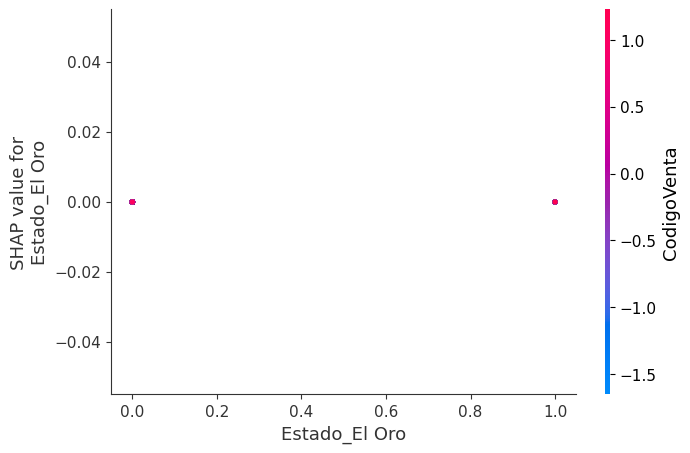

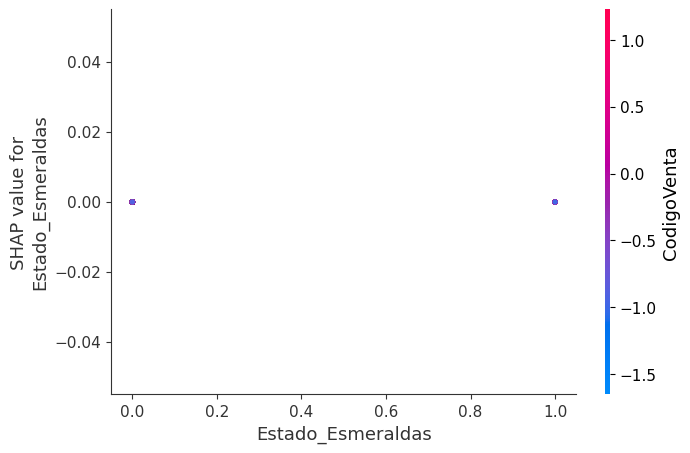

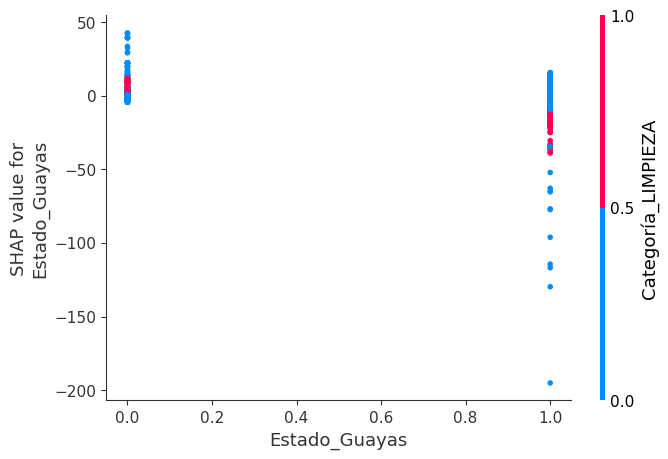

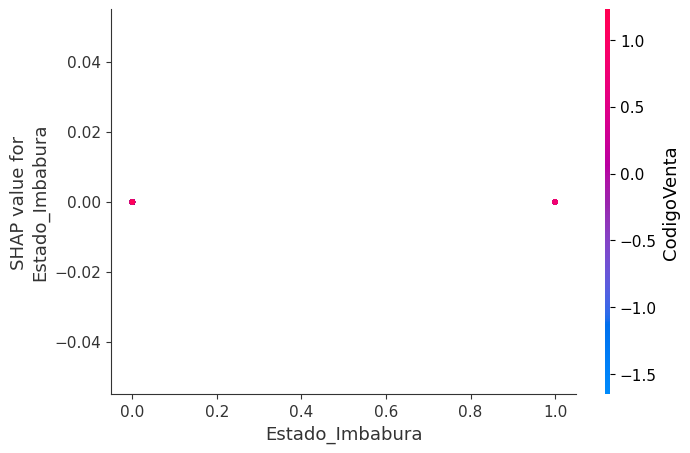

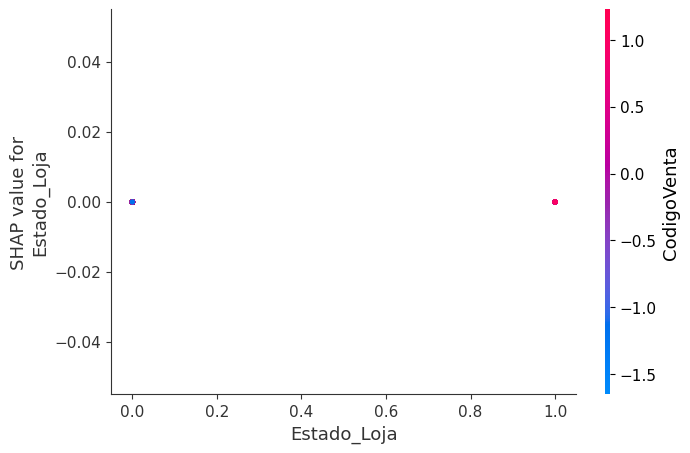

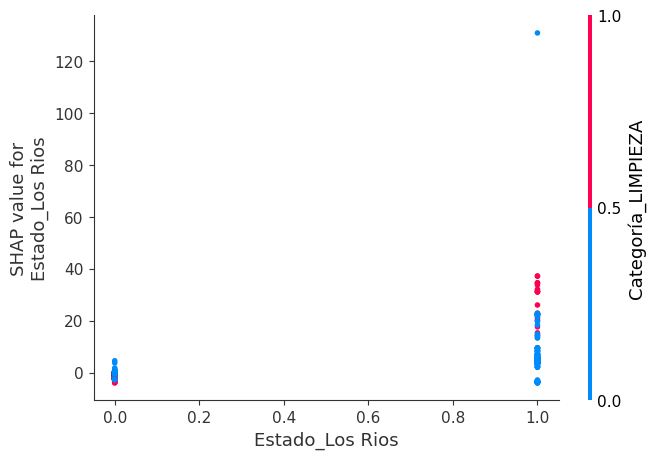

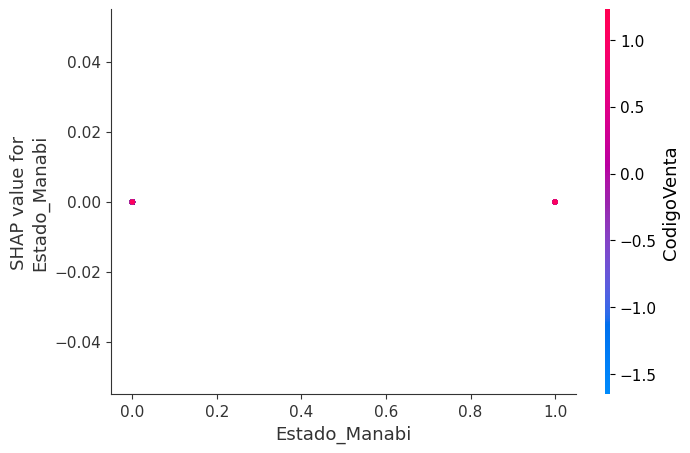

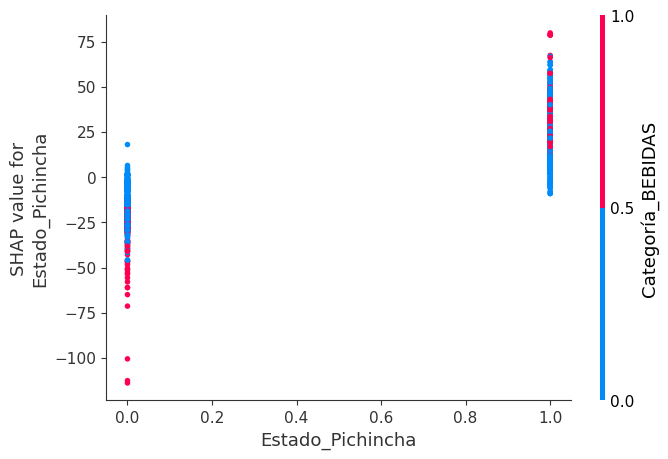

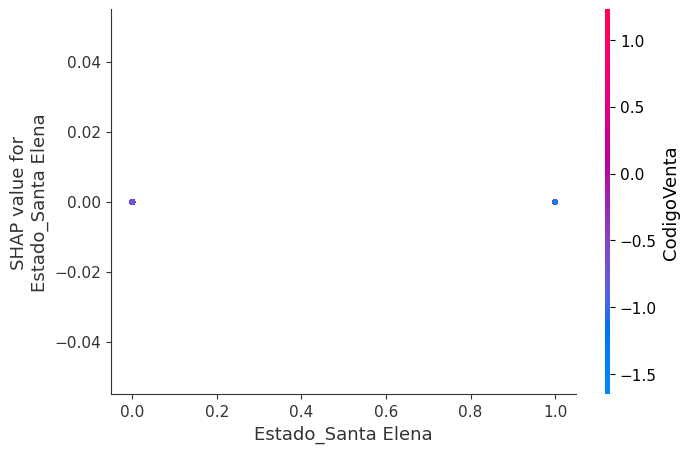

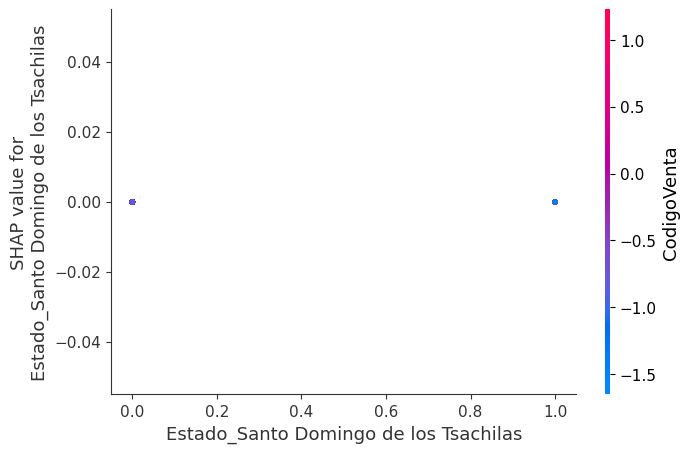

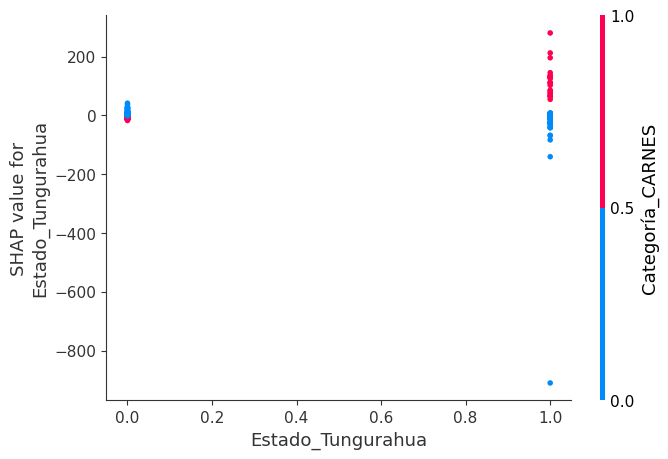

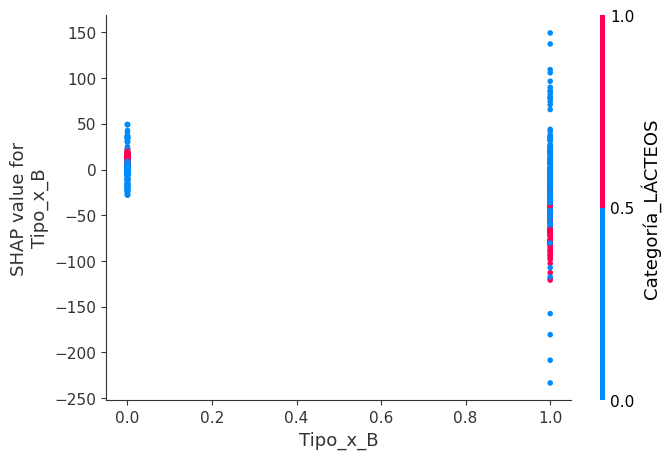

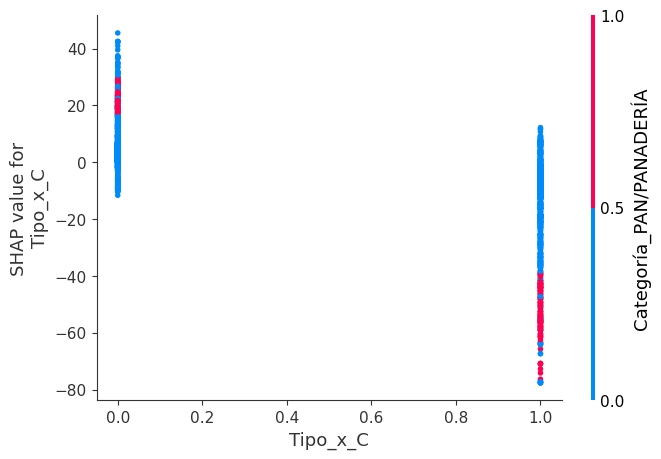

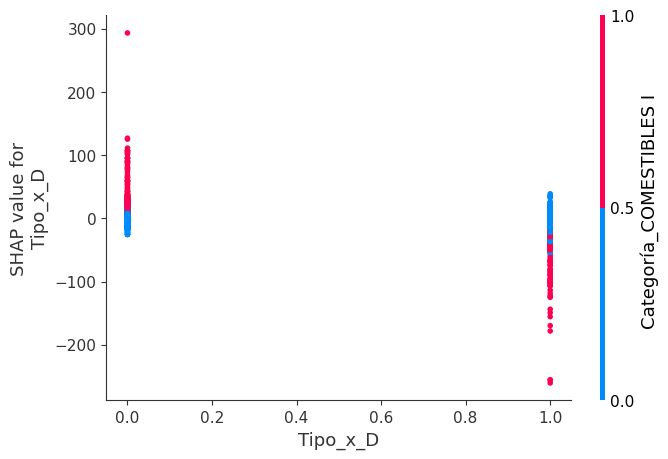

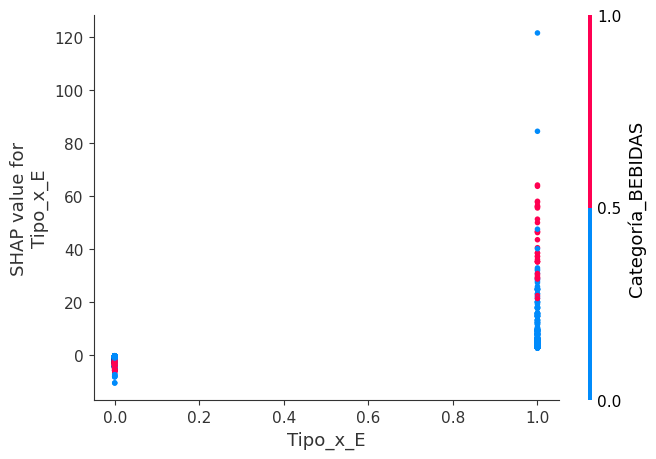

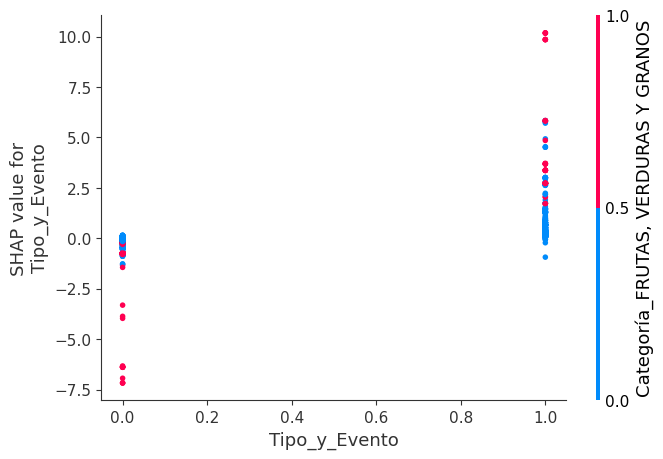

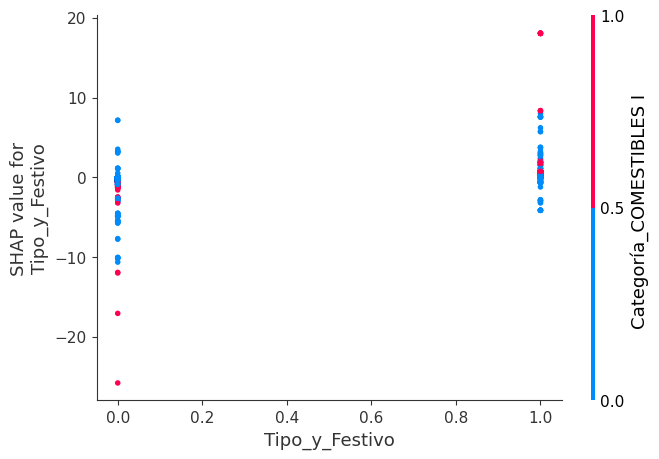

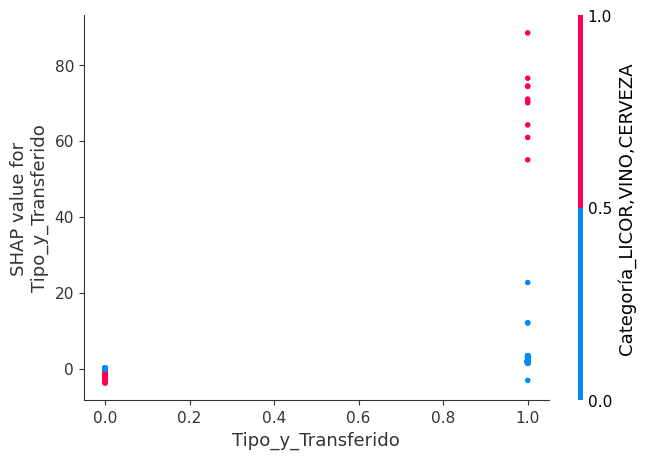

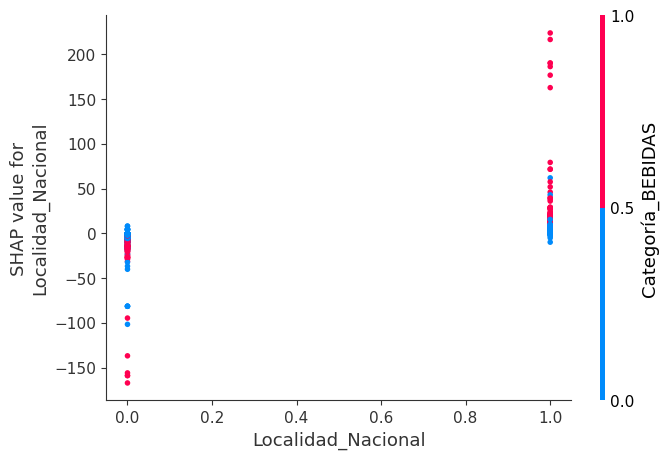

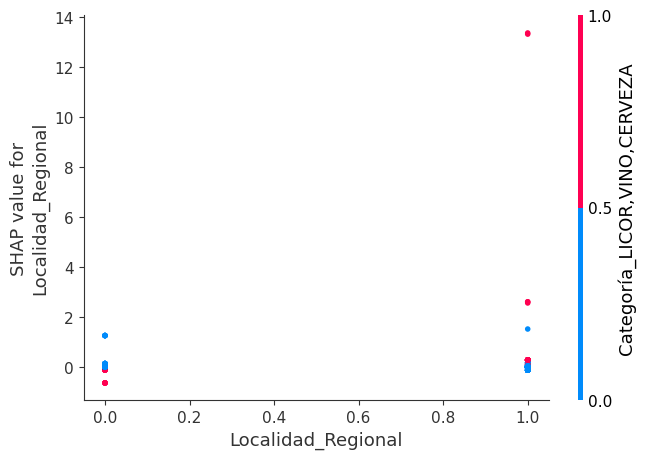

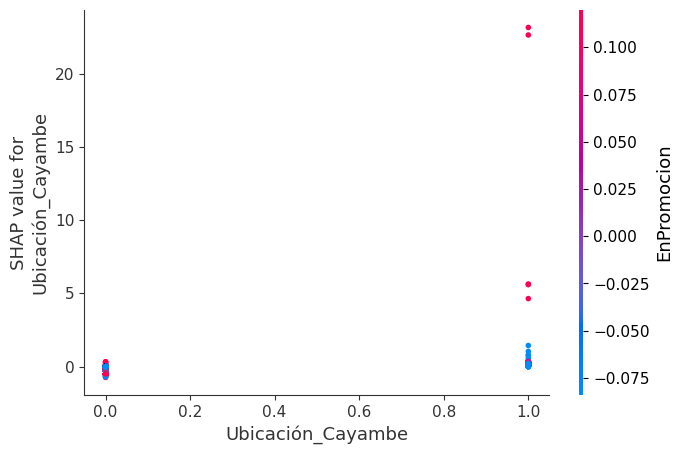

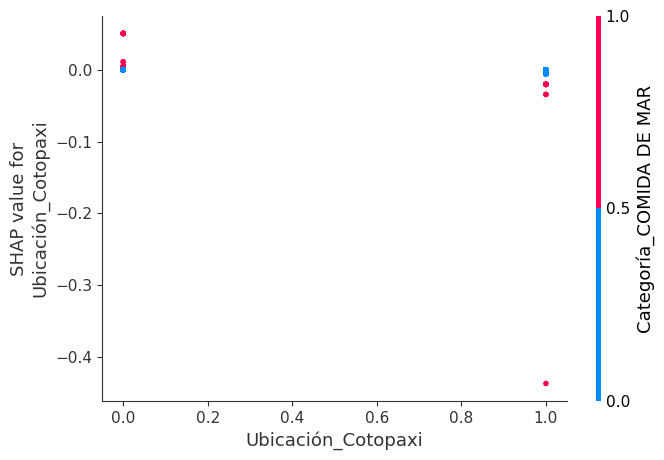

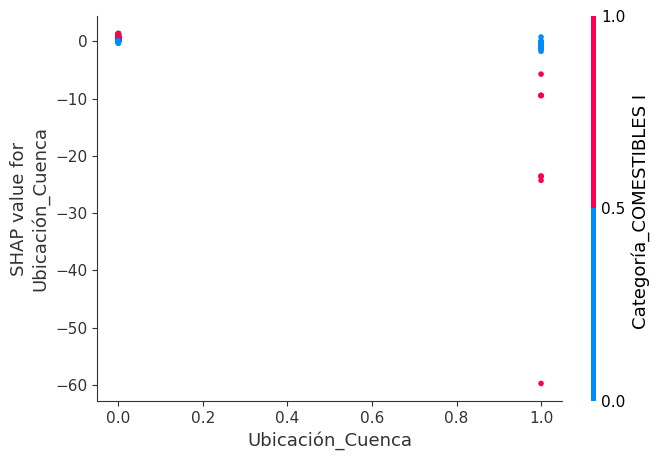

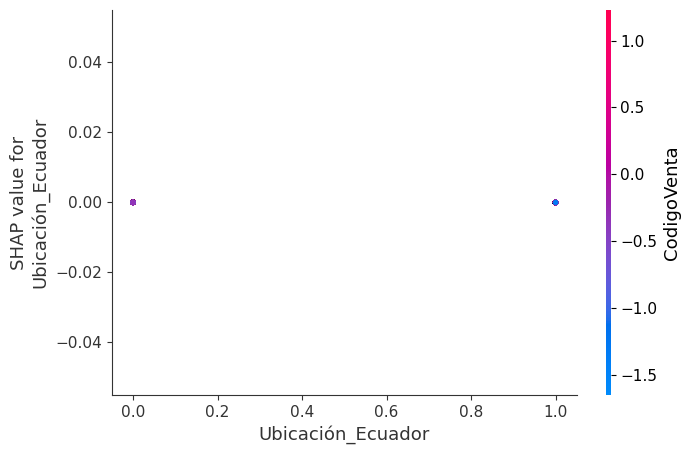

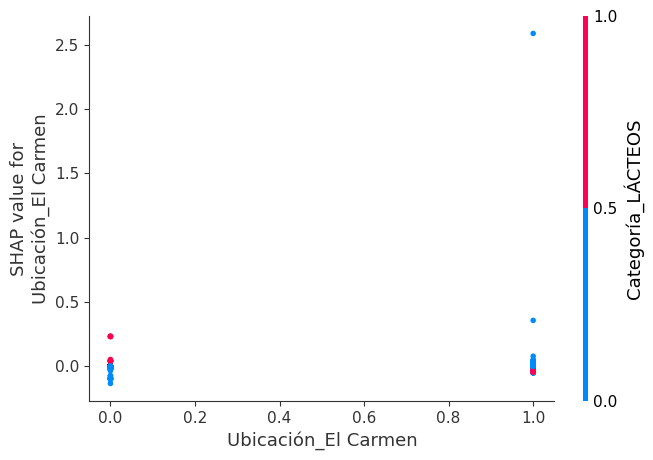

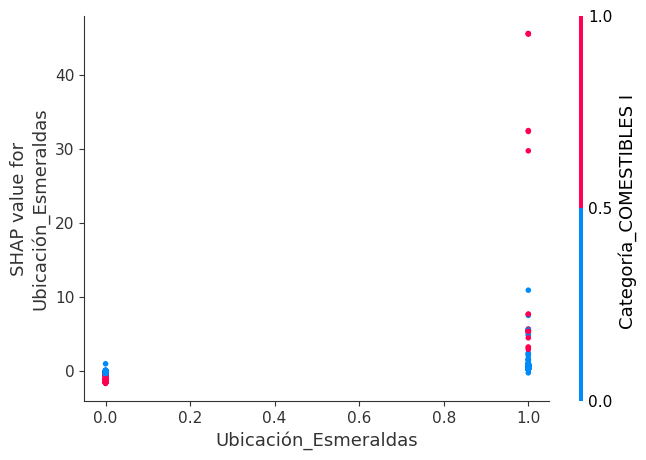

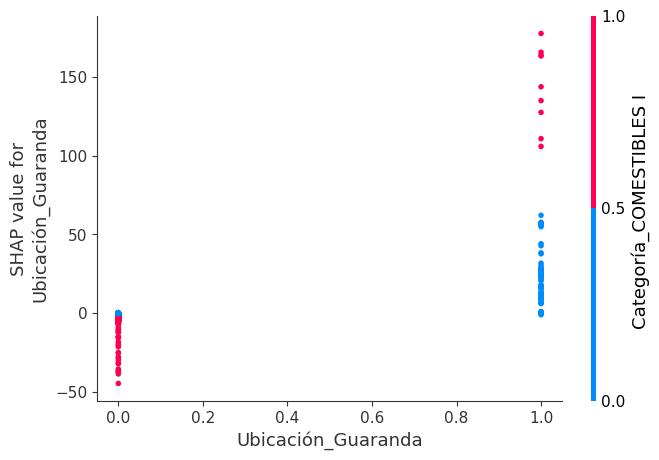

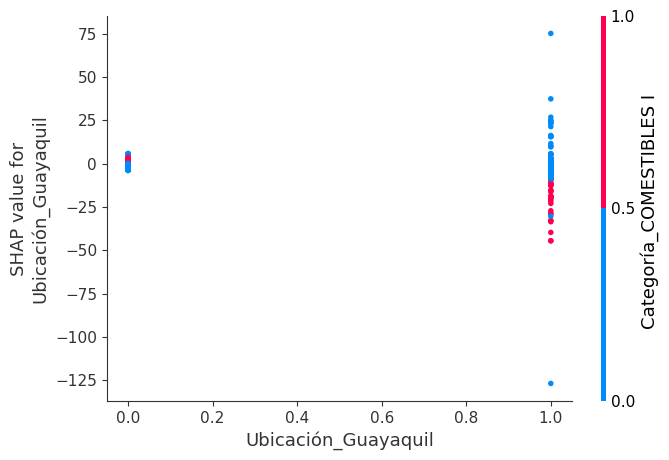

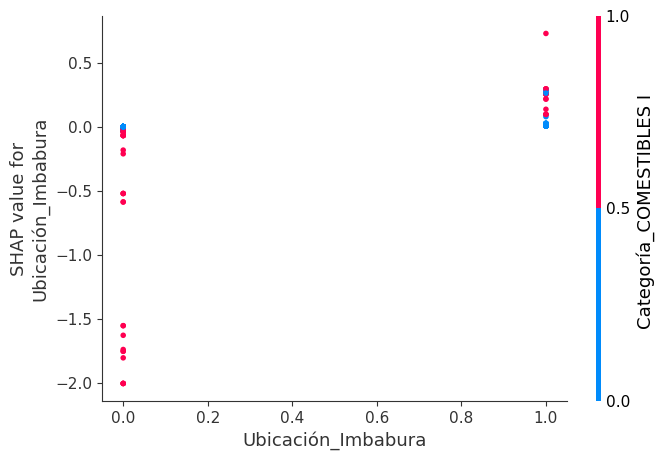

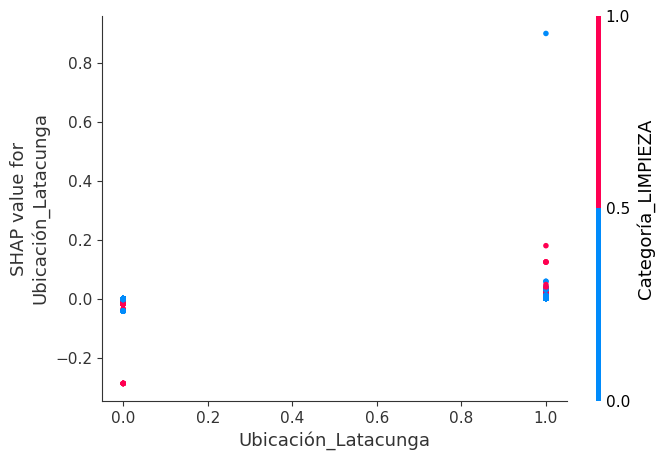

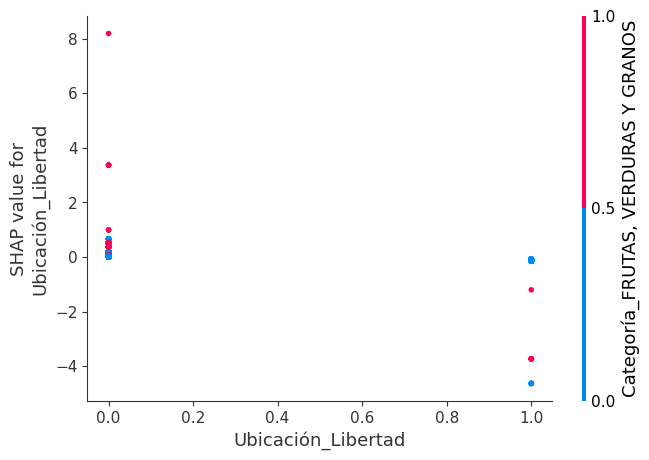

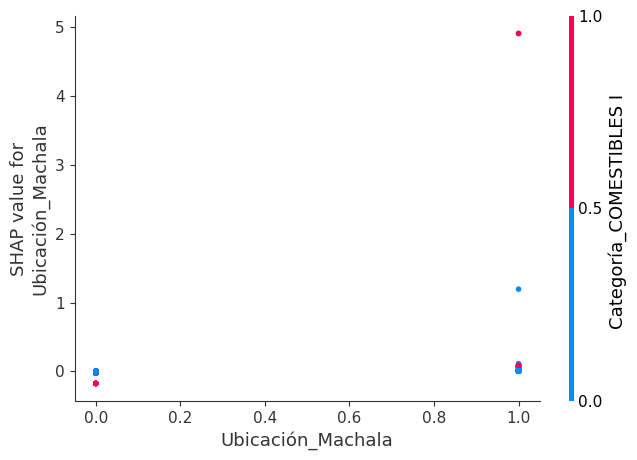

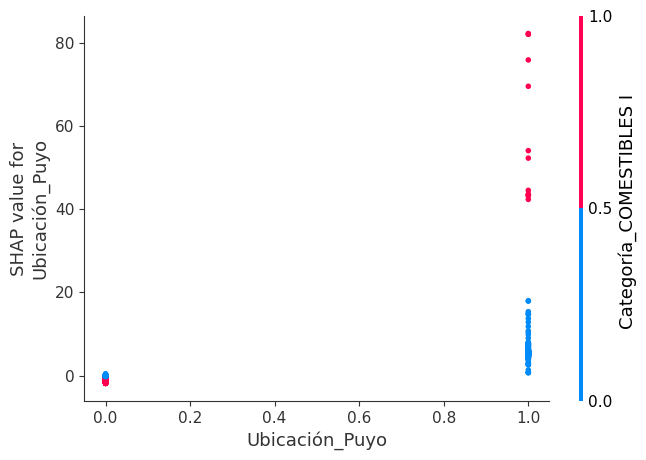

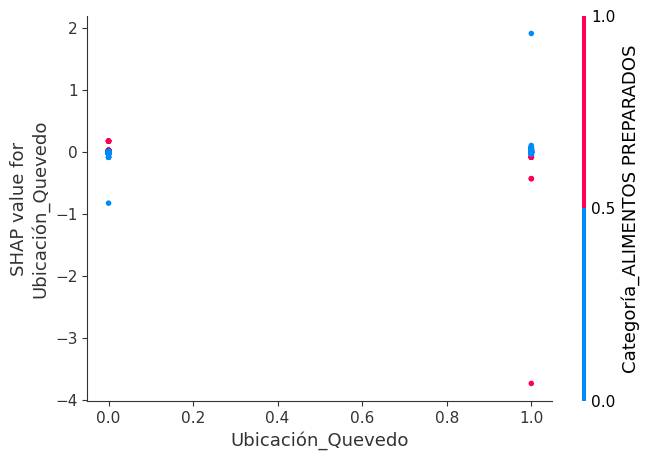

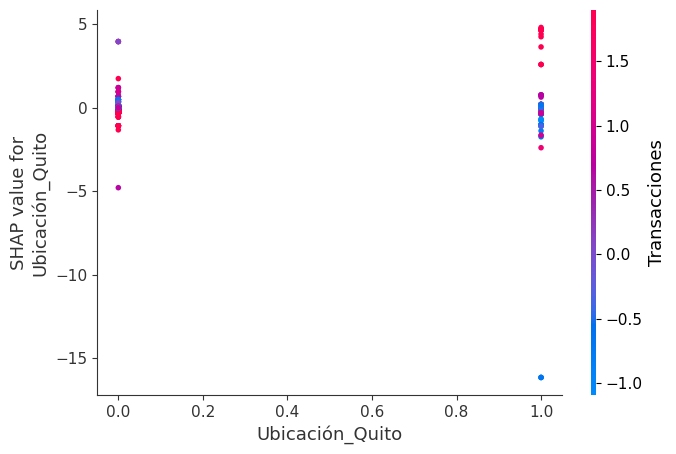

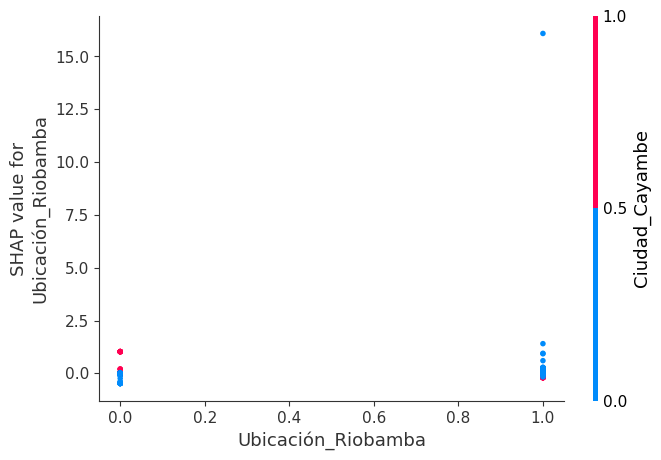

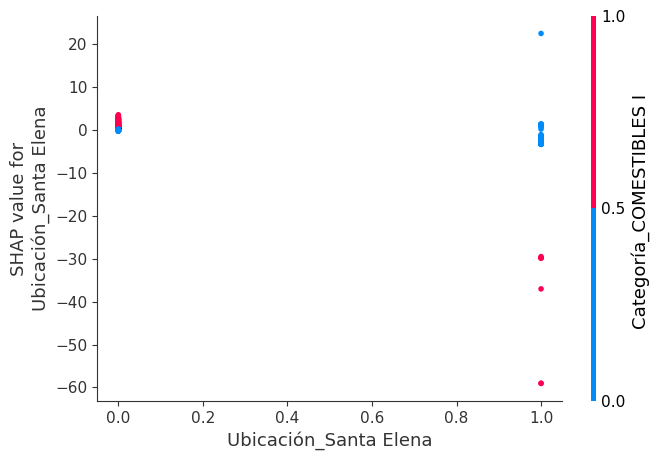

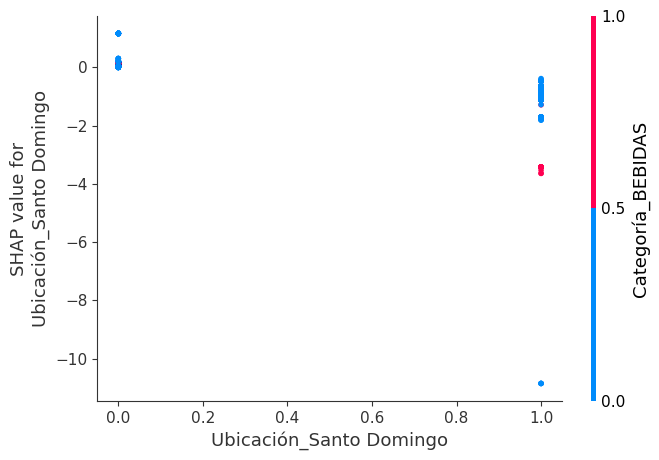

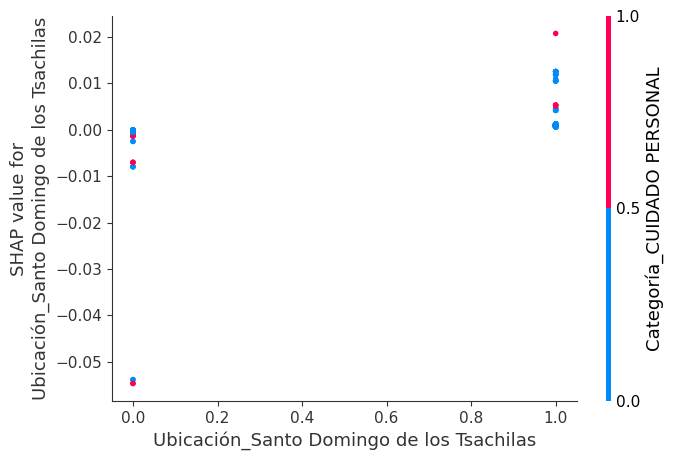

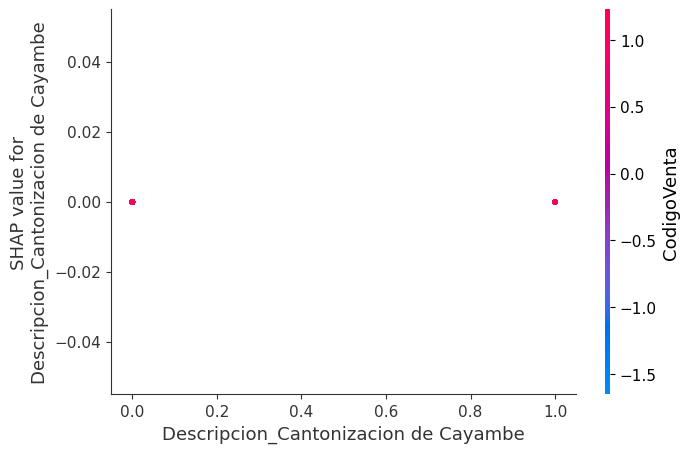

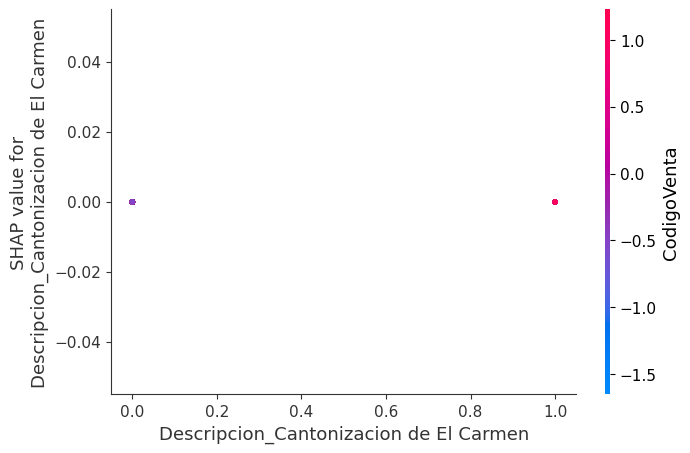

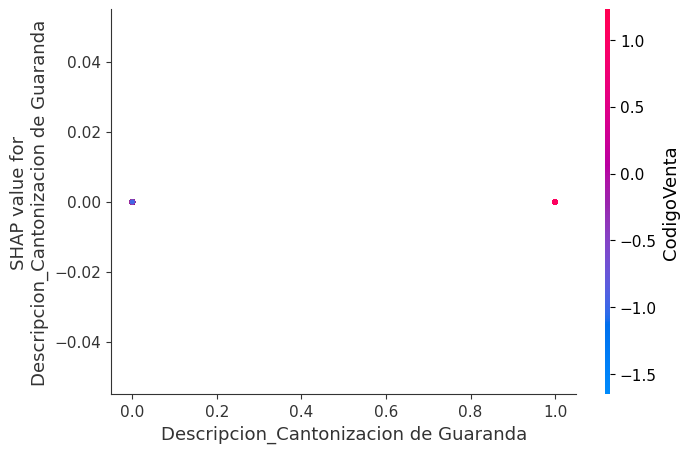

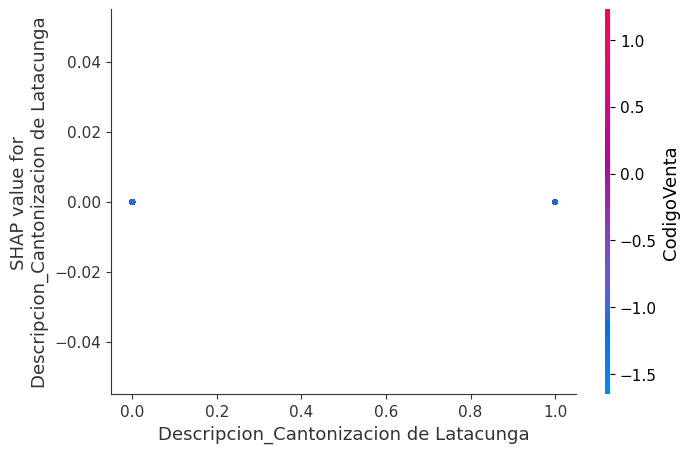

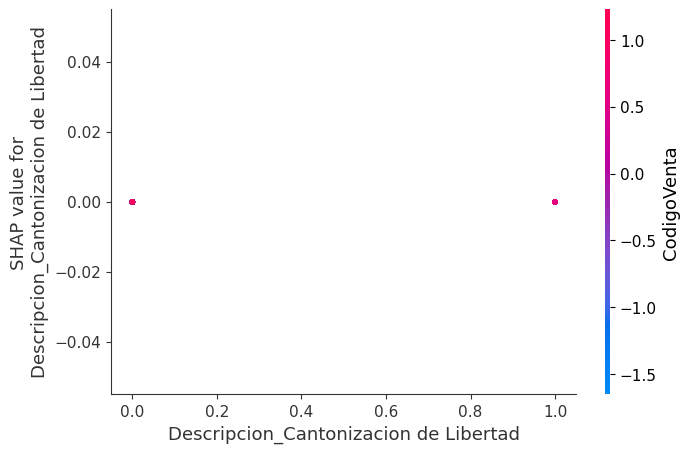

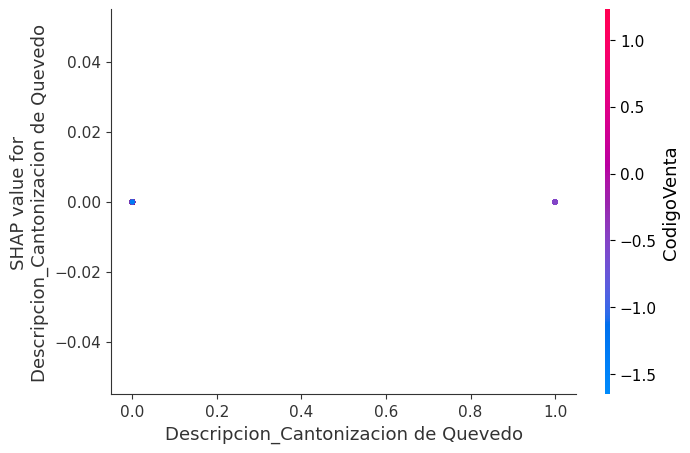

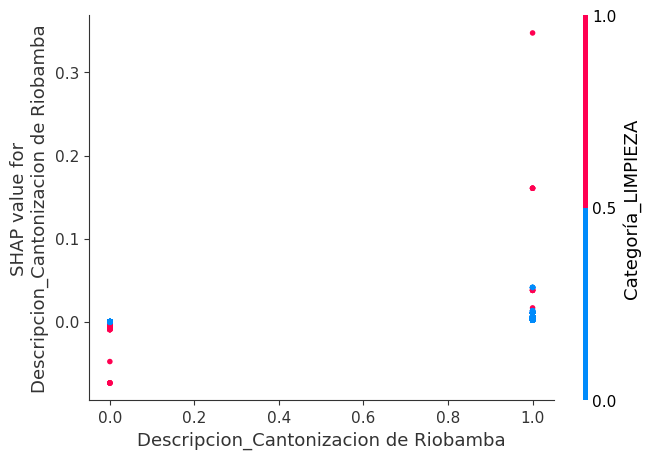

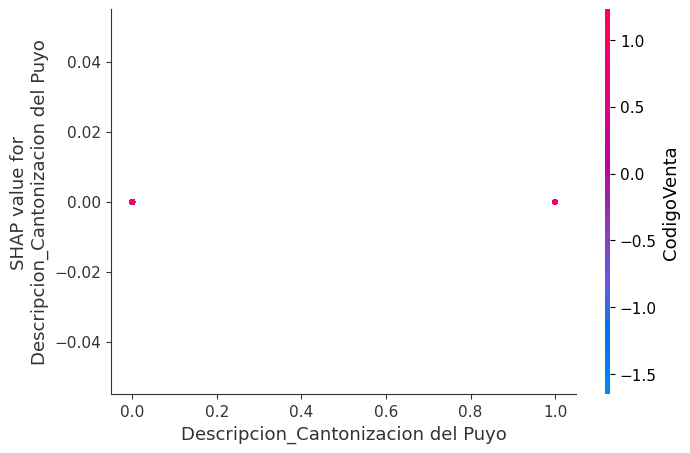

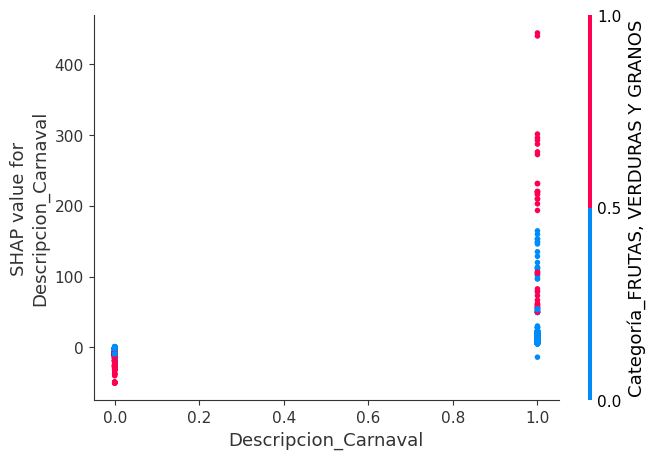

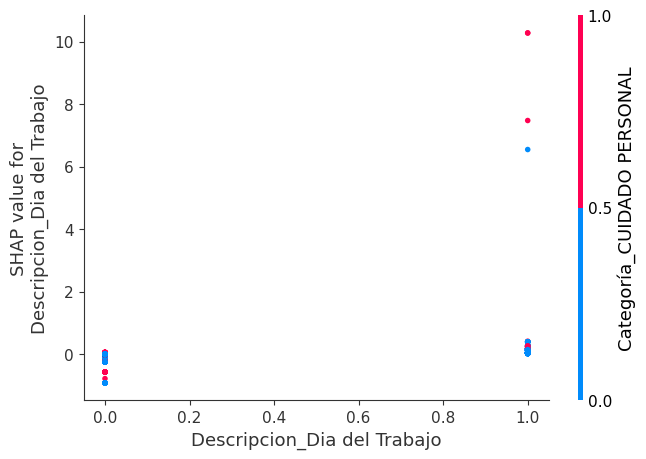

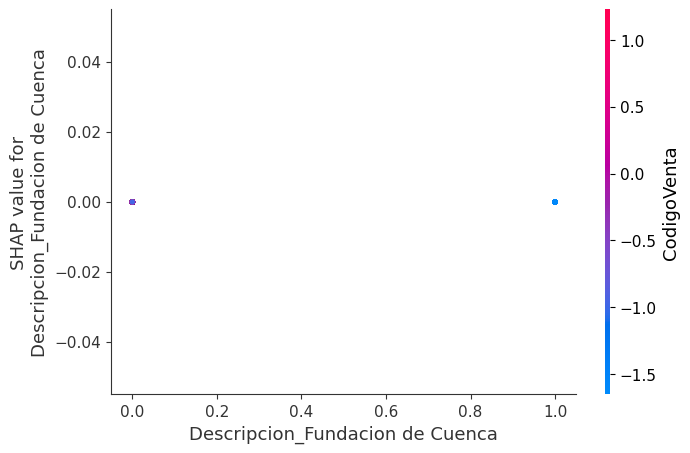

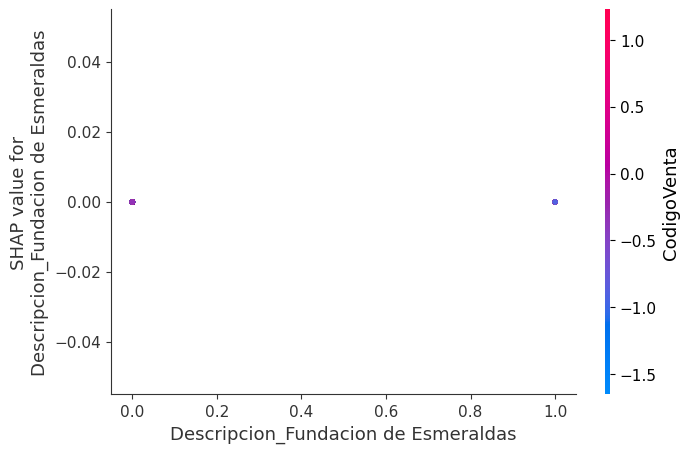

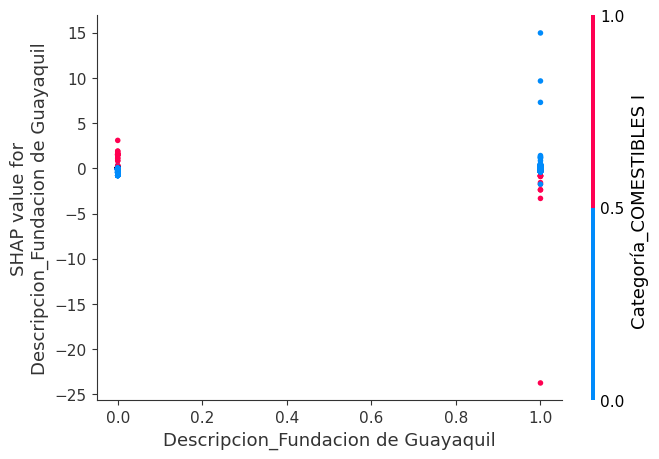

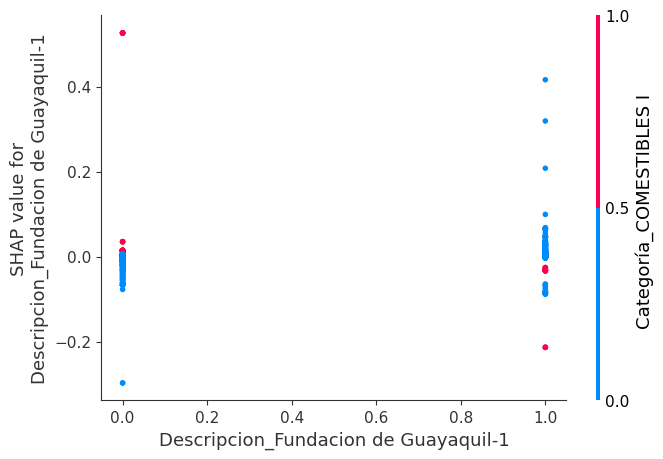

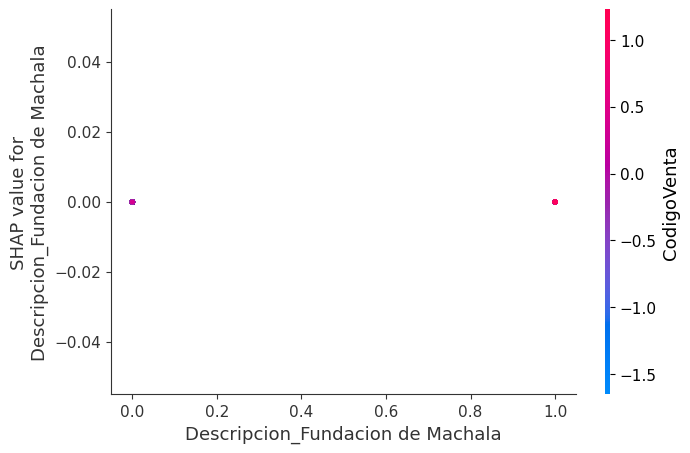

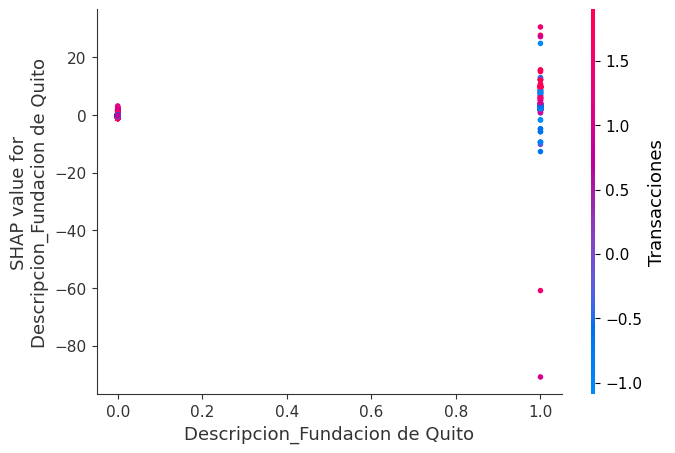

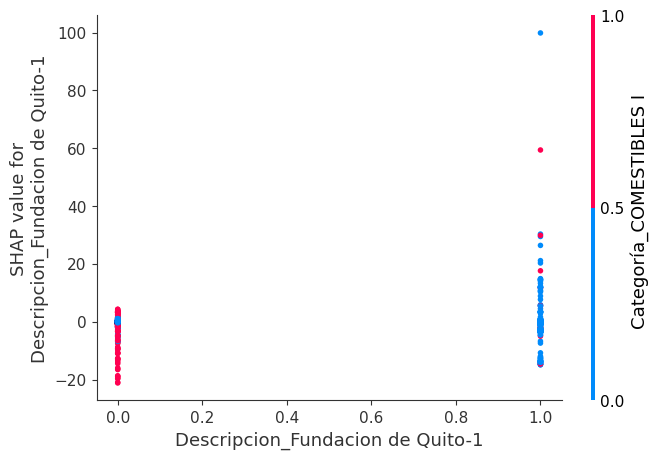

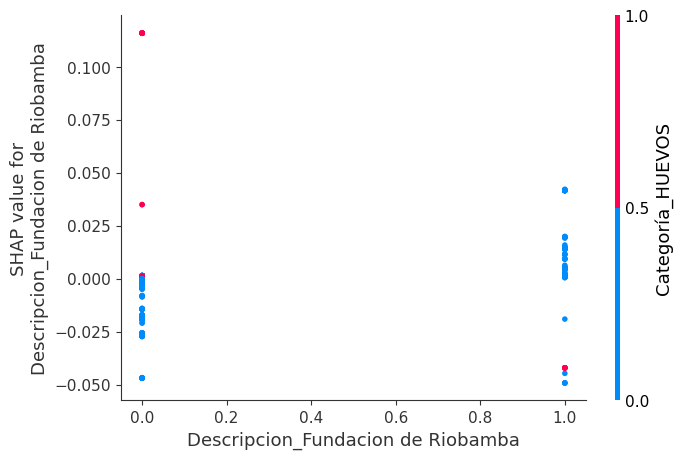

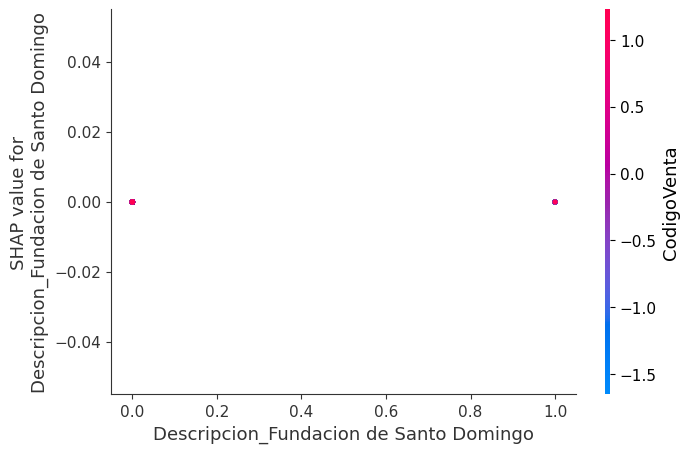

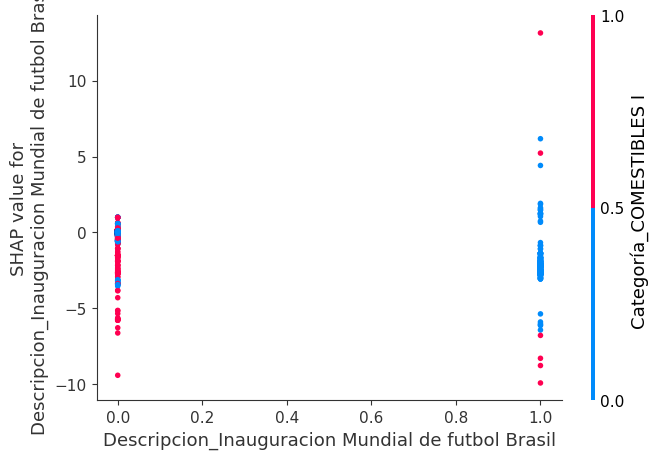

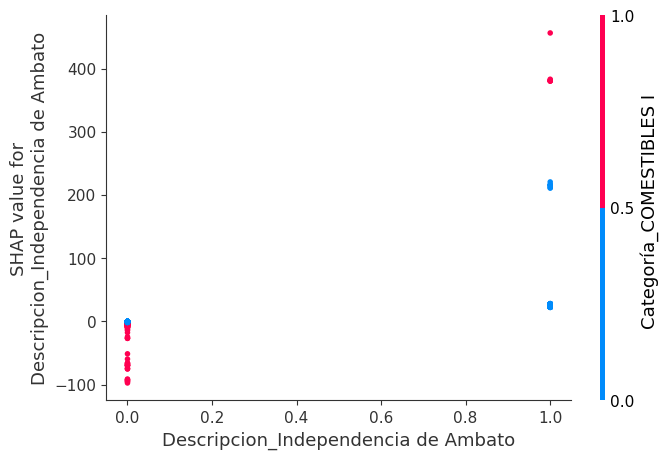

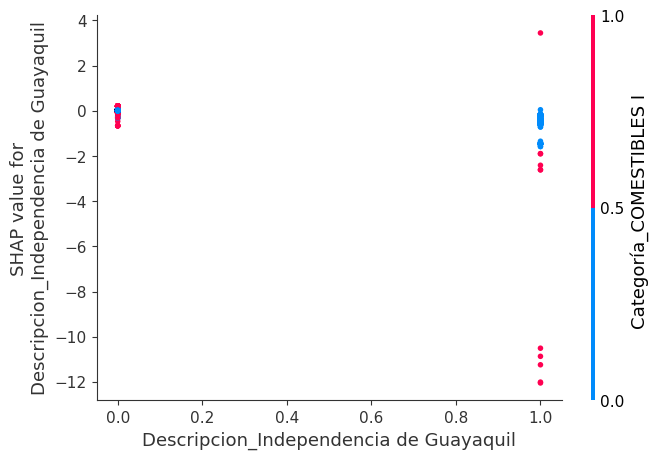

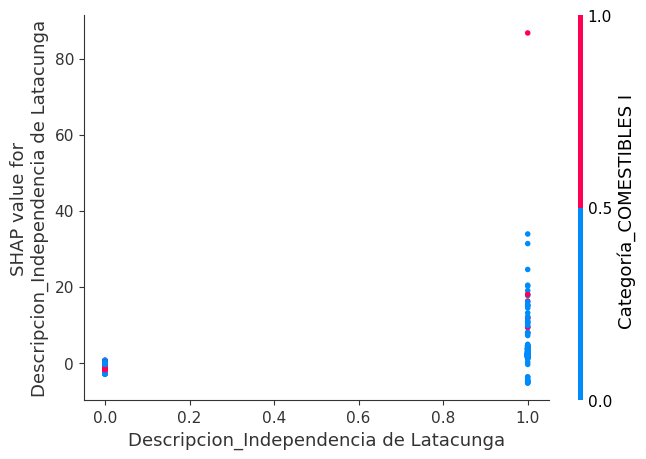

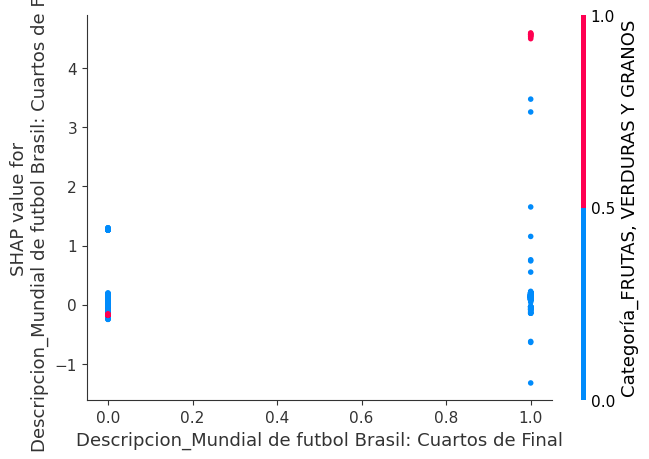

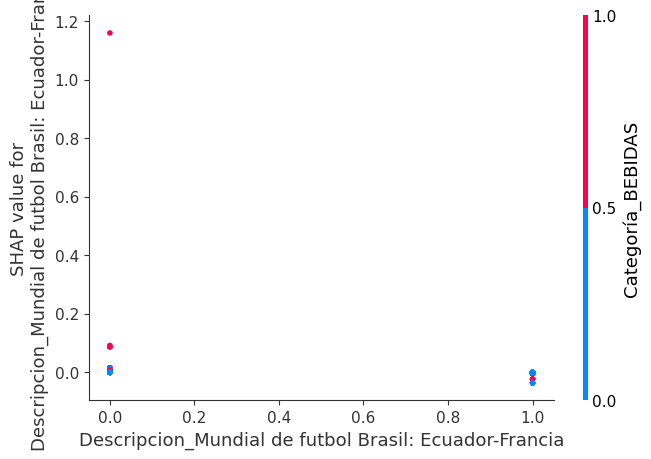

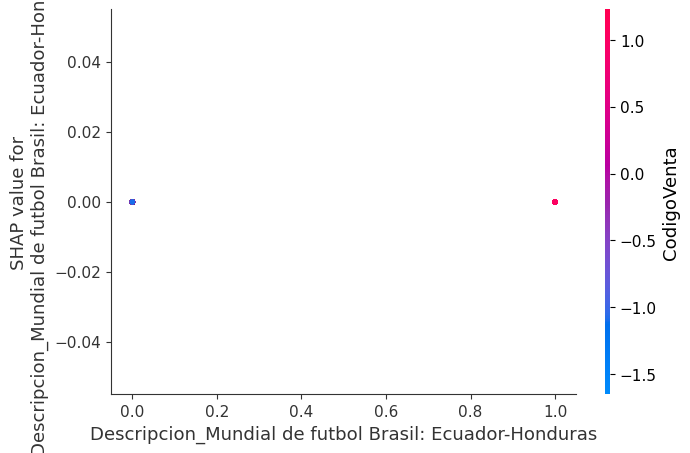

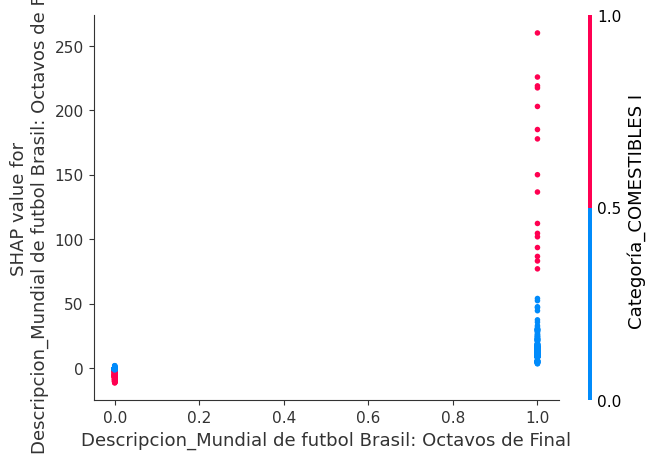

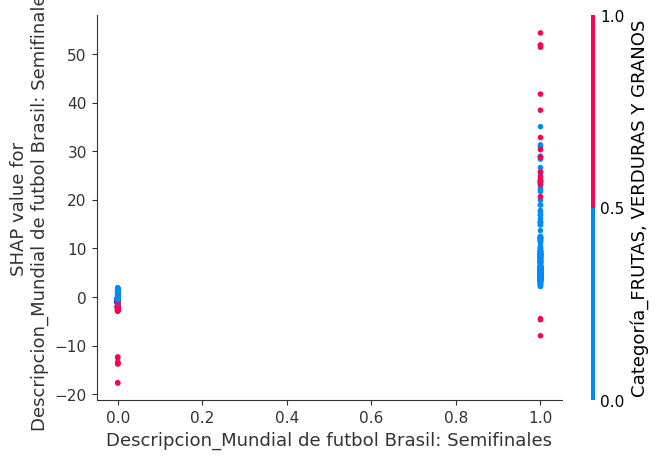

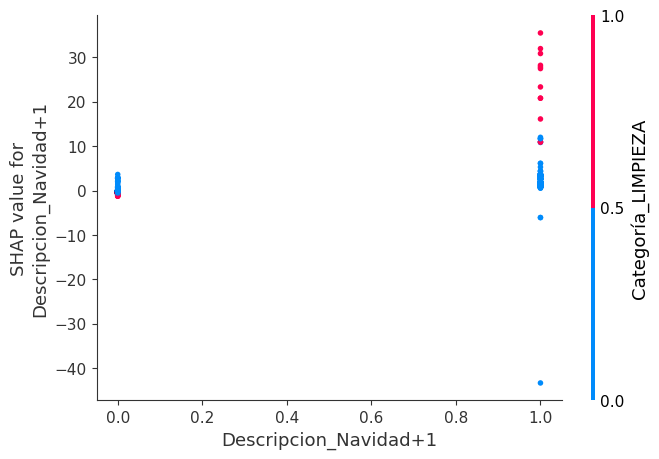

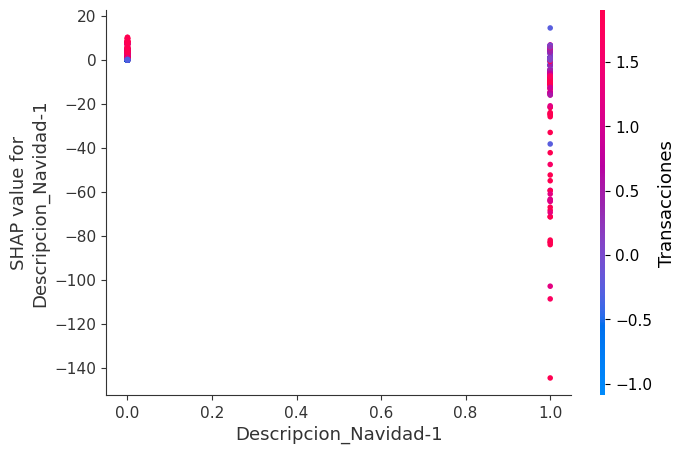

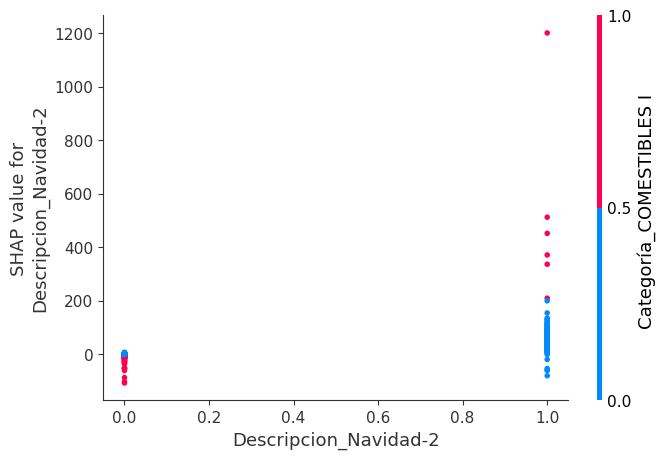

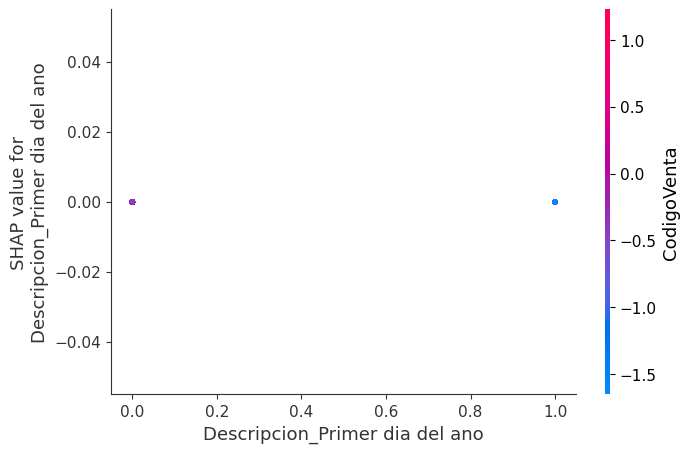

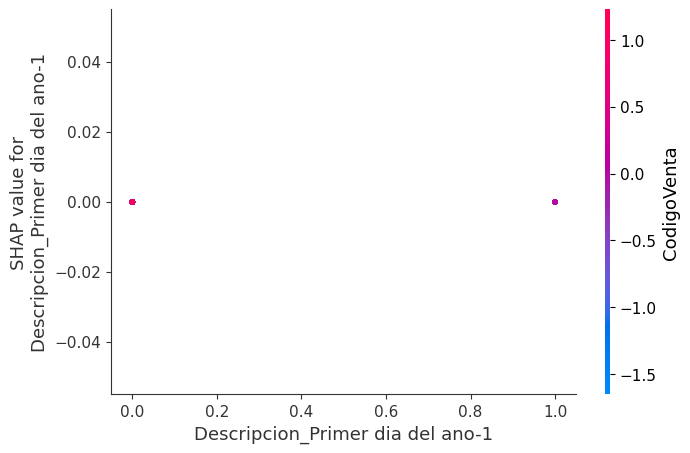

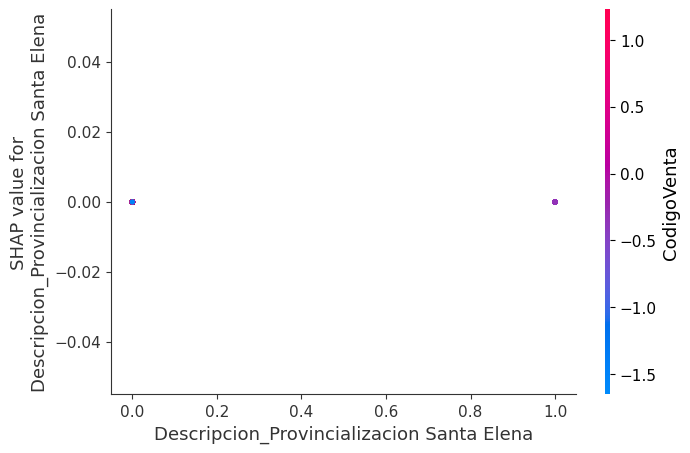

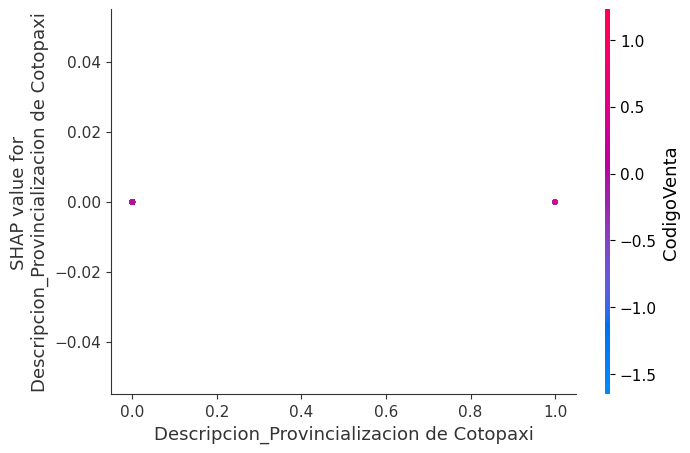

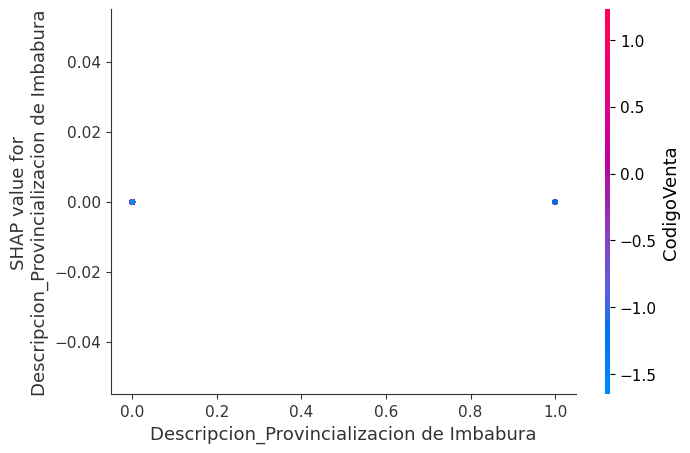

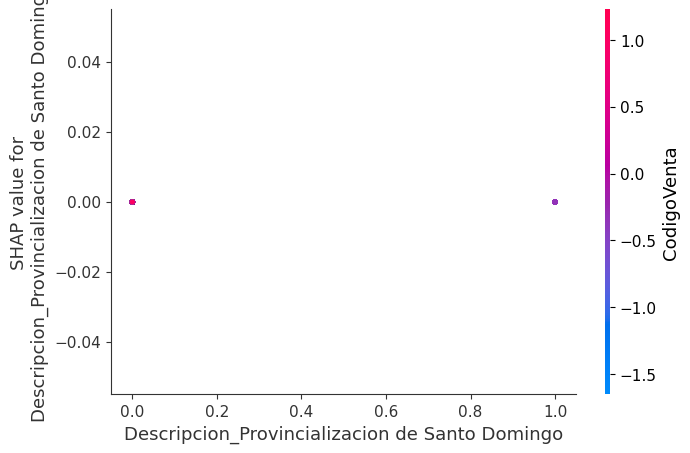

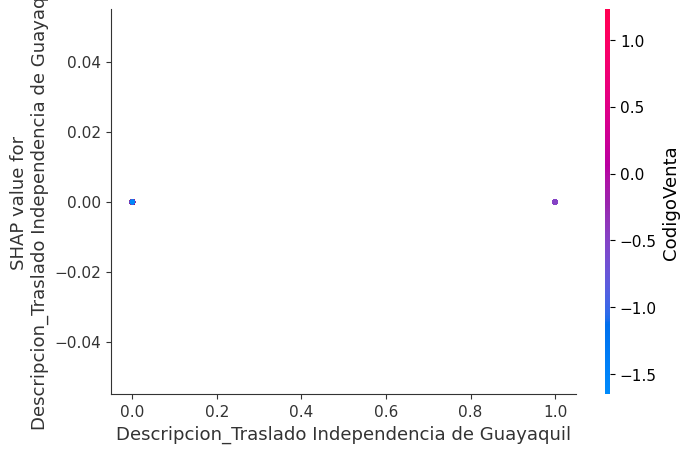

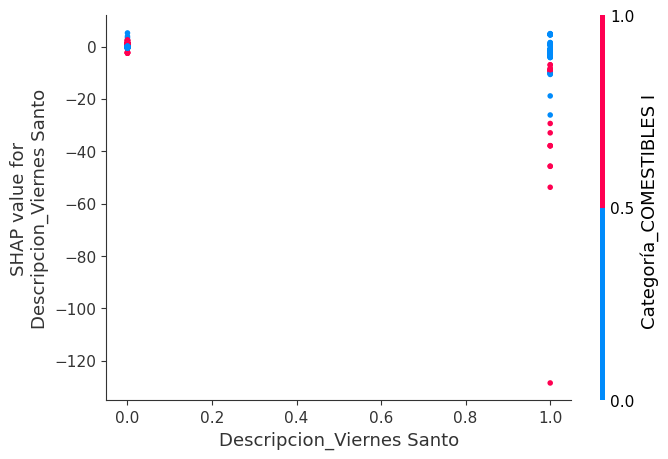

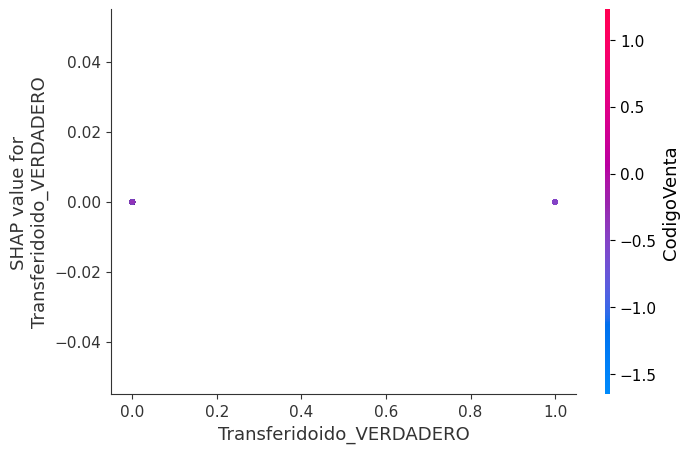

In [75]:
for name in x_test1.columns:
    shap.dependence_plot(name, shap_values_tree, x_test1, display_features=x_test1)

##### Decision Plot

In [80]:

# sub-muestra  de  datos de prueba
x_test1_sample = x_test1[:1000]

# crear Explicador
explainer = shap.TreeExplainer(modelo_top)

# calcular valores de shap basados en arboles
shap_values_tree2= explainer.shap_values(x_test1_sample)



[15:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


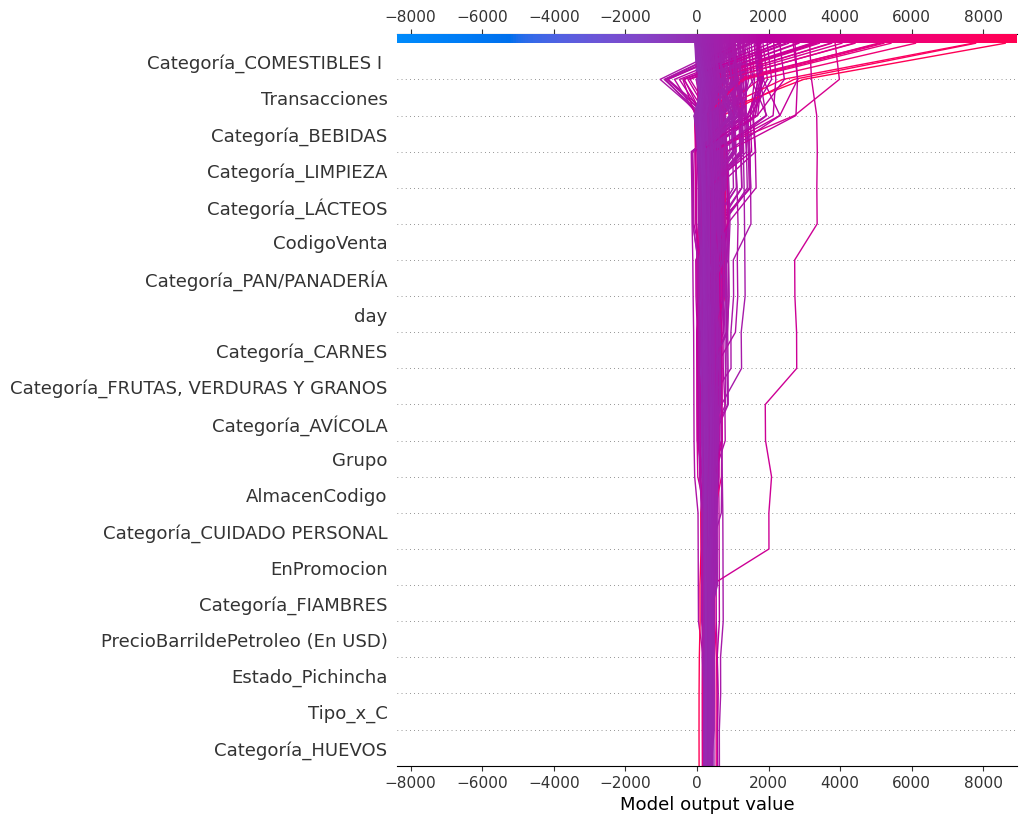

In [81]:
shap.decision_plot(explainer.expected_value, shap_values_tree2, x_test1.columns)